# Signate開始時のお約束

In [198]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [199]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=4ddfaa36690fe86e02be7e0e97ca0f236e55f823c508f4bf1bedef3c760e03da
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [ ]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [ ]:
!pip install kanjize

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.4 MB/s eta 0:00:00


In [ ]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [ ]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [ ]:
# 元のカラム順
colorigin = all_df.columns

<ipython-input-146-8331b9fb236d>:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

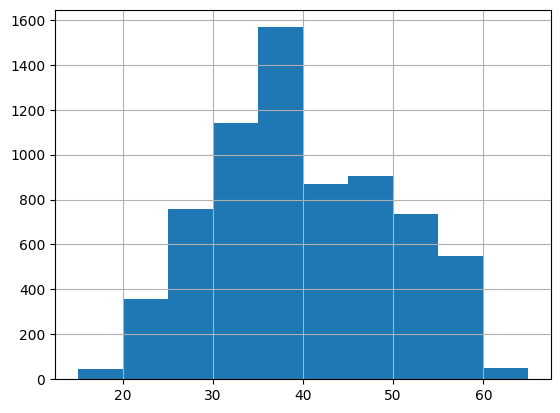

In [ ]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10歳で分けて5足す
    tmp = tmp//10 * 10
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムを描く
all_df["Age"].hist()

In [ ]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損は最頻値で補完する
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

# one-hot化して追加する
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 0
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 1

# 列名を変更
all_df = all_df.rename(columns={"TypeofContact":"CompanyInvited"})

all_df["CompanyInvited"] = all_df["CompanyInvited"].astype(int)
print(all_df["CompanyInvited"].value_counts())

CompanyInvited
0    4462
1    2516
Name: count, dtype: int64


In [ ]:
#########################
# "CityTier"の処理 #
#########################
print(all_df["CityTier"].value_counts())

CityTier
2    3160
1    2991
3     827
Name: count, dtype: int64


In [ ]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 重要でないため、10分刻みのカテゴリにする
all_df["DurationOfPitch"] = (all_df["DurationOfPitch"].values // 10).astype(int)

# 分布を確認する
print(all_df["DurationOfPitch"].value_counts())

DurationOfPitch
1    3824
0    1984
2     709
3     461
Name: count, dtype: int64


In [ ]:
####################
# "Occupation"の処理 #
####################
# 特徴量を追加する
all_df["SmallBusiness"] = 0
all_df["Salaried"] = 0
all_df["LargeBusiness"] = 0

# one-hot化して追加する
all_df.loc[all_df["Occupation"]=="Small Business","SmallBusiness"] = 1
all_df.loc[all_df["Occupation"]=="Salaried","Salaried"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","LargeBusiness"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Occupation", axis=1)

print(all_df["SmallBusiness"].value_counts())
print(all_df["Salaried"].value_counts())
print(all_df["LargeBusiness"].value_counts())

SmallBusiness
0    3522
1    3456
Name: count, dtype: int64
Salaried
0    4177
1    2801
Name: count, dtype: int64
LargeBusiness
0    6257
1     721
Name: count, dtype: int64


In [ ]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])
  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

# one-hot化して追加する
all_df.loc[all_df["Gender"]=="Male","Gender"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender"] = 0

# 列名を変更する
all_df = all_df.rename(columns={"Gender":"Male"})

all_df["Male"] = all_df["Male"].astype(int)
print(all_df["Male"].value_counts())

Male
0    5946
1    1032
Name: count, dtype: int64


In [ ]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df["NumberOfPersonVisiting"].value_counts())

NumberOfPersonVisiting
2.0    3163
3.0    2773
1.0     686
4.0     356
Name: count, dtype: int64


In [ ]:
##################################
# "NumberOfFollowups"の処理 #
##################################

# 欠損を-1で埋めてから中央値を取る
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df["NumberOfFollowups"].value_counts())

NumberOfFollowups
4.0    2834
3.0    2561
5.0    1122
2.0     213
1.0     178
6.0      70
Name: count, dtype: int64


In [ ]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

# ラベルエンコード
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched"] = 1
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched"] = 2
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched"] = 3
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched"] = 4
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched"] = 5

all_df["ProductPitched"] = all_df["ProductPitched"].astype(int)

# 分布の確認
print(all_df["ProductPitched"].value_counts())

ProductPitched
1    2347
3    2091
2    1614
4     640
5     286
Name: count, dtype: int64


In [ ]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# 順番に意味があるので2引く
all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

# 分布を確認する
all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
1.0,4328
2.0,2254
3.0,396


In [ ]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# 3グループに分割する
all_df.loc[all_df["NumberOfTrips"]<4,"NumberOfTrips"] = 1
all_df.loc[(all_df["NumberOfTrips"]>=4)& (all_df["NumberOfTrips"]<6),"NumberOfTrips"] = 2
all_df.loc[all_df["NumberOfTrips"]>=6,"NumberOfTrips"] = 3

# 分布を確認する
all_df["NumberOfTrips"].value_counts()

,count
NumberOfTrips,
1,4854
2,1304
3,820


In [ ]:
#########################
# "Passport"の処理 #
#########################
print(all_df["Passport"].value_counts())

Passport
0    6288
1     690
Name: count, dtype: int64


In [ ]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df["PitchSatisfactionScore"].value_counts())

PitchSatisfactionScore
2    2500
4    1452
1    1439
3    1344
5     243
Name: count, dtype: int64


In [ ]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

# ラベルエンコード
all_df.loc[all_df["Designation"]=="Executive","Designation"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation"] = 1

# 分布の確認
all_df["Designation"].value_counts()

all_df["Designation"] = all_df["Designation"].astype(int)

<Axes: >

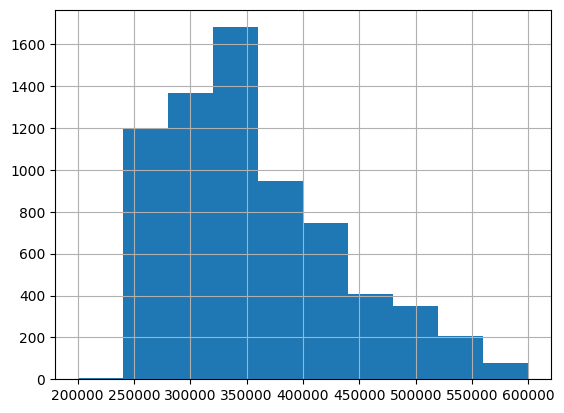

In [ ]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

In [ ]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [ ]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [ ]:
# 車保有率
print(all_df["CarHolder"].value_counts())

CarHolder
0    4408
1    2570
Name: count, dtype: int64


In [ ]:
# 子供の数
print(all_df["NumofChild"].value_counts())

NumofChild
0    5015
1    1347
2     571
3      45
Name: count, dtype: int64


In [ ]:
# 婚姻歴

# 特徴量を追加する
all_df["Family"] = 0
all_df["Single"] = 0
all_df["Divorce"] = 0

# one-hot化して追加する
all_df.loc[all_df["Married"]=="Married","Family"] = 1
all_df.loc[all_df["Married"]=="Single","Single"] = 1
all_df.loc[all_df["Married"]=="Divorce","Divorce"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Married", axis=1)

print(all_df["Family"].value_counts())
print(all_df["Single"].value_counts())
print(all_df["Divorce"].value_counts())

Family
0    4132
1    2846
Name: count, dtype: int64
Single
0    4534
1    2444
Name: count, dtype: int64
Divorce
0    5290
1    1688
Name: count, dtype: int64


In [ ]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch', 'Male',
       'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'SmallBusiness', 'Salaried', 'LargeBusiness', 'CarHolder', 'NumofChild',
       'Family', 'Single', 'Divorce'],
      dtype='object')

In [ ]:
# 順番を整列させる
col = ['id', 'Age', "CompanyInvited", 'CityTier', 'DurationOfPitch',
       'SmallBusiness', 'Salaried', 'LargeBusiness',
       'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', "CarHolder",
       "NumofChild", 'Family', 'Single', 'Divorce',
       'ProdTaken']

all_df = all_df.reindex(columns=col)

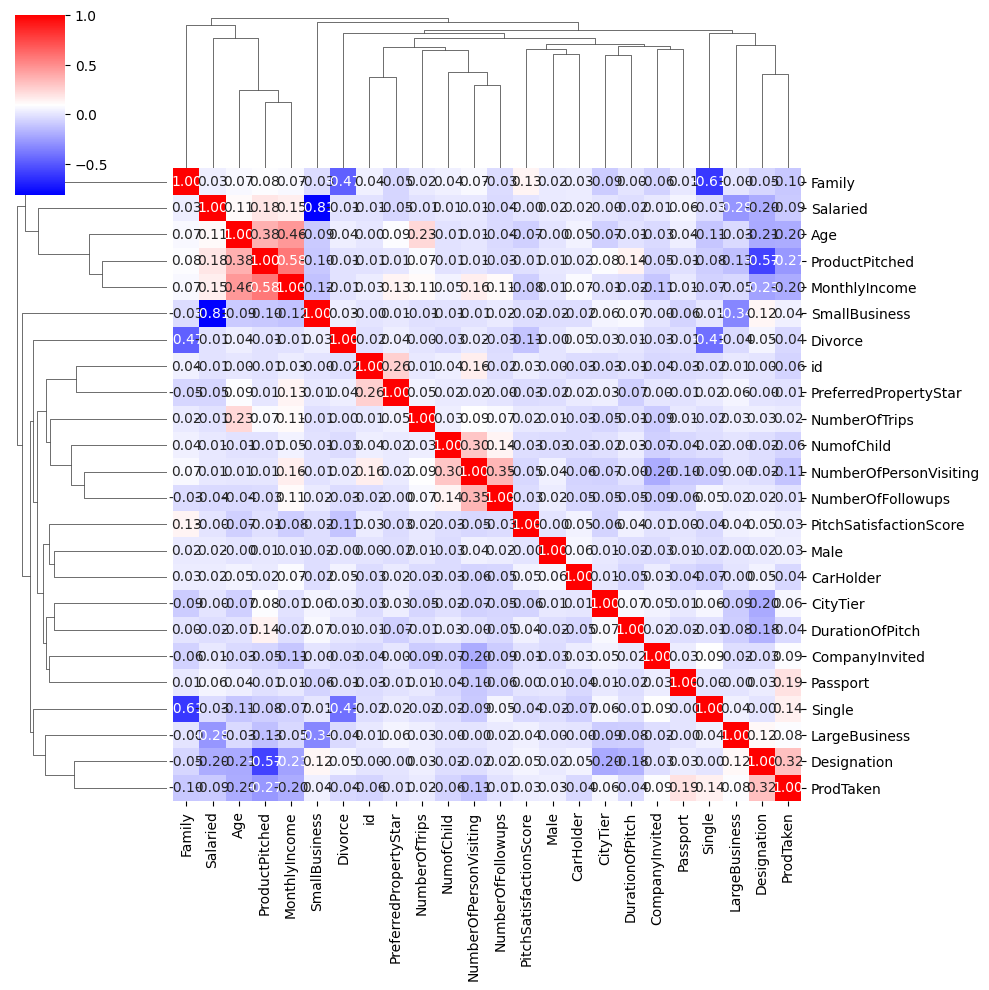

In [ ]:
# 相関係数を確認する
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [ ]:
# "Salaried" と "SmallBusiness" が0.6 超えるため、サラリーマンかそうでないかに分ける
all_df = all_df.drop("SmallBusiness", axis=1)
all_df = all_df.drop("LargeBusiness", axis=1)

In [ ]:
# "Family" と "Single" が0.6 超えるため、独身かそうでないかに分ける
all_df = all_df.drop("Family", axis=1)
all_df = all_df.drop("Divorce", axis=1)

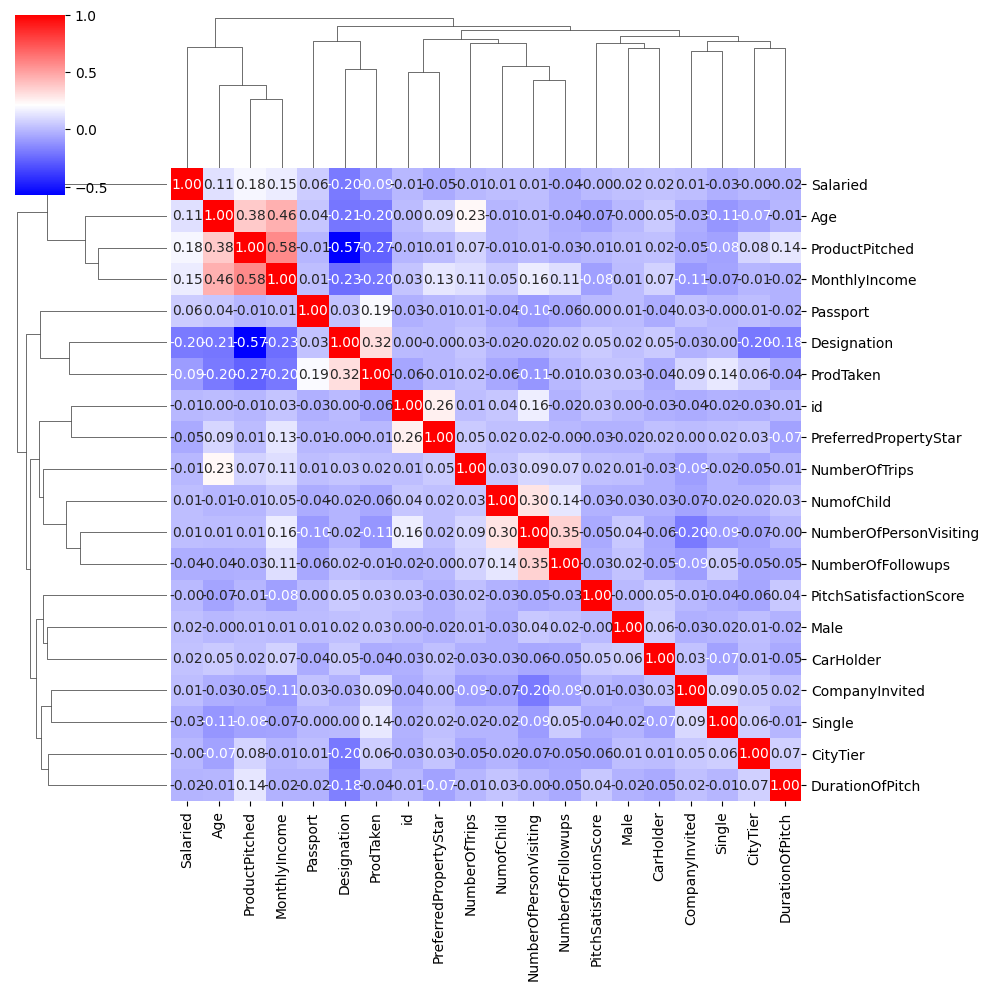

In [ ]:
# 相関係数がすべて0.6未満に収まったので次のステップに進む
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# 特徴量エンジニアリング

In [ ]:
plus = all_df[all_df["ProdTaken"]==1] # 正例
minus = all_df[all_df["ProdTaken"]==0]  # 負例
train = pd.concat([plus,minus])
# 全体数の比
print("正例：", len(plus))
print("負例：", len(minus))
print("比率：", len(minus)/len(plus))

正例： 497
負例： 2992
比率： 6.020120724346077


In [ ]:
train.groupby("ProdTaken").mean()

,id,Age,CompanyInvited,CityTier,DurationOfPitch,Salaried,Male,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,CarHolder,NumofChild,Single
ProdTaken,,,,,,,,,,,,,,,,,,,
0.0,1769.117313,40.188503,0.352273,1.680816,0.953209,0.420455,0.141711,2.428142,3.674465,2.382687,1.442513,1.414773,0.078543,2.500000,2.629011,361609.074198,0.384693,0.384358,0.323529
1.0,1592.790744,34.625755,0.472837,1.794769,0.863179,0.287726,0.17505,2.193159,3.657948,1.519115,1.432596,1.454728,0.247485,2.597586,4.136821,318393.682093,0.323944,0.279678,0.521127


In [ ]:
# パスポート所持率が高い
# 若い(34.6歳 VS 40.2歳)、事業主(28.8% VS 42.0%)、パスポート(24.7% VS 7.9%)、月給(31.8万 VS 36.2万)、独身(52.1% VS 32.4%)
data1 = train.loc[train["ProdTaken"]==1].mean()
data0 = train.loc[train["ProdTaken"]==0].mean()
data0 = data0.drop("ProdTaken", axis=0)
data1 = data1.drop("ProdTaken", axis=0)
print(data1/data0)

id                        0.900331
Age                       0.861584
CompanyInvited            1.342247
CityTier                  1.067796
DurationOfPitch           0.905551
Salaried                  0.684322
Male                      1.235261
NumberOfPersonVisiting    0.903225
NumberOfFollowups         0.995505
ProductPitched            0.637564
PreferredPropertyStar     0.993125
NumberOfTrips             1.028242
Passport                  3.150957
PitchSatisfactionScore    1.039034
Designation               1.573528
MonthlyIncome             0.880491
CarHolder                 0.842085
NumofChild                0.727649
Single                    1.610755
dtype: object


# 学習準備

In [ ]:
#-------------------------------------------------------------------------------------------
# カテゴリ列 x 13
# CompanyInvited, CityTier, DurationOfPitch, Salaried, Male, ProductPitched, PreferredPropertyStar,
# NumberOfTrips, Passport, PitchSatisfactionScore, Designation, CarHolder, Single
# 数値列 x 5
# Age, NumberOfPersonVisiting, NumberOfFollowups, MonthlyIncome, NumofChild
#-------------------------------------------------------------------------------------------
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken'],
      dtype='object')

In [ ]:
# まずはseed複数のスコア平均を取る環境を作ること

In [ ]:
# クロス特徴量の追加
# 「役職」x「商品ランク」
all_df["Designation_ProductPitched"] = all_df["Designation"] * all_df["ProductPitched"]
# 「パスポート」x「独身」
all_df["Passport_Single"] = all_df["Passport"] * all_df["Single"]

In [ ]:
# 「年齢」x「サラリーマン」
# all_df["Age_Salaried"] = all_df["Age"] * all_df["Salaried"]
# 「年齢」x「満足度」
all_df["Age_PitchSatisfactionScore"] = all_df["Age"] * all_df["PitchSatisfactionScore"]
# 「年齢」x「車所有」
all_df["Age_CarHolder"] = all_df["Age"] * all_df["CarHolder"]

In [ ]:
all_df = all_df.drop("Age_Salaried", axis=1)

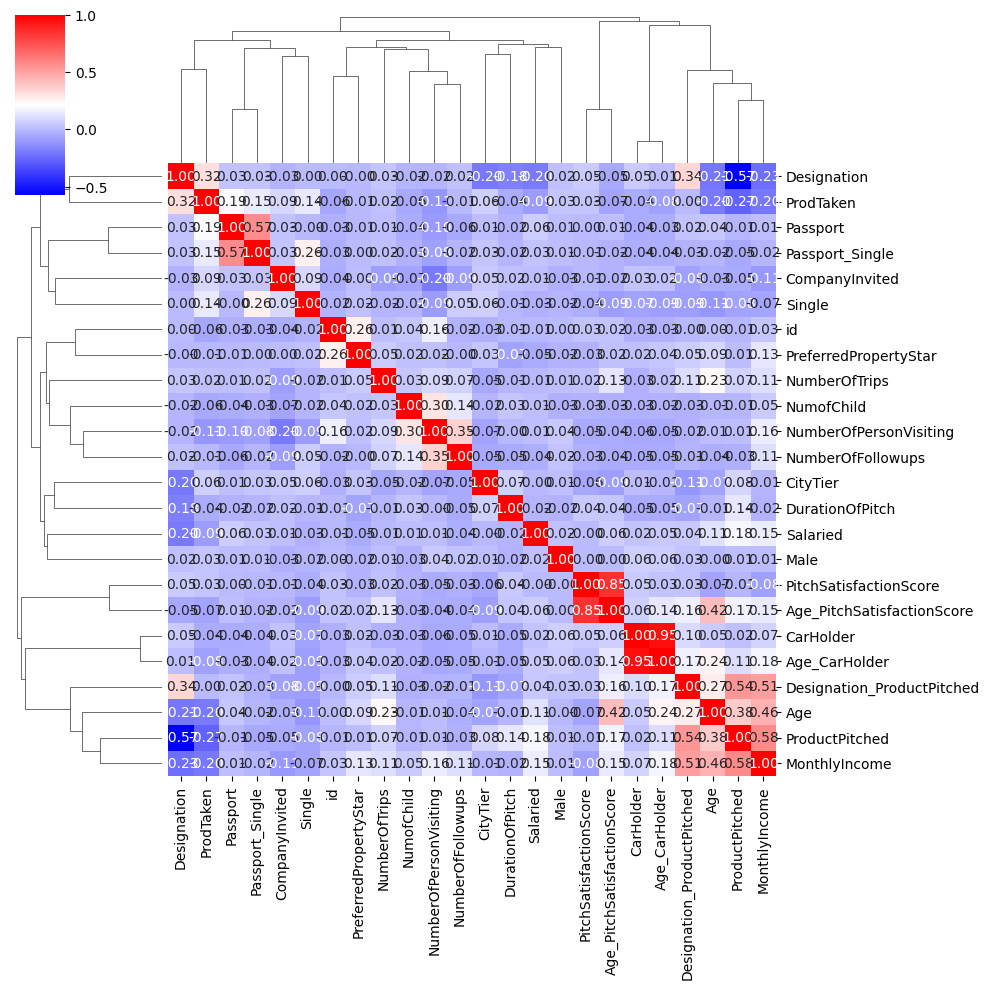

In [ ]:
# 相関係数の確認OK
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [ ]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken', 'Designation_ProductPitched',
       'Passport_Single', 'Age_PitchSatisfactionScore', 'Age_CarHolder'],
      dtype='object')

In [ ]:
# 順番を整列させる
col = ['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken', 'Designation_ProductPitched',
       'Passport_Single', 'Age_PitchSatisfactionScore', 'Age_CarHolder']

# col = ['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
#        'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
#        'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
#        'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
#        'NumofChild', 'Single', 'ProdTaken']

all_df = all_df.reindex(columns=col)

In [ ]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken', 'Designation_ProductPitched',
       'Passport_Single', 'Age_PitchSatisfactionScore', 'Age_CarHolder'],
      dtype='object')

# ここから学習作業

In [ ]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [ ]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)
print(CATS)

[]


In [ ]:
# オブジェクト型はint型に変換する
all_df[CATS] = all_df[CATS].astype(int)

In [ ]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [ ]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

def objective(trial):

  lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'n_estimators': 3000,
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'num_leaves': trial.suggest_int('num_leaves', 16, 256),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),

    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

  # 複数シードの平均を取る
  seed = [0, 42, 2025]
  FOLDS = 5 # 分割数
  oof_score = np.zeros(len(seed))

  # SEEDごとのスコアを出す
  for j, seed in enumerate(seed):

    print("#"*25)
    print(f"### seed =  {seed}")
    print("#"*25)

    oof_lgb = np.zeros(len(train))

    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

    # 各FOLDのスコアを出す
    for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

      print("#"*25)
      print(f"### Fold {i+1}")
      print("#"*25)

      # インデックスに割り振る
      x_train = train.loc[train_index, FEATURES].copy()
      y_train = train.loc[train_index, TARGET]
      x_valid = train.loc[test_index, FEATURES].copy()
      y_valid = train.loc[test_index, TARGET]

      # データセット作成
      lgb_train = lgb.Dataset(x_train, y_train)
      lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

      # 学習
      model_lgb = lgb.train(lgbm_params,
                            lgb_train,
                            num_boost_round = 2000,
                            valid_sets = [lgb_train, lgb_eval],
                            valid_names = ["train", "valid"],
                            callbacks = [
                                lgb.early_stopping(stopping_rounds=100, verbose=False),
                                lgb.log_evaluation(100),])

      # valid予測
      oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    # AUCの算出
    oof_score[j] = roc_auc_score(train[TARGET],oof_lgb)

  score = np.mean(oof_score)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-05-28 12:37:19,732] A new study created in memory with name: no-name-07a340ae-c851-4a7f-9d13-d176ed3899a1
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.973043	valid's auc: 0.831137
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.975862	valid's auc: 0.79286
[200]	train's auc: 0.990755	valid's auc: 0.794164
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.970623	valid's auc: 0.79685
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.970538	valid's auc: 0.832414
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.972487	valid's auc: 0.79521
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.972976	valid's auc: 0.809532
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.97169	valid's auc: 0.826338
[200]	train's auc: 0.989106	valid's auc: 0.822926
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.972909	valid's auc: 0.792685
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.971533	valid's auc: 0.812802
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.974394	valid's auc: 0.794179
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.973818	valid's auc: 0.806923
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.973185	valid's auc: 0.851221
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.971734	valid's auc: 0.799126
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.973534	valid's auc: 0.768065
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.971654	valid's auc: 0.819398


[I 2025-05-28 12:37:31,101] Trial 0 finished with value: 0.7987012987012987 and parameters: {'feature_fraction': 0.6146940658018503, 'num_leaves': 91, 'bagging_fraction': 0.916393224077229, 'bagging_freq': 7, 'lambda_l1': 0.024502735387993992, 'lambda_l2': 3.8696049731246844e-06, 'min_data_in_leaf': 13}. Best is trial 0 with value: 0.7987012987012987.


[200]	train's auc: 0.989064	valid's auc: 0.819702
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.825188	valid's auc: 0.835167


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.839985	valid's auc: 0.8475
[300]	train's auc: 0.850631	valid's auc: 0.852048
[400]	train's auc: 0.860222	valid's auc: 0.854967
[500]	train's auc: 0.868019	valid's auc: 0.854381
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.829325	valid's auc: 0.806881
[200]	train's auc: 0.846256	valid's auc: 0.818261
[300]	train's auc: 0.858401	valid's auc: 0.822023
[400]	train's auc: 0.866772	valid's auc: 0.823161
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832757	valid's auc: 0.784902
[200]	train's auc: 0.849918	valid's auc: 0.791032
[300]	train's auc: 0.858381	valid's auc: 0.801445
[400]	train's auc: 0.865655	valid's auc: 0.805501
[500]	train's auc: 0.871959	valid's auc: 0.809244
[600]	train's auc: 0.877462	valid's auc: 0.810964
[700]	train's auc: 0.882852	valid's auc: 0.81147
[800]	train's auc: 0.88677	valid's auc: 0.811015
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.826813	valid's auc: 0.808941
[200]	train's auc: 0.843377	valid's auc: 0.81948
[300]	train's auc: 0.854517	valid's auc: 0.82857
[400]	train's auc: 0.861596	valid's auc: 0.833139
[500]	train's auc: 0.867754	valid's auc: 0.836529
[600]	train's auc: 0.873561	valid's auc: 0.837203
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835884	valid's auc: 0.797177
[200]	train's auc: 0.851757	valid's auc: 0.80814
[300]	train's auc: 0.860695	valid's auc: 0.810243
[400]	train's auc: 0.868661	valid's auc: 0.811881
[500]	train's auc: 0.87487	valid's auc: 0.811864
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.826983	valid's auc: 0.822082


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.844023	valid's auc: 0.833311
[300]	train's auc: 0.855163	valid's auc: 0.837023
[400]	train's auc: 0.863081	valid's auc: 0.83811
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.827965	valid's auc: 0.807391
[200]	train's auc: 0.841774	valid's auc: 0.824858
[300]	train's auc: 0.851129	valid's auc: 0.832057
[400]	train's auc: 0.860353	valid's auc: 0.835786
[500]	train's auc: 0.867105	valid's auc: 0.837525
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835311	valid's auc: 0.784725
[200]	train's auc: 0.849001	valid's auc: 0.800863
[300]	train's auc: 0.859473	valid's auc: 0.803899
[400]	train's auc: 0.867799	valid's auc: 0.806175
[500]	train's auc: 0.87445	valid's auc: 0.807002
[600]	train's auc: 0.879929	valid's auc: 0.808317
#########################
### Fold 4
#########################
[100]	train's auc: 0.829751	valid's auc: 0.822912


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.845801	valid's auc: 0.825357
[300]	train's auc: 0.8558	valid's auc: 0.826917
[400]	train's auc: 0.863412	valid's auc: 0.827726
[500]	train's auc: 0.870423	valid's auc: 0.829801
#########################
### Fold 5
#########################
[100]	train's auc: 0.831471	valid's auc: 0.79722


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846242	valid's auc: 0.808284
[300]	train's auc: 0.857592	valid's auc: 0.816324
[400]	train's auc: 0.866197	valid's auc: 0.820732
[500]	train's auc: 0.872677	valid's auc: 0.821982
[600]	train's auc: 0.877459	valid's auc: 0.823232
[700]	train's auc: 0.882215	valid's auc: 0.823874
[800]	train's auc: 0.886823	valid's auc: 0.82384
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.829706	valid's auc: 0.793278


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846558	valid's auc: 0.812625
[300]	train's auc: 0.857052	valid's auc: 0.819632
[400]	train's auc: 0.864565	valid's auc: 0.824298
[500]	train's auc: 0.871126	valid's auc: 0.826171
[600]	train's auc: 0.877108	valid's auc: 0.826923
[700]	train's auc: 0.881675	valid's auc: 0.826806
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.82213	valid's auc: 0.846054
[200]	train's auc: 0.839969	valid's auc: 0.856321
[300]	train's auc: 0.848955	valid's auc: 0.858896
[400]	train's auc: 0.856668	valid's auc: 0.860602
[500]	train's auc: 0.863536	valid's auc: 0.861522
[600]	train's auc: 0.869164	valid's auc: 0.862241
#########################
### Fold 3
#########################
[100]	train's auc: 0.831937	valid's auc: 0.789894


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849393	valid's auc: 0.806226
[300]	train's auc: 0.859816	valid's auc: 0.811335
[400]	train's auc: 0.867939	valid's auc: 0.816259
[500]	train's auc: 0.874289	valid's auc: 0.817743
[600]	train's auc: 0.879423	valid's auc: 0.817339
#########################
### Fold 4
#########################
[100]	train's auc: 0.833865	valid's auc: 0.774135


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849716	valid's auc: 0.781766
[300]	train's auc: 0.862078	valid's auc: 0.790678
[400]	train's auc: 0.87181	valid's auc: 0.794641
[500]	train's auc: 0.878275	valid's auc: 0.795939
[600]	train's auc: 0.883893	valid's auc: 0.797069
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.827684	valid's auc: 0.819086
[200]	train's auc: 0.845636	valid's auc: 0.826974
[300]	train's auc: 0.85507	valid's auc: 0.828384
[400]	train's auc: 0.86295	valid's auc: 0.828925


[I 2025-05-28 12:37:44,737] Trial 1 finished with value: 0.8261433574710294 and parameters: {'feature_fraction': 0.8551461420606381, 'num_leaves': 25, 'bagging_fraction': 0.7285451503886118, 'bagging_freq': 4, 'lambda_l1': 1.775136664124044, 'lambda_l2': 8.941318089891473, 'min_data_in_leaf': 97}. Best is trial 1 with value: 0.8261433574710294.


[500]	train's auc: 0.869898	valid's auc: 0.830377
[600]	train's auc: 0.875797	valid's auc: 0.829702
#########################
### seed =  0
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.851207	valid's auc: 0.848629
#########################
### Fold 2
#########################
[100]	train's auc: 0.860674	valid's auc: 0.80995


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880615	valid's auc: 0.813294
[300]	train's auc: 0.899582	valid's auc: 0.810334
#########################
### Fold 3
#########################
[100]	train's auc: 0.85796	valid's auc: 0.795054


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875736	valid's auc: 0.8026
[300]	train's auc: 0.892781	valid's auc: 0.805231
[400]	train's auc: 0.907977	valid's auc: 0.805821
[500]	train's auc: 0.920079	valid's auc: 0.80604
#########################
### Fold 4
#########################
[100]	train's auc: 0.85225	valid's auc: 0.829691


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870758	valid's auc: 0.837912
[300]	train's auc: 0.889448	valid's auc: 0.840913
[400]	train's auc: 0.904188	valid's auc: 0.840188
#########################
### Fold 5
#########################
[100]	train's auc: 0.862484	valid's auc: 0.793808


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883155	valid's auc: 0.801493
[300]	train's auc: 0.90022	valid's auc: 0.803165
[400]	train's auc: 0.914684	valid's auc: 0.803672
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855011	valid's auc: 0.825092
[200]	train's auc: 0.874808	valid's auc: 0.824064
#########################
### Fold 2
#########################
[100]	train's auc: 0.855833	valid's auc: 0.820493


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874608	valid's auc: 0.830084
[300]	train's auc: 0.891675	valid's auc: 0.836171
[400]	train's auc: 0.907528	valid's auc: 0.837258
#########################
### Fold 3
#########################
[100]	train's auc: 0.860168	valid's auc: 0.79873


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879086	valid's auc: 0.801032
[300]	train's auc: 0.896726	valid's auc: 0.802718
#########################
### Fold 4
#########################
[100]	train's auc: 0.855468	valid's auc: 0.816335


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.857384	valid's auc: 0.815369


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876241	valid's auc: 0.813114
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.855365	valid's auc: 0.808219


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876652	valid's auc: 0.810585
[300]	train's auc: 0.892037	valid's auc: 0.813913
[400]	train's auc: 0.907011	valid's auc: 0.817023
[500]	train's auc: 0.919675	valid's auc: 0.81796
[600]	train's auc: 0.931629	valid's auc: 0.816555
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848716	valid's auc: 0.8601
[200]	train's auc: 0.869819	valid's auc: 0.857124
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858189	valid's auc: 0.807651
[200]	train's auc: 0.876421	valid's auc: 0.810054
[300]	train's auc: 0.894883	valid's auc: 0.810526
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86144	valid's auc: 0.78744
[200]	train's auc: 0.880083	valid's auc: 0.784565
#########################
### Fold 5
#########################
[100]	train's auc: 0.855404	valid's auc: 0.822742


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 12:37:54,866] Trial 2 finished with value: 0.8109170845034557 and parameters: {'feature_fraction': 0.9039422212962562, 'num_leaves': 227, 'bagging_fraction': 0.9891128822996935, 'bagging_freq': 5, 'lambda_l1': 0.009263866444556986, 'lambda_l2': 1.2200531255830125, 'min_data_in_leaf': 99}. Best is trial 1 with value: 0.8261433574710294.


[200]	train's auc: 0.872458	valid's auc: 0.827557
[300]	train's auc: 0.891481	valid's auc: 0.826357
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853761	valid's auc: 0.843512
[200]	train's auc: 0.872954	valid's auc: 0.850284
[300]	train's auc: 0.888933	valid's auc: 0.847793
#########################
### Fold 2
#########################
[100]	train's auc: 0.862484	valid's auc: 0.815719


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################
[100]	train's auc: 0.860652	valid's auc: 0.809295


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87612	valid's auc: 0.81346
[300]	train's auc: 0.889683	valid's auc: 0.815602
[400]	train's auc: 0.902615	valid's auc: 0.818823
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854529	valid's auc: 0.83002
[200]	train's auc: 0.871648	valid's auc: 0.839176
[300]	train's auc: 0.887433	valid's auc: 0.843628
[400]	train's auc: 0.899375	valid's auc: 0.844573
#########################
### Fold 5
#########################
[100]	train's auc: 0.860747	valid's auc: 0.80754
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85717	valid's auc: 0.831689
#########################
### Fold 2
#########################
[100]	train's auc: 0.855676	valid's auc: 0.83199


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872334	valid's auc: 0.838829
[300]	train's auc: 0.886685	valid's auc: 0.842191
[400]	train's auc: 0.900174	valid's auc: 0.842492
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863452	valid's auc: 0.79825
[200]	train's auc: 0.879683	valid's auc: 0.803309
[300]	train's auc: 0.892894	valid's auc: 0.804927
[400]	train's auc: 0.90553	valid's auc: 0.806968
#########################
### Fold 4
#########################
[100]	train's auc: 0.858772	valid's auc: 0.827591


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876974	valid's auc: 0.829581
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861644	valid's auc: 0.808486
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.857464	valid's auc: 0.814799
[200]	train's auc: 0.875781	valid's auc: 0.825134
[300]	train's auc: 0.890615	valid's auc: 0.82597
[400]	train's auc: 0.903366	valid's auc: 0.828779
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852361	valid's auc: 0.855318
[200]	train's auc: 0.869723	valid's auc: 0.861789
[300]	train's auc: 0.88426	valid's auc: 0.863043
[400]	train's auc: 0.897841	valid's auc: 0.863679
[500]	train's auc: 0.909632	valid's auc: 0.862759
#########################
### Fold 3
#########################
[100]	train's auc: 0.862644	valid's auc: 0.813679


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877503	valid's auc: 0.817878
[300]	train's auc: 0.891908	valid's auc: 0.818637
[400]	train's auc: 0.904213	valid's auc: 0.815501
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866102	valid's auc: 0.786327
[200]	train's auc: 0.882756	valid's auc: 0.791909
[300]	train's auc: 0.897556	valid's auc: 0.791943
#########################
### Fold 5
#########################
[100]	train's auc: 0.859618	valid's auc: 0.829465


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 12:38:04,215] Trial 3 finished with value: 0.8067753669969907 and parameters: {'feature_fraction': 0.6571688279664886, 'num_leaves': 59, 'bagging_fraction': 0.6495806844082886, 'bagging_freq': 1, 'lambda_l1': 0.01195734360316718, 'lambda_l2': 0.15325451917121755, 'min_data_in_leaf': 75}. Best is trial 1 with value: 0.8261433574710294.


[200]	train's auc: 0.874679	valid's auc: 0.829381
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.923068	valid's auc: 0.836329
[200]	train's auc: 0.956856	valid's auc: 0.831488
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.9311	valid's auc: 0.797584
[200]	train's auc: 0.962631	valid's auc: 0.79791
[300]	train's auc: 0.980477	valid's auc: 0.795569
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.92093	valid's auc: 0.786622
[200]	train's auc: 0.956635	valid's auc: 0.789498
[300]	train's auc: 0.977645	valid's auc: 0.791656
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.924042	valid's auc: 0.832591
[200]	train's auc: 0.955423	valid's auc: 0.833595
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.9315	valid's auc: 0.798343
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.925244	valid's auc: 0.809632
[200]	train's auc: 0.957734	valid's auc: 0.811856
[300]	train's auc: 0.977912	valid's auc: 0.811505
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.927206	valid's auc: 0.819398
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.929524	valid's auc: 0.78287
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.923911	valid's auc: 0.808148
[200]	train's auc: 0.956194	valid's auc: 0.810088
[300]	train's auc: 0.977135	valid's auc: 0.809784
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.932975	valid's auc: 0.79548
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.926367	valid's auc: 0.8001
[200]	train's auc: 0.957542	valid's auc: 0.805502
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.92589	valid's auc: 0.847943
[200]	train's auc: 0.956577	valid's auc: 0.851087
[300]	train's auc: 0.976944	valid's auc: 0.852074
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.924428	valid's auc: 0.796142
[200]	train's auc: 0.957349	valid's auc: 0.798587
[300]	train's auc: 0.977763	valid's auc: 0.795821
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.931687	valid's auc: 0.76879
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.919756	valid's auc: 0.818418


[I 2025-05-28 12:38:15,908] Trial 4 finished with value: 0.796581628810295 and parameters: {'feature_fraction': 0.9690343640850153, 'num_leaves': 43, 'bagging_fraction': 0.9281255099507228, 'bagging_freq': 5, 'lambda_l1': 1.478877427930524e-07, 'lambda_l2': 3.132016445354724e-05, 'min_data_in_leaf': 16}. Best is trial 1 with value: 0.8261433574710294.


[200]	train's auc: 0.95472	valid's auc: 0.8208
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848668	valid's auc: 0.847935
#########################
### Fold 2
#########################
[100]	train's auc: 0.854814	valid's auc: 0.815393


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871184	valid's auc: 0.816254
#########################
### Fold 3
#########################
[100]	train's auc: 0.853743	valid's auc: 0.79599


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868532	valid's auc: 0.803654
[300]	train's auc: 0.881498	valid's auc: 0.807389
[400]	train's auc: 0.893689	valid's auc: 0.808654
[500]	train's auc: 0.904203	valid's auc: 0.810003
[600]	train's auc: 0.91336	valid's auc: 0.811049
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84919	valid's auc: 0.820079
[200]	train's auc: 0.863679	valid's auc: 0.829834
[300]	train's auc: 0.877612	valid's auc: 0.83287
[400]	train's auc: 0.890452	valid's auc: 0.835079
[500]	train's auc: 0.90094	valid's auc: 0.836731
[600]	train's auc: 0.910496	valid's auc: 0.836208
#########################
### Fold 5
#########################
[100]	train's auc: 0.855725	valid's auc: 0.801071
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85195	valid's auc: 0.827149
#########################
### Fold 2
#########################
[100]	train's auc: 0.844841	valid's auc: 0.821279


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860824	valid's auc: 0.831505
[300]	train's auc: 0.875799	valid's auc: 0.837375
[400]	train's auc: 0.889465	valid's auc: 0.838746
[500]	train's auc: 0.901179	valid's auc: 0.839197
#########################
### Fold 3
#########################
[100]	train's auc: 0.858831	valid's auc: 0.796521


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87319	valid's auc: 0.800492
[300]	train's auc: 0.886734	valid's auc: 0.801707
[400]	train's auc: 0.899201	valid's auc: 0.802364
[500]	train's auc: 0.908667	valid's auc: 0.802954
[600]	train's auc: 0.917613	valid's auc: 0.803072
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851495	valid's auc: 0.824278
[200]	train's auc: 0.868554	valid's auc: 0.825635
[300]	train's auc: 0.882227	valid's auc: 0.827794
[400]	train's auc: 0.894878	valid's auc: 0.828856
[500]	train's auc: 0.905541	valid's auc: 0.828974
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853944	valid's auc: 0.807591
[200]	train's auc: 0.870099	valid's auc: 0.811256
[300]	train's auc: 0.884686	valid's auc: 0.815462
[400]	train's auc: 0.896748	valid's auc: 0.818874
[500]	train's auc: 0.90685	valid's auc: 0.819685
[600]	train's auc: 0.916465	valid's auc: 0.819263
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.852871	valid's auc: 0.808712


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869863	valid's auc: 0.815819
[300]	train's auc: 0.884276	valid's auc: 0.818127
[400]	train's auc: 0.89541	valid's auc: 0.81995
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848184	valid's auc: 0.856421
[200]	train's auc: 0.862028	valid's auc: 0.857726
[300]	train's auc: 0.87651	valid's auc: 0.861137
[400]	train's auc: 0.889515	valid's auc: 0.861722
#########################
### Fold 3
#########################
[100]	train's auc: 0.853798	valid's auc: 0.804042


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867951	valid's auc: 0.810678
[300]	train's auc: 0.881684	valid's auc: 0.814725
[400]	train's auc: 0.894066	valid's auc: 0.815045
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854804	valid's auc: 0.779439
[200]	train's auc: 0.873547	valid's auc: 0.782769
[300]	train's auc: 0.889094	valid's auc: 0.78486
[400]	train's auc: 0.901068	valid's auc: 0.786445
[500]	train's auc: 0.911361	valid's auc: 0.786395
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850187	valid's auc: 0.82281
[200]	train's auc: 0.864844	valid's auc: 0.826425
[300]	train's auc: 0.879339	valid's auc: 0.827793
[400]	train's auc: 0.892025	valid's auc: 0.829178


[I 2025-05-28 12:38:29,172] Trial 5 finished with value: 0.8053371476631627 and parameters: {'feature_fraction': 0.6737630028990389, 'num_leaves': 90, 'bagging_fraction': 0.9051595070749515, 'bagging_freq': 7, 'lambda_l1': 0.3290284758883154, 'lambda_l2': 7.673987340911803, 'min_data_in_leaf': 57}. Best is trial 1 with value: 0.8261433574710294.


[500]	train's auc: 0.90364	valid's auc: 0.828046
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868198	valid's auc: 0.845552
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875001	valid's auc: 0.814298
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87132	valid's auc: 0.811942
#########################
### Fold 4
#########################
[100]	train's auc: 0.866801	valid's auc: 0.832448


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883936	valid's auc: 0.836647
[300]	train's auc: 0.898561	valid's auc: 0.838974
#########################
### Fold 5
#########################
[100]	train's auc: 0.877117	valid's auc: 0.806679


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.870544	valid's auc: 0.830351


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################
[100]	train's auc: 0.866791	valid's auc: 0.839983


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885182	valid's auc: 0.842793
[300]	train's auc: 0.901893	valid's auc: 0.843294
#########################
### Fold 3
#########################
[100]	train's auc: 0.875455	valid's auc: 0.795467


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892274	valid's auc: 0.80083
[300]	train's auc: 0.907405	valid's auc: 0.802853
#########################
### Fold 4
#########################
[100]	train's auc: 0.873008	valid's auc: 0.83088


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890316	valid's auc: 0.834185
[300]	train's auc: 0.905257	valid's auc: 0.83604
[400]	train's auc: 0.918428	valid's auc: 0.834421
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8749	valid's auc: 0.810158
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.871561	valid's auc: 0.820084
#########################
### Fold 2
#########################
[100]	train's auc: 0.868052	valid's auc: 0.860853


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885134	valid's auc: 0.861605
[300]	train's auc: 0.901535	valid's auc: 0.862993
[400]	train's auc: 0.915466	valid's auc: 0.862993
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871856	valid's auc: 0.815484
[200]	train's auc: 0.888315	valid's auc: 0.818452
[300]	train's auc: 0.904721	valid's auc: 0.820054
#########################
### Fold 4
#########################
[100]	train's auc: 0.87631	valid's auc: 0.786192


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893795	valid's auc: 0.789278
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868185	valid's auc: 0.831289
[200]	train's auc: 0.886198	valid's auc: 0.832624
[300]	train's auc: 0.903105	valid's auc: 0.833806


[I 2025-05-28 12:38:37,495] Trial 6 finished with value: 0.8045639030259991 and parameters: {'feature_fraction': 0.5002222035341553, 'num_leaves': 146, 'bagging_fraction': 0.6411957291715673, 'bagging_freq': 2, 'lambda_l1': 0.6027698161102448, 'lambda_l2': 8.927362025065341e-05, 'min_data_in_leaf': 43}. Best is trial 1 with value: 0.8261433574710294.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.858574	valid's auc: 0.847383
[200]	train's auc: 0.87631	valid's auc: 0.85204
[300]	train's auc: 0.892426	valid's auc: 0.850217
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864632	valid's auc: 0.81908
[200]	train's auc: 0.881604	valid's auc: 0.820652
#########################
### Fold 3
#########################
[100]	train's auc: 0.863829	valid's auc: 0.801985


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876819	valid's auc: 0.80502
[300]	train's auc: 0.891096	valid's auc: 0.808823
[400]	train's auc: 0.903965	valid's auc: 0.811285
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85783	valid's auc: 0.819936
[200]	train's auc: 0.874702	valid's auc: 0.828637
[300]	train's auc: 0.889977	valid's auc: 0.83373
[400]	train's auc: 0.903435	valid's auc: 0.835281
[500]	train's auc: 0.915011	valid's auc: 0.836445
[600]	train's auc: 0.92524	valid's auc: 0.836647
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865893	valid's auc: 0.805986
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859485	valid's auc: 0.829147
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854037	valid's auc: 0.823144
[200]	train's auc: 0.873052	valid's auc: 0.834749
[300]	train's auc: 0.888374	valid's auc: 0.836522
[400]	train's auc: 0.902277	valid's auc: 0.83811
[500]	train's auc: 0.914012	valid's auc: 0.837542
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866753	valid's auc: 0.795602
[200]	train's auc: 0.883003	valid's auc: 0.800037
[300]	train's auc: 0.897056	valid's auc: 0.80147
[400]	train's auc: 0.910449	valid's auc: 0.801943
#########################
### Fold 4
#########################
[100]	train's auc: 0.861321	valid's auc: 0.828881


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880036	valid's auc: 0.83088
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864467	valid's auc: 0.80222
[200]	train's auc: 0.880782	valid's auc: 0.80651
[300]	train's auc: 0.896174	valid's auc: 0.809888
[400]	train's auc: 0.908969	valid's auc: 0.813537
[500]	train's auc: 0.920442	valid's auc: 0.815834
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.863604	valid's auc: 0.810978


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################
[100]	train's auc: 0.857566	valid's auc: 0.85913


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874465	valid's auc: 0.859732
[300]	train's auc: 0.890903	valid's auc: 0.860535
#########################
### Fold 3
#########################
[100]	train's auc: 0.862362	valid's auc: 0.805905


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878611	valid's auc: 0.813477
[300]	train's auc: 0.893199	valid's auc: 0.816765
[400]	train's auc: 0.90614	valid's auc: 0.817507
#########################
### Fold 4
#########################
[100]	train's auc: 0.86673	valid's auc: 0.777415


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885391	valid's auc: 0.784017
[300]	train's auc: 0.899995	valid's auc: 0.784827
[400]	train's auc: 0.913347	valid's auc: 0.787086
[500]	train's auc: 0.9235	valid's auc: 0.786226
#########################
### Fold 5
#########################
[100]	train's auc: 0.860124	valid's auc: 0.822742


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 12:38:50,849] Trial 7 finished with value: 0.8037314797878178 and parameters: {'feature_fraction': 0.572026288111193, 'num_leaves': 239, 'bagging_fraction': 0.785984908873727, 'bagging_freq': 7, 'lambda_l1': 0.4464671401707418, 'lambda_l2': 6.5018710068725944, 'min_data_in_leaf': 27}. Best is trial 1 with value: 0.8261433574710294.


[200]	train's auc: 0.875071	valid's auc: 0.82531
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852937	valid's auc: 0.848905
[200]	train's auc: 0.872586	valid's auc: 0.853545
#########################
### Fold 2
#########################
[100]	train's auc: 0.861339	valid's auc: 0.812676


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878913	valid's auc: 0.814599
[300]	train's auc: 0.893769	valid's auc: 0.813712
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861777	valid's auc: 0.800669
[200]	train's auc: 0.876684	valid's auc: 0.807507
[300]	train's auc: 0.890037	valid's auc: 0.813612
[400]	train's auc: 0.903018	valid's auc: 0.816681
[500]	train's auc: 0.913049	valid's auc: 0.816833
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85609	valid's auc: 0.83093
[200]	train's auc: 0.87345	valid's auc: 0.840525
[300]	train's auc: 0.888204	valid's auc: 0.841133
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861725	valid's auc: 0.803757
[200]	train's auc: 0.877858	valid's auc: 0.805632
[300]	train's auc: 0.892743	valid's auc: 0.808233
[400]	train's auc: 0.90667	valid's auc: 0.80825
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.855745	valid's auc: 0.836555


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873561	valid's auc: 0.836756
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85441	valid's auc: 0.825067
[200]	train's auc: 0.87177	valid's auc: 0.834565
[300]	train's auc: 0.888271	valid's auc: 0.839214
[400]	train's auc: 0.901132	valid's auc: 0.834649
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860863	valid's auc: 0.797558
[200]	train's auc: 0.877589	valid's auc: 0.80454
[300]	train's auc: 0.893175	valid's auc: 0.80572
[400]	train's auc: 0.905958	valid's auc: 0.805939
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85761	valid's auc: 0.828013
[200]	train's auc: 0.875682	valid's auc: 0.82631
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862578	valid's auc: 0.809162
[200]	train's auc: 0.878424	valid's auc: 0.816746
[300]	train's auc: 0.894099	valid's auc: 0.820259
[400]	train's auc: 0.907047	valid's auc: 0.820192
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.855485	valid's auc: 0.809473


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875398	valid's auc: 0.818294
[300]	train's auc: 0.890297	valid's auc: 0.824064
[400]	train's auc: 0.903016	valid's auc: 0.823495
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849766	valid's auc: 0.854824
[200]	train's auc: 0.868036	valid's auc: 0.858662
#########################
### Fold 3
#########################
[100]	train's auc: 0.86302	valid's auc: 0.810863


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877167	valid's auc: 0.811437
[300]	train's auc: 0.89114	valid's auc: 0.814303
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86121	valid's auc: 0.782483
[200]	train's auc: 0.882639	valid's auc: 0.792145
[300]	train's auc: 0.898314	valid's auc: 0.791774
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 12:38:58,880] Trial 8 finished with value: 0.8215061312617237 and parameters: {'feature_fraction': 0.9757277694244686, 'num_leaves': 42, 'bagging_fraction': 0.5020436955416427, 'bagging_freq': 3, 'lambda_l1': 8.216708513487867e-07, 'lambda_l2': 2.3186633792207935e-07, 'min_data_in_leaf': 63}. Best is trial 1 with value: 0.8261433574710294.


[100]	train's auc: 0.858438	valid's auc: 0.827151
[200]	train's auc: 0.875652	valid's auc: 0.82754
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874661	valid's auc: 0.848721
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873327	valid's auc: 0.814841
[200]	train's auc: 0.895923	valid's auc: 0.820585
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872243	valid's auc: 0.784304
[200]	train's auc: 0.891838	valid's auc: 0.793621
[300]	train's auc: 0.909812	valid's auc: 0.798671
[400]	train's auc: 0.923704	valid's auc: 0.798857
[500]	train's auc: 0.93549	valid's auc: 0.800172
[600]	train's auc: 0.945432	valid's auc: 0.800627
#########################
### Fold 4
#########################
[100]	train's auc: 0.867922	valid's auc: 0.823435


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890545	valid's auc: 0.834438
[300]	train's auc: 0.908089	valid's auc: 0.833999
[400]	train's auc: 0.922548	valid's auc: 0.835534
[500]	train's auc: 0.935411	valid's auc: 0.834623
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875792	valid's auc: 0.802067
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.870702	valid's auc: 0.822416


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.89297	valid's auc: 0.825936
[300]	train's auc: 0.91157	valid's auc: 0.8251
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864571	valid's auc: 0.820351
[200]	train's auc: 0.887967	valid's auc: 0.830334
[300]	train's auc: 0.908518	valid's auc: 0.831204
[400]	train's auc: 0.92424	valid's auc: 0.832057
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877152	valid's auc: 0.793444
[200]	train's auc: 0.898533	valid's auc: 0.801622
[300]	train's auc: 0.916334	valid's auc: 0.803612
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871027	valid's auc: 0.824649
[200]	train's auc: 0.895627	valid's auc: 0.825113
#########################
### Fold 5
#########################
[100]	train's auc: 0.877794	valid's auc: 0.803588


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.898304	valid's auc: 0.805007
[300]	train's auc: 0.915676	valid's auc: 0.812946
[400]	train's auc: 0.929384	valid's auc: 0.814567
[500]	train's auc: 0.940337	valid's auc: 0.815395
[600]	train's auc: 0.949384	valid's auc: 0.816358
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.871252	valid's auc: 0.808177


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894231	valid's auc: 0.812375
[300]	train's auc: 0.912565	valid's auc: 0.812358
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86797	valid's auc: 0.851104
[200]	train's auc: 0.892731	valid's auc: 0.854181
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872961	valid's auc: 0.799514
[200]	train's auc: 0.892447	valid's auc: 0.804405
[300]	train's auc: 0.909994	valid's auc: 0.805838
[400]	train's auc: 0.925002	valid's auc: 0.806226
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87629	valid's auc: 0.784498
[200]	train's auc: 0.901465	valid's auc: 0.78201
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867218	valid's auc: 0.822979
[200]	train's auc: 0.889046	valid's auc: 0.82406
[300]	train's auc: 0.909189	valid's auc: 0.824938


[I 2025-05-28 12:39:15,199] Trial 9 finished with value: 0.8088133300695439 and parameters: {'feature_fraction': 0.9318304547976813, 'num_leaves': 248, 'bagging_fraction': 0.7443609749996761, 'bagging_freq': 3, 'lambda_l1': 2.0546618931479363, 'lambda_l2': 1.276787550799523, 'min_data_in_leaf': 18}. Best is trial 1 with value: 0.8261433574710294.


[400]	train's auc: 0.924328	valid's auc: 0.825698
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849159	valid's auc: 0.842567
[200]	train's auc: 0.870732	valid's auc: 0.849114
[300]	train's auc: 0.888846	valid's auc: 0.84704
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858272	valid's auc: 0.815502
[200]	train's auc: 0.877343	valid's auc: 0.817943
[300]	train's auc: 0.893291	valid's auc: 0.815702
#########################
### Fold 3
#########################
[100]	train's auc: 0.856736	valid's auc: 0.80013


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876078	valid's auc: 0.810307
[300]	train's auc: 0.890131	valid's auc: 0.815652
[400]	train's auc: 0.903369	valid's auc: 0.813932
#########################
### Fold 4
#########################
[100]	train's auc: 0.849442	valid's auc: 0.826748


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871773	valid's auc: 0.8369
[300]	train's auc: 0.887767	valid's auc: 0.838468
[400]	train's auc: 0.900853	valid's auc: 0.841149
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856588	valid's auc: 0.801797
[200]	train's auc: 0.878388	valid's auc: 0.807861
[300]	train's auc: 0.894789	valid's auc: 0.807287
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848834	valid's auc: 0.835502
[200]	train's auc: 0.873187	valid's auc: 0.836254
#########################
### Fold 2
#########################
[100]	train's auc: 0.853183	valid's auc: 0.822007
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856458	valid's auc: 0.79153
#########################
### Fold 4
#########################
[100]	train's auc: 0.856221	valid's auc: 0.821251


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875917	valid's auc: 0.827355
[300]	train's auc: 0.890453	valid's auc: 0.828468
#########################
### Fold 5
#########################
[100]	train's auc: 0.855125	valid's auc: 0.801257
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855266	valid's auc: 0.80602
[200]	train's auc: 0.875058	valid's auc: 0.820585
[300]	train's auc: 0.890619	valid's auc: 0.82393
[400]	train's auc: 0.904484	valid's auc: 0.825702
#########################
### Fold 2
#########################
[100]	train's auc: 0.845314	valid's auc: 0.850217


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868495	valid's auc: 0.860167
[300]	train's auc: 0.884138	valid's auc: 0.859933
#########################
### Fold 3
#########################
[100]	train's auc: 0.855115	valid's auc: 0.802567


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875442	valid's auc: 0.813696
[300]	train's auc: 0.891199	valid's auc: 0.814404
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858315	valid's auc: 0.781791
[200]	train's auc: 0.880409	valid's auc: 0.790729
[300]	train's auc: 0.89717	valid's auc: 0.793106
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854134	valid's auc: 0.82716
[200]	train's auc: 0.871254	valid's auc: 0.83009


[I 2025-05-28 12:39:22,580] Trial 10 finished with value: 0.8125781202365708 and parameters: {'feature_fraction': 0.8272655344789903, 'num_leaves': 158, 'bagging_fraction': 0.7925090741911235, 'bagging_freq': 5, 'lambda_l1': 1.8888598408686155e-05, 'lambda_l2': 0.00813396438547535, 'min_data_in_leaf': 97}. Best is trial 1 with value: 0.8261433574710294.


[300]	train's auc: 0.888887	valid's auc: 0.831306
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847709	valid's auc: 0.842868
[200]	train's auc: 0.864287	valid's auc: 0.85388
[300]	train's auc: 0.879507	valid's auc: 0.854866
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853665	valid's auc: 0.81612
[200]	train's auc: 0.872398	valid's auc: 0.820836
[300]	train's auc: 0.885296	valid's auc: 0.81893
#########################
### Fold 3
#########################
[100]	train's auc: 0.854981	valid's auc: 0.799556


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870905	valid's auc: 0.80744
[300]	train's auc: 0.883117	valid's auc: 0.81491
[400]	train's auc: 0.894518	valid's auc: 0.814641
[500]	train's auc: 0.904442	valid's auc: 0.814303
#########################
### Fold 4
#########################
[100]	train's auc: 0.849836	valid's auc: 0.826681


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866341	valid's auc: 0.837423
[300]	train's auc: 0.879541	valid's auc: 0.84265
#########################
### Fold 5
#########################
[100]	train's auc: 0.854717	valid's auc: 0.803655


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872402	valid's auc: 0.807405
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84867	valid's auc: 0.834933
[200]	train's auc: 0.869022	valid's auc: 0.836656
#########################
### Fold 2
#########################
[100]	train's auc: 0.84873	valid's auc: 0.827258


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865176	valid's auc: 0.837007
[300]	train's auc: 0.87891	valid's auc: 0.840301
#########################
### Fold 3
#########################
[100]	train's auc: 0.854746	valid's auc: 0.793073


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872111	valid's auc: 0.804607
[300]	train's auc: 0.88636	valid's auc: 0.807052
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851605	valid's auc: 0.824522
[200]	train's auc: 0.870144	valid's auc: 0.825838
[300]	train's auc: 0.883373	valid's auc: 0.828991
[400]	train's auc: 0.894479	valid's auc: 0.832263
[500]	train's auc: 0.90498	valid's auc: 0.833645
[600]	train's auc: 0.914045	valid's auc: 0.834455
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855837	valid's auc: 0.80629
[200]	train's auc: 0.872387	valid's auc: 0.817033
[300]	train's auc: 0.886208	valid's auc: 0.82227
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849626	valid's auc: 0.810535
[200]	train's auc: 0.869817	valid's auc: 0.823278
[300]	train's auc: 0.882794	valid's auc: 0.82592
[400]	train's auc: 0.893232	valid's auc: 0.827625
[500]	train's auc: 0.904193	valid's auc: 0.829716
[600]	train's auc: 0.913464	valid's auc: 0.828344
#########################
### Fold 2
#########################
[100]	train's auc: 0.845331	valid's auc: 0.853478


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861816	valid's auc: 0.859181
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85425	valid's auc: 0.80776
[200]	train's auc: 0.871496	valid's auc: 0.811167
#########################
### Fold 4
#########################
[100]	train's auc: 0.857272	valid's auc: 0.782069


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875723	valid's auc: 0.794557
[300]	train's auc: 0.890695	valid's auc: 0.795214
#########################
### Fold 5
#########################
[100]	train's auc: 0.8522	valid's auc: 0.825023


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 12:39:32,415] Trial 11 finished with value: 0.82543007599967 and parameters: {'feature_fraction': 0.8111728214142897, 'num_leaves': 21, 'bagging_fraction': 0.5341297088493366, 'bagging_freq': 3, 'lambda_l1': 7.576005034608713e-06, 'lambda_l2': 1.4449152585755724e-07, 'min_data_in_leaf': 76}. Best is trial 1 with value: 0.8261433574710294.


[200]	train's auc: 0.869312	valid's auc: 0.832658
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843352	valid's auc: 0.843219
[200]	train's auc: 0.860304	valid's auc: 0.851204
[300]	train's auc: 0.874154	valid's auc: 0.855652
[400]	train's auc: 0.883901	valid's auc: 0.855084
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851652	valid's auc: 0.815502
[200]	train's auc: 0.866778	valid's auc: 0.81714
[300]	train's auc: 0.879681	valid's auc: 0.817742
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851023	valid's auc: 0.801546
[200]	train's auc: 0.865557	valid's auc: 0.811015
[300]	train's auc: 0.876248	valid's auc: 0.814033
[400]	train's auc: 0.887045	valid's auc: 0.815956
#########################
### Fold 4
#########################
[100]	train's auc: 0.84437	valid's auc: 0.826597


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859408	valid's auc: 0.83631
[300]	train's auc: 0.873064	valid's auc: 0.840036
[400]	train's auc: 0.882873	valid's auc: 0.843426
[500]	train's auc: 0.892455	valid's auc: 0.844168
#########################
### Fold 5
#########################
[100]	train's auc: 0.852152	valid's auc: 0.804703


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867285	valid's auc: 0.808115
[300]	train's auc: 0.878853	valid's auc: 0.812337
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844796	valid's auc: 0.83209


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861662	valid's auc: 0.838896
#########################
### Fold 2
#########################
[100]	train's auc: 0.844753	valid's auc: 0.827692


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861104	valid's auc: 0.837742
[300]	train's auc: 0.872668	valid's auc: 0.839682
[400]	train's auc: 0.883905	valid's auc: 0.838997
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852855	valid's auc: 0.796293
[200]	train's auc: 0.867467	valid's auc: 0.803258
[300]	train's auc: 0.878976	valid's auc: 0.806715
[400]	train's auc: 0.890426	valid's auc: 0.807002
[500]	train's auc: 0.899313	valid's auc: 0.806833
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848506	valid's auc: 0.822684
[200]	train's auc: 0.864753	valid's auc: 0.823106
[300]	train's auc: 0.876901	valid's auc: 0.82636
[400]	train's auc: 0.886745	valid's auc: 0.829193
[500]	train's auc: 0.8958	valid's auc: 0.828182
#########################
### Fold 5
#########################
[100]	train's auc: 0.851932	valid's auc: 0.794534
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847725	valid's auc: 0.814758
[200]	train's auc: 0.86565	valid's auc: 0.824783
[300]	train's auc: 0.87742	valid's auc: 0.828729
[400]	train's auc: 0.887566	valid's auc: 0.8299
[500]	train's auc: 0.896192	valid's auc: 0.830134
#########################
### Fold 2
#########################
[100]	train's auc: 0.841794	valid's auc: 0.85398


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85685	valid's auc: 0.8599
[300]	train's auc: 0.868864	valid's auc: 0.860201
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85377	valid's auc: 0.811015
[200]	train's auc: 0.866488	valid's auc: 0.814253
[300]	train's auc: 0.878057	valid's auc: 0.815264
[400]	train's auc: 0.887562	valid's auc: 0.815585
[500]	train's auc: 0.895957	valid's auc: 0.816512
#########################
### Fold 4
#########################
[100]	train's auc: 0.852904	valid's auc: 0.783924


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869954	valid's auc: 0.79572
[300]	train's auc: 0.88236	valid's auc: 0.799616
[400]	train's auc: 0.892845	valid's auc: 0.79712
#########################
### Fold 5
#########################
[100]	train's auc: 0.849153	valid's auc: 0.824567


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862191	valid's auc: 0.828519
[300]	train's auc: 0.875716	valid's auc: 0.830394


[I 2025-05-28 12:39:42,425] Trial 12 finished with value: 0.8191501952893833 and parameters: {'feature_fraction': 0.7813207581904296, 'num_leaves': 20, 'bagging_fraction': 0.5114487978437747, 'bagging_freq': 4, 'lambda_l1': 5.849559123862213e-05, 'lambda_l2': 1.9859976274508902e-08, 'min_data_in_leaf': 82}. Best is trial 1 with value: 0.8261433574710294.


[400]	train's auc: 0.886032	valid's auc: 0.831678
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846618	valid's auc: 0.844273
[200]	train's auc: 0.865348	valid's auc: 0.850886
[300]	train's auc: 0.880766	valid's auc: 0.852023
[400]	train's auc: 0.894607	valid's auc: 0.849682
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85339	valid's auc: 0.815953
[200]	train's auc: 0.872754	valid's auc: 0.816371
[300]	train's auc: 0.887056	valid's auc: 0.816923
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854416	valid's auc: 0.803435
[200]	train's auc: 0.870512	valid's auc: 0.809936
[300]	train's auc: 0.883235	valid's auc: 0.813696
[400]	train's auc: 0.895183	valid's auc: 0.814927
[500]	train's auc: 0.905231	valid's auc: 0.814506
[600]	train's auc: 0.914351	valid's auc: 0.813915
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847769	valid's auc: 0.824253
[200]	train's auc: 0.866613	valid's auc: 0.835062
[300]	train's auc: 0.881082	valid's auc: 0.839042
[400]	train's auc: 0.892818	valid's auc: 0.840138
#########################
### Fold 5
#########################
[100]	train's auc: 0.854388	valid's auc: 0.803047


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87236	valid's auc: 0.804179
[300]	train's auc: 0.887439	valid's auc: 0.808368
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848782	valid's auc: 0.835953


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869738	valid's auc: 0.837375
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847681	valid's auc: 0.825117
[200]	train's auc: 0.865816	valid's auc: 0.83597
[300]	train's auc: 0.880717	valid's auc: 0.83888
[400]	train's auc: 0.892952	valid's auc: 0.838462
#########################
### Fold 3
#########################
[100]	train's auc: 0.853706	valid's auc: 0.791319


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870795	valid's auc: 0.80341
[300]	train's auc: 0.885661	valid's auc: 0.806884
#########################
### Fold 4
#########################
[100]	train's auc: 0.853455	valid's auc: 0.823713


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871165	valid's auc: 0.824826
[300]	train's auc: 0.883496	valid's auc: 0.828367
[400]	train's auc: 0.895921	valid's auc: 0.830273
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853715	valid's auc: 0.804694
[200]	train's auc: 0.871584	valid's auc: 0.820344
[300]	train's auc: 0.887222	valid's auc: 0.824888
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849824	valid's auc: 0.808671
[200]	train's auc: 0.871407	valid's auc: 0.819766
[300]	train's auc: 0.88499	valid's auc: 0.825886
[400]	train's auc: 0.896314	valid's auc: 0.828512
[500]	train's auc: 0.90693	valid's auc: 0.829164
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846369	valid's auc: 0.851079
[200]	train's auc: 0.862627	valid's auc: 0.858645
[300]	train's auc: 0.877346	valid's auc: 0.8599
[400]	train's auc: 0.890062	valid's auc: 0.860569
[500]	train's auc: 0.901038	valid's auc: 0.860819
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85428	valid's auc: 0.807035
[200]	train's auc: 0.872027	valid's auc: 0.813224
[300]	train's auc: 0.88496	valid's auc: 0.818823
[400]	train's auc: 0.896663	valid's auc: 0.819733
[500]	train's auc: 0.906469	valid's auc: 0.819716
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85521	valid's auc: 0.783461
[200]	train's auc: 0.875785	valid's auc: 0.796041
[300]	train's auc: 0.891493	valid's auc: 0.796867
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848965	valid's auc: 0.825361
[200]	train's auc: 0.868778	valid's auc: 0.83286


[I 2025-05-28 12:39:53,686] Trial 13 finished with value: 0.8259676149589157 and parameters: {'feature_fraction': 0.8527409665328037, 'num_leaves': 92, 'bagging_fraction': 0.6015664832219095, 'bagging_freq': 3, 'lambda_l1': 2.703225755657161e-06, 'lambda_l2': 0.0032134014288361583, 'min_data_in_leaf': 84}. Best is trial 1 with value: 0.8261433574710294.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.843616	valid's auc: 0.844523
[200]	train's auc: 0.86191	valid's auc: 0.850284
[300]	train's auc: 0.877298	valid's auc: 0.850819
#########################
### Fold 2
#########################
[100]	train's auc: 0.850312	valid's auc: 0.813395


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867957	valid's auc: 0.813445
#########################
### Fold 3
#########################
[100]	train's auc: 0.852719	valid's auc: 0.79787


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868064	valid's auc: 0.805821
[300]	train's auc: 0.879843	valid's auc: 0.808502
[400]	train's auc: 0.89082	valid's auc: 0.811521
[500]	train's auc: 0.899598	valid's auc: 0.813157
#########################
### Fold 4
#########################
[100]	train's auc: 0.845844	valid's auc: 0.823882


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862353	valid's auc: 0.837035
[300]	train's auc: 0.876843	valid's auc: 0.843645
#########################
### Fold 5
#########################
[100]	train's auc: 0.853261	valid's auc: 0.804905


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8693	valid's auc: 0.807422
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845797	valid's auc: 0.834473
[200]	train's auc: 0.864072	valid's auc: 0.835468
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847417	valid's auc: 0.829314
[200]	train's auc: 0.863002	valid's auc: 0.83311
[300]	train's auc: 0.876718	valid's auc: 0.835334
[400]	train's auc: 0.889139	valid's auc: 0.834465
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852117	valid's auc: 0.794852
[200]	train's auc: 0.869731	valid's auc: 0.804506
[300]	train's auc: 0.883406	valid's auc: 0.806344
[400]	train's auc: 0.894987	valid's auc: 0.807659
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851467	valid's auc: 0.820509
[200]	train's auc: 0.867911	valid's auc: 0.82061
[300]	train's auc: 0.880708	valid's auc: 0.824404
[400]	train's auc: 0.891613	valid's auc: 0.825956
[500]	train's auc: 0.902544	valid's auc: 0.828637
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850174	valid's auc: 0.798917
[200]	train's auc: 0.867635	valid's auc: 0.820969
[300]	train's auc: 0.88159	valid's auc: 0.823739
[400]	train's auc: 0.89293	valid's auc: 0.826053
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847805	valid's auc: 0.805794
[200]	train's auc: 0.868977	valid's auc: 0.822391
[300]	train's auc: 0.881945	valid's auc: 0.825803
[400]	train's auc: 0.892948	valid's auc: 0.828495
[500]	train's auc: 0.903459	valid's auc: 0.828679
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844243	valid's auc: 0.852349
[200]	train's auc: 0.860264	valid's auc: 0.862241
[300]	train's auc: 0.874303	valid's auc: 0.860435
#########################
### Fold 3
#########################
[100]	train's auc: 0.852795	valid's auc: 0.807221


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86861	valid's auc: 0.813983
[300]	train's auc: 0.881248	valid's auc: 0.814017
#########################
### Fold 4
#########################
[100]	train's auc: 0.853227	valid's auc: 0.784599


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872467	valid's auc: 0.797423
[300]	train's auc: 0.885773	valid's auc: 0.800509
[400]	train's auc: 0.897347	valid's auc: 0.799936
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846879	valid's auc: 0.824769
[200]	train's auc: 0.862898	valid's auc: 0.829077


[I 2025-05-28 12:40:03,759] Trial 14 finished with value: 0.8237262254453638 and parameters: {'feature_fraction': 0.8890808425210928, 'num_leaves': 102, 'bagging_fraction': 0.596577886914678, 'bagging_freq': 4, 'lambda_l1': 1.9124579440409393e-08, 'lambda_l2': 0.006546160607584213, 'min_data_in_leaf': 89}. Best is trial 1 with value: 0.8261433574710294.


[300]	train's auc: 0.878614	valid's auc: 0.830783
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863018	valid's auc: 0.848896
[200]	train's auc: 0.883983	valid's auc: 0.848696
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872788	valid's auc: 0.813495
[200]	train's auc: 0.891219	valid's auc: 0.815334
#########################
### Fold 3
#########################
[100]	train's auc: 0.869954	valid's auc: 0.806175


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886894	valid's auc: 0.807777
[300]	train's auc: 0.903904	valid's auc: 0.812651
#########################
### Fold 4
#########################
[100]	train's auc: 0.863283	valid's auc: 0.836445


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882099	valid's auc: 0.84093
[300]	train's auc: 0.90034	valid's auc: 0.844606
[400]	train's auc: 0.915048	valid's auc: 0.845045
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871844	valid's auc: 0.80075
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.867052	valid's auc: 0.828478
[200]	train's auc: 0.885705	valid's auc: 0.830284
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866436	valid's auc: 0.834013
[200]	train's auc: 0.883582	valid's auc: 0.839933
[300]	train's auc: 0.901235	valid's auc: 0.841839
[400]	train's auc: 0.916801	valid's auc: 0.839849
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872034	valid's auc: 0.798503
[200]	train's auc: 0.890097	valid's auc: 0.803191
#########################
### Fold 4
#########################
[100]	train's auc: 0.868571	valid's auc: 0.827558


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887084	valid's auc: 0.827912
#########################
### Fold 5
#########################
[100]	train's auc: 0.87081	valid's auc: 0.811864


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889539	valid's auc: 0.816864
[300]	train's auc: 0.906197	valid's auc: 0.817675
[400]	train's auc: 0.920677	valid's auc: 0.817962
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869298	valid's auc: 0.817057
#########################
### Fold 2
#########################
[100]	train's auc: 0.861828	valid's auc: 0.858194
#########################
### Fold 3
#########################
[100]	train's auc: 0.869483	valid's auc: 0.813747


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888385	valid's auc: 0.813544
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875438	valid's auc: 0.784742
[200]	train's auc: 0.893135	valid's auc: 0.790847


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 12:40:10,600] Trial 15 finished with value: 0.803020664091501 and parameters: {'feature_fraction': 0.726095433116487, 'num_leaves': 192, 'bagging_fraction': 0.7138338418541693, 'bagging_freq': 1, 'lambda_l1': 0.0006382128720412334, 'lambda_l2': 0.004524768299090165, 'min_data_in_leaf': 68}. Best is trial 1 with value: 0.8261433574710294.


#########################
### Fold 5
#########################
[100]	train's auc: 0.867405	valid's auc: 0.827506


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.847218	valid's auc: 0.842684
[200]	train's auc: 0.86747	valid's auc: 0.849732
#########################
### Fold 2
#########################
[100]	train's auc: 0.855052	valid's auc: 0.815025


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876965	valid's auc: 0.814666
#########################
### Fold 3
#########################
[100]	train's auc: 0.85501	valid's auc: 0.796201
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849639	valid's auc: 0.827979
[200]	train's auc: 0.868602	valid's auc: 0.837288
[300]	train's auc: 0.884934	valid's auc: 0.839716
[400]	train's auc: 0.897101	valid's auc: 0.841706
#########################
### Fold 5
#########################
[100]	train's auc: 0.855035	valid's auc: 0.803689


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876263	valid's auc: 0.807608
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84917	valid's auc: 0.834883
[200]	train's auc: 0.870913	valid's auc: 0.837408
[300]	train's auc: 0.888971	valid's auc: 0.834816
#########################
### Fold 2
#########################
[100]	train's auc: 0.85072	valid's auc: 0.825217


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869839	valid's auc: 0.83806
[300]	train's auc: 0.885038	valid's auc: 0.841572
[400]	train's auc: 0.899334	valid's auc: 0.839766
#########################
### Fold 3
#########################
[100]	train's auc: 0.855816	valid's auc: 0.792693


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875638	valid's auc: 0.804995
[300]	train's auc: 0.890676	valid's auc: 0.807609
[400]	train's auc: 0.903875	valid's auc: 0.809666
[500]	train's auc: 0.915185	valid's auc: 0.808587
#########################
### Fold 4
#########################
[100]	train's auc: 0.855895	valid's auc: 0.822819


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874203	valid's auc: 0.824455
[300]	train's auc: 0.889308	valid's auc: 0.827912
[400]	train's auc: 0.90124	valid's auc: 0.828047
[500]	train's auc: 0.912384	valid's auc: 0.827659
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855581	valid's auc: 0.799373
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849473	valid's auc: 0.803796
[200]	train's auc: 0.872341	valid's auc: 0.819365
[300]	train's auc: 0.887458	valid's auc: 0.824599
#########################
### Fold 2
#########################
[100]	train's auc: 0.845748	valid's auc: 0.849457


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865831	valid's auc: 0.858829
[300]	train's auc: 0.880982	valid's auc: 0.860702
[400]	train's auc: 0.893297	valid's auc: 0.861254
[500]	train's auc: 0.90688	valid's auc: 0.863378
[600]	train's auc: 0.917306	valid's auc: 0.864799
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858598	valid's auc: 0.801648
[200]	train's auc: 0.876075	valid's auc: 0.811824
[300]	train's auc: 0.890303	valid's auc: 0.813983
[400]	train's auc: 0.903029	valid's auc: 0.814995
[500]	train's auc: 0.913898	valid's auc: 0.812398
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858655	valid's auc: 0.784144
[200]	train's auc: 0.879508	valid's auc: 0.793224
[300]	train's auc: 0.894627	valid's auc: 0.794725
[400]	train's auc: 0.908215	valid's auc: 0.794961
#########################
### Fold 5
#########################
[100]	train's auc: 0.853737	valid's auc: 0.829339


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870823	valid's auc: 0.834313
[300]	train's auc: 0.886823	valid's auc: 0.83531


[I 2025-05-28 12:40:21,107] Trial 16 finished with value: 0.8122078056574743 and parameters: {'feature_fraction': 0.855472310549339, 'num_leaves': 103, 'bagging_fraction': 0.6849269667046487, 'bagging_freq': 4, 'lambda_l1': 0.0006000061789639385, 'lambda_l2': 0.06617874121054225, 'min_data_in_leaf': 88}. Best is trial 1 with value: 0.8261433574710294.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.870028	valid's auc: 0.848997
[200]	train's auc: 0.889981	valid's auc: 0.852207
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877413	valid's auc: 0.815736
[200]	train's auc: 0.897559	valid's auc: 0.8149
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876971	valid's auc: 0.802701
[200]	train's auc: 0.892862	valid's auc: 0.80948
[300]	train's auc: 0.911137	valid's auc: 0.808334
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870807	valid's auc: 0.836293
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879095	valid's auc: 0.802422
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872465	valid's auc: 0.827625
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871047	valid's auc: 0.833796
[200]	train's auc: 0.891213	valid's auc: 0.836054
#########################
### Fold 3
#########################
[100]	train's auc: 0.877728	valid's auc: 0.79857


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.896179	valid's auc: 0.803427
[300]	train's auc: 0.912337	valid's auc: 0.802718
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875372	valid's auc: 0.827035
[200]	train's auc: 0.893722	valid's auc: 0.827811
#########################
### Fold 5
#########################
[100]	train's auc: 0.87852	valid's auc: 0.810142


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897045	valid's auc: 0.814347
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876273	valid's auc: 0.817358
#########################
### Fold 2
#########################
[100]	train's auc: 0.869152	valid's auc: 0.85592


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889856	valid's auc: 0.859164
[300]	train's auc: 0.907922	valid's auc: 0.859983
[400]	train's auc: 0.924502	valid's auc: 0.857977
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874533	valid's auc: 0.813663
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880823	valid's auc: 0.785636
[200]	train's auc: 0.899353	valid's auc: 0.789852
[300]	train's auc: 0.916445	valid's auc: 0.790155
[400]	train's auc: 0.931312	valid's auc: 0.790105
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871949	valid's auc: 0.827286
[200]	train's auc: 0.890568	valid's auc: 0.832894


[I 2025-05-28 12:40:30,797] Trial 17 finished with value: 0.8011232501963654 and parameters: {'feature_fraction': 0.7363127462694292, 'num_leaves': 64, 'bagging_fraction': 0.592497810832457, 'bagging_freq': 2, 'lambda_l1': 1.4940353265623732e-06, 'lambda_l2': 0.0003385676441072495, 'min_data_in_leaf': 50}. Best is trial 1 with value: 0.8261433574710294.


[300]	train's auc: 0.909137	valid's auc: 0.831442
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.816892	valid's auc: 0.832818


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.833925	valid's auc: 0.844256
[300]	train's auc: 0.841835	valid's auc: 0.848537
[400]	train's auc: 0.848884	valid's auc: 0.853896
[500]	train's auc: 0.852137	valid's auc: 0.856154
[600]	train's auc: 0.854588	valid's auc: 0.85714
[700]	train's auc: 0.856197	valid's auc: 0.858311
[800]	train's auc: 0.858055	valid's auc: 0.858595
[900]	train's auc: 0.859372	valid's auc: 0.859064
[1000]	train's auc: 0.860664	valid's auc: 0.859816
[1100]	train's auc: 0.861295	valid's auc: 0.859498
#########################
### Fold 2
#########################
[100]	train's auc: 0.828314	valid's auc: 0.809691


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.840041	valid's auc: 0.818002
[300]	train's auc: 0.847643	valid's auc: 0.823378
[400]	train's auc: 0.853581	valid's auc: 0.825284
[500]	train's auc: 0.858035	valid's auc: 0.825234
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.826615	valid's auc: 0.778031
[200]	train's auc: 0.843795	valid's auc: 0.785864
[300]	train's auc: 0.850717	valid's auc: 0.791858
[400]	train's auc: 0.854759	valid's auc: 0.797921
[500]	train's auc: 0.857571	valid's auc: 0.803174
[600]	train's auc: 0.859838	valid's auc: 0.805754
[700]	train's auc: 0.861738	valid's auc: 0.807204
[800]	train's auc: 0.863119	valid's auc: 0.808738
[900]	train's auc: 0.864081	valid's auc: 0.809598
[1000]	train's auc: 0.865079	valid's auc: 0.810239
#########################
### Fold 4
#########################
[100]	train's auc: 0.819778	valid's auc: 0.790526


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.838675	valid's auc: 0.813738
[300]	train's auc: 0.846525	valid's auc: 0.820998
[400]	train's auc: 0.850979	valid's auc: 0.826327
[500]	train's auc: 0.85434	valid's auc: 0.829413
[600]	train's auc: 0.856429	valid's auc: 0.831352
[700]	train's auc: 0.858284	valid's auc: 0.83265
[800]	train's auc: 0.859894	valid's auc: 0.833392
[900]	train's auc: 0.860842	valid's auc: 0.83432
[1000]	train's auc: 0.861859	valid's auc: 0.834876
[1100]	train's auc: 0.862924	valid's auc: 0.834876
#########################
### Fold 5
#########################
[100]	train's auc: 0.827544	valid's auc: 0.794627


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84574	valid's auc: 0.809238
[300]	train's auc: 0.852598	valid's auc: 0.815277
[400]	train's auc: 0.856561	valid's auc: 0.815496
[500]	train's auc: 0.860383	valid's auc: 0.815564
[600]	train's auc: 0.863183	valid's auc: 0.816155
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.824325	valid's auc: 0.819933
[200]	train's auc: 0.839002	valid's auc: 0.829565
[300]	train's auc: 0.845304	valid's auc: 0.833729
[400]	train's auc: 0.849731	valid's auc: 0.836271
[500]	train's auc: 0.853684	valid's auc: 0.836388
#########################
### Fold 2
#########################
[100]	train's auc: 0.822095	valid's auc: 0.798503


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.836033	valid's auc: 0.817483
[300]	train's auc: 0.843392	valid's auc: 0.825619
[400]	train's auc: 0.848494	valid's auc: 0.831505
[500]	train's auc: 0.852192	valid's auc: 0.834415
[600]	train's auc: 0.855483	valid's auc: 0.836739
[700]	train's auc: 0.857735	valid's auc: 0.837609
[800]	train's auc: 0.859422	valid's auc: 0.838261
[900]	train's auc: 0.860284	valid's auc: 0.83903
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.82664	valid's auc: 0.785012
[200]	train's auc: 0.843577	valid's auc: 0.79346
[300]	train's auc: 0.851947	valid's auc: 0.800417
[400]	train's auc: 0.857001	valid's auc: 0.803663
[500]	train's auc: 0.86003	valid's auc: 0.804826
[600]	train's auc: 0.86251	valid's auc: 0.804792
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.825963	valid's auc: 0.824885
[200]	train's auc: 0.841745	valid's auc: 0.826554
[300]	train's auc: 0.848215	valid's auc: 0.82647
#########################
### Fold 5
#########################
[100]	train's auc: 0.822738	valid's auc: 0.792017


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.837139	valid's auc: 0.799863
[300]	train's auc: 0.849259	valid's auc: 0.809196
[400]	train's auc: 0.854411	valid's auc: 0.814922
[500]	train's auc: 0.858066	valid's auc: 0.818756
[600]	train's auc: 0.860586	valid's auc: 0.820445
[700]	train's auc: 0.862202	valid's auc: 0.821577
[800]	train's auc: 0.863719	valid's auc: 0.822928
[900]	train's auc: 0.864366	valid's auc: 0.8233
[1000]	train's auc: 0.865048	valid's auc: 0.82379
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.827551	valid's auc: 0.80041
[200]	train's auc: 0.841554	valid's auc: 0.808763
[300]	train's auc: 0.846797	valid's auc: 0.812258
[400]	train's auc: 0.851797	valid's auc: 0.818428
[500]	train's auc: 0.855544	valid's auc: 0.823161
[600]	train's auc: 0.858065	valid's auc: 0.823645
[700]	train's auc: 0.860166	valid's auc: 0.826187
[800]	train's auc: 0.861987	valid's auc: 0.827759
[900]	train's auc: 0.863093	valid's auc: 0.828478
[1000]	train's auc: 0.863781	valid's auc: 0.829732
[1100]	train's auc: 0.864452	valid's auc: 0.829983
[1200]	train's auc: 0.86556	valid's auc: 0.830502
#########################
### Fold 2
#########################
[100]	train's auc: 0.811073	valid's auc: 0.842232


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.832044	valid's auc: 0.856455
[300]	train's auc: 0.839926	valid's auc: 0.858645
[400]	train's auc: 0.844037	valid's auc: 0.860084
#########################
### Fold 3
#########################
[100]	train's auc: 0.827192	valid's auc: 0.789152


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84164	valid's auc: 0.801825
[300]	train's auc: 0.851101	valid's auc: 0.80744
[400]	train's auc: 0.854882	valid's auc: 0.810897
[500]	train's auc: 0.858785	valid's auc: 0.812212
[600]	train's auc: 0.861481	valid's auc: 0.815281
[700]	train's auc: 0.863047	valid's auc: 0.816125
[800]	train's auc: 0.86419	valid's auc: 0.816496
#########################
### Fold 4
#########################
[100]	train's auc: 0.830172	valid's auc: 0.76712


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.844256	valid's auc: 0.775602
[300]	train's auc: 0.853713	valid's auc: 0.782677
[400]	train's auc: 0.859752	valid's auc: 0.787499
[500]	train's auc: 0.864238	valid's auc: 0.792078
[600]	train's auc: 0.867042	valid's auc: 0.793258
[700]	train's auc: 0.869062	valid's auc: 0.794135
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.82347	valid's auc: 0.819305
[200]	train's auc: 0.84146	valid's auc: 0.825952
[300]	train's auc: 0.847635	valid's auc: 0.827692
[400]	train's auc: 0.851255	valid's auc: 0.83036


[I 2025-05-28 12:40:46,463] Trial 18 finished with value: 0.8247044656530985 and parameters: {'feature_fraction': 0.8579311369883985, 'num_leaves': 131, 'bagging_fraction': 0.8290964247113823, 'bagging_freq': 6, 'lambda_l1': 9.795280167577944, 'lambda_l2': 0.0003438790088833572, 'min_data_in_leaf': 100}. Best is trial 1 with value: 0.8261433574710294.


[500]	train's auc: 0.855314	valid's auc: 0.831002
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844123	valid's auc: 0.841773
[200]	train's auc: 0.860433	valid's auc: 0.853411
#########################
### Fold 2
#########################
[100]	train's auc: 0.850785	valid's auc: 0.816162


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86867	valid's auc: 0.820502
[300]	train's auc: 0.881692	valid's auc: 0.819532
#########################
### Fold 3
#########################
[100]	train's auc: 0.853671	valid's auc: 0.802609


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866877	valid's auc: 0.807061
[300]	train's auc: 0.879372	valid's auc: 0.812617
[400]	train's auc: 0.889736	valid's auc: 0.814067
[500]	train's auc: 0.898665	valid's auc: 0.813713
[600]	train's auc: 0.906844	valid's auc: 0.814978
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845172	valid's auc: 0.822954
[200]	train's auc: 0.862451	valid's auc: 0.835686
[300]	train's auc: 0.874491	valid's auc: 0.839665
[400]	train's auc: 0.886497	valid's auc: 0.842009
[500]	train's auc: 0.895952	valid's auc: 0.841824
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851579	valid's auc: 0.803351
[200]	train's auc: 0.86879	valid's auc: 0.807169
[300]	train's auc: 0.882326	valid's auc: 0.808959
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846516	valid's auc: 0.831873
#########################
### Fold 2
#########################
[100]	train's auc: 0.847005	valid's auc: 0.828244
[200]	train's auc: 0.862223	valid's auc: 0.837809
[300]	train's auc: 0.875669	valid's auc: 0.841037
[400]	train's auc: 0.886655	valid's auc: 0.838094
#########################
### Fold 3
#########################
[100]	train's auc: 0.853965	valid's auc: 0.79481


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869733	valid's auc: 0.804051
[300]	train's auc: 0.881477	valid's auc: 0.804927
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849533	valid's auc: 0.821993
#########################
### Fold 5
#########################
[100]	train's auc: 0.85123	valid's auc: 0.802676
[200]	train's auc: 0.86787	valid's auc: 0.817422
[300]	train's auc: 0.8818	valid's auc: 0.822388
[400]	train's auc: 0.892066	valid's auc: 0.82259
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851272	valid's auc: 0.809599
[200]	train's auc: 0.8685	valid's auc: 0.821137
[300]	train's auc: 0.880549	valid's auc: 0.825084
[400]	train's auc: 0.891667	valid's auc: 0.827525
[500]	train's auc: 0.900967	valid's auc: 0.825552
#########################
### Fold 2
#########################
[100]	train's auc: 0.843255	valid's auc: 0.853645


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85936	valid's auc: 0.859164
[300]	train's auc: 0.872698	valid's auc: 0.861505
#########################
### Fold 3
#########################
[100]	train's auc: 0.851755	valid's auc: 0.806327


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8681	valid's auc: 0.813561
[300]	train's auc: 0.880323	valid's auc: 0.815619
#########################
### Fold 4
#########################
[100]	train's auc: 0.853813	valid's auc: 0.780442


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873431	valid's auc: 0.797221
[300]	train's auc: 0.886296	valid's auc: 0.79798
[400]	train's auc: 0.896419	valid's auc: 0.800408
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849862	valid's auc: 0.826948
[200]	train's auc: 0.865283	valid's auc: 0.83036
[300]	train's auc: 0.878679	valid's auc: 0.831847
[400]	train's auc: 0.889878	valid's auc: 0.831188


[I 2025-05-28 12:40:56,829] Trial 19 finished with value: 0.8160530697554312 and parameters: {'feature_fraction': 0.7693672761570975, 'num_leaves': 126, 'bagging_fraction': 0.5850881454871976, 'bagging_freq': 2, 'lambda_l1': 9.457283781543589e-05, 'lambda_l2': 0.10623315559840127, 'min_data_in_leaf': 88}. Best is trial 1 with value: 0.8261433574710294.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.905163	valid's auc: 0.842926
[200]	train's auc: 0.93128	valid's auc: 0.841104
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.910315	valid's auc: 0.802023
[200]	train's auc: 0.936225	valid's auc: 0.800334
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.903645	valid's auc: 0.795299
[200]	train's auc: 0.92891	valid's auc: 0.798688
[300]	train's auc: 0.952176	valid's auc: 0.79857
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.902394	valid's auc: 0.836445
[200]	train's auc: 0.928469	valid's auc: 0.83781
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.909379	valid's auc: 0.795041
[200]	train's auc: 0.934165	valid's auc: 0.802067
[300]	train's auc: 0.956376	valid's auc: 0.801578
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.90365	valid's auc: 0.821304
[200]	train's auc: 0.932144	valid's auc: 0.820368
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.901591	valid's auc: 0.831555
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.906485	valid's auc: 0.79271
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.907127	valid's auc: 0.813831
[200]	train's auc: 0.933028	valid's auc: 0.818654
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.911393	valid's auc: 0.803436
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.90754	valid's auc: 0.807007
[200]	train's auc: 0.934006	valid's auc: 0.808963
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.902751	valid's auc: 0.847609
[200]	train's auc: 0.931879	valid's auc: 0.85413
[300]	train's auc: 0.95469	valid's auc: 0.854716
[400]	train's auc: 0.972346	valid's auc: 0.851756
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.906934	valid's auc: 0.804809
[200]	train's auc: 0.932066	valid's auc: 0.808081
[300]	train's auc: 0.954961	valid's auc: 0.806867
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.912406	valid's auc: 0.780847
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.901645	valid's auc: 0.824415


[I 2025-05-28 12:41:08,849] Trial 20 finished with value: 0.8030272768518419 and parameters: {'feature_fraction': 0.9282838266792559, 'num_leaves': 67, 'bagging_fraction': 0.8358724508026629, 'bagging_freq': 4, 'lambda_l1': 3.679995524789539e-08, 'lambda_l2': 4.139334910449666e-06, 'min_data_in_leaf': 38}. Best is trial 1 with value: 0.8261433574710294.


[200]	train's auc: 0.928384	valid's auc: 0.826492
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848773	valid's auc: 0.842926
[200]	train's auc: 0.866966	valid's auc: 0.850669
[300]	train's auc: 0.881658	valid's auc: 0.853161
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855298	valid's auc: 0.818152
[200]	train's auc: 0.873481	valid's auc: 0.81903
#########################
### Fold 3
#########################
[100]	train's auc: 0.856305	valid's auc: 0.80303


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871954	valid's auc: 0.808755
[300]	train's auc: 0.88413	valid's auc: 0.812921
[400]	train's auc: 0.895949	valid's auc: 0.817575
[500]	train's auc: 0.905657	valid's auc: 0.818468
#########################
### Fold 4
#########################
[100]	train's auc: 0.850536	valid's auc: 0.827254


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867701	valid's auc: 0.837473
[300]	train's auc: 0.881084	valid's auc: 0.841234
[400]	train's auc: 0.892913	valid's auc: 0.843493
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855414	valid's auc: 0.80553
[200]	train's auc: 0.873044	valid's auc: 0.807895
[300]	train's auc: 0.887525	valid's auc: 0.812422
[400]	train's auc: 0.900384	valid's auc: 0.810868
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850675	valid's auc: 0.836054
[200]	train's auc: 0.870514	valid's auc: 0.838445
#########################
### Fold 2
#########################
[100]	train's auc: 0.85024	valid's auc: 0.828077


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################
[100]	train's auc: 0.857085	valid's auc: 0.792533


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87377	valid's auc: 0.802347
[300]	train's auc: 0.888697	valid's auc: 0.805383
#########################
### Fold 4
#########################
[100]	train's auc: 0.85183	valid's auc: 0.824067


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871574	valid's auc: 0.827102
[300]	train's auc: 0.885375	valid's auc: 0.829126
[400]	train's auc: 0.898136	valid's auc: 0.831403
[500]	train's auc: 0.908633	valid's auc: 0.832583
[600]	train's auc: 0.918145	valid's auc: 0.832094
#########################
### Fold 5
#########################
[100]	train's auc: 0.855544	valid's auc: 0.80776


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872993	valid's auc: 0.821408
[300]	train's auc: 0.887409	valid's auc: 0.823384
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.850937	valid's auc: 0.810217


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871794	valid's auc: 0.822876
[300]	train's auc: 0.885382	valid's auc: 0.826538
[400]	train's auc: 0.897104	valid's auc: 0.827341
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846834	valid's auc: 0.853863
[200]	train's auc: 0.863933	valid's auc: 0.859983
#########################
### Fold 3
#########################
[100]	train's auc: 0.85606	valid's auc: 0.809514


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873316	valid's auc: 0.811268
[300]	train's auc: 0.88556	valid's auc: 0.814421
[400]	train's auc: 0.897652	valid's auc: 0.81513
[500]	train's auc: 0.908048	valid's auc: 0.813544
#########################
### Fold 4
#########################
[100]	train's auc: 0.858424	valid's auc: 0.785805


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878041	valid's auc: 0.795299
[300]	train's auc: 0.893143	valid's auc: 0.796749
#########################
### Fold 5
#########################
[100]	train's auc: 0.852984	valid's auc: 0.825766


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871963	valid's auc: 0.828486
[300]	train's auc: 0.885321	valid's auc: 0.829803
[400]	train's auc: 0.897883	valid's auc: 0.829347


[I 2025-05-28 12:41:20,299] Trial 21 finished with value: 0.817653806080691 and parameters: {'feature_fraction': 0.8282720564411122, 'num_leaves': 32, 'bagging_fraction': 0.5503511310190126, 'bagging_freq': 3, 'lambda_l1': 4.946505330242249e-06, 'lambda_l2': 4.057999575131858e-08, 'min_data_in_leaf': 75}. Best is trial 1 with value: 0.8261433574710294.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.853235	valid's auc: 0.846622
[200]	train's auc: 0.871564	valid's auc: 0.850987
[300]	train's auc: 0.887265	valid's auc: 0.852475
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85913	valid's auc: 0.817291
[200]	train's auc: 0.87813	valid's auc: 0.817124
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858667	valid's auc: 0.804497
#########################
### Fold 4
#########################
[100]	train's auc: 0.853133	valid's auc: 0.829193
[200]	train's auc: 0.872311	valid's auc: 0.839767
[300]	train's auc: 0.887408	valid's auc: 0.842414
[400]	train's auc: 0.899692	valid's auc: 0.844522
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85976	valid's auc: 0.806611
[200]	train's auc: 0.878683	valid's auc: 0.806763
[300]	train's auc: 0.893116	valid's auc: 0.810429
[400]	train's auc: 0.906315	valid's auc: 0.809517
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.853744	valid's auc: 0.833838


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873923	valid's auc: 0.83602
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85434	valid's auc: 0.825686
[200]	train's auc: 0.872176	valid's auc: 0.836137
[300]	train's auc: 0.887695	valid's auc: 0.835987
[400]	train's auc: 0.900361	valid's auc: 0.836421
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859151	valid's auc: 0.798519
[200]	train's auc: 0.877912	valid's auc: 0.806074
[300]	train's auc: 0.893273	valid's auc: 0.808958
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857377	valid's auc: 0.827878
[200]	train's auc: 0.874967	valid's auc: 0.829261
[300]	train's auc: 0.889869	valid's auc: 0.831622
[400]	train's auc: 0.902371	valid's auc: 0.833375
#########################
### Fold 5
#########################
[100]	train's auc: 0.858222	valid's auc: 0.802507


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876874	valid's auc: 0.815361
[300]	train's auc: 0.891974	valid's auc: 0.817776
[400]	train's auc: 0.904806	valid's auc: 0.818013
[500]	train's auc: 0.915342	valid's auc: 0.818368
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.853231	valid's auc: 0.808328


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874822	valid's auc: 0.82102
[300]	train's auc: 0.889614	valid's auc: 0.827559
[400]	train's auc: 0.901694	valid's auc: 0.82893
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848821	valid's auc: 0.852283
[200]	train's auc: 0.867729	valid's auc: 0.858679
[300]	train's auc: 0.883487	valid's auc: 0.859448
[400]	train's auc: 0.897013	valid's auc: 0.8599
[500]	train's auc: 0.908697	valid's auc: 0.86087
[600]	train's auc: 0.919183	valid's auc: 0.859933
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859883	valid's auc: 0.809851
[200]	train's auc: 0.876434	valid's auc: 0.813831
[300]	train's auc: 0.891293	valid's auc: 0.816782
[400]	train's auc: 0.904032	valid's auc: 0.817457
#########################
### Fold 4
#########################
[100]	train's auc: 0.86124	valid's auc: 0.78454


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8815	valid's auc: 0.790358
[300]	train's auc: 0.896888	valid's auc: 0.794557
#########################
### Fold 5
#########################
[100]	train's auc: 0.855583	valid's auc: 0.828502


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873299	valid's auc: 0.830749
[300]	train's auc: 0.889223	valid's auc: 0.831121


[I 2025-05-28 12:41:31,708] Trial 22 finished with value: 0.820052668954906 and parameters: {'feature_fraction': 0.7949254724578663, 'num_leaves': 17, 'bagging_fraction': 0.6295161717731803, 'bagging_freq': 3, 'lambda_l1': 3.781397545067014e-07, 'lambda_l2': 7.524573931837732e-07, 'min_data_in_leaf': 77}. Best is trial 1 with value: 0.8261433574710294.


[400]	train's auc: 0.903197	valid's auc: 0.830377
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854635	valid's auc: 0.842308
[200]	train's auc: 0.8723	valid's auc: 0.851087
[300]	train's auc: 0.889634	valid's auc: 0.850134
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862161	valid's auc: 0.815435
[200]	train's auc: 0.881276	valid's auc: 0.815719
#########################
### Fold 3
#########################
[100]	train's auc: 0.862346	valid's auc: 0.807575


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877976	valid's auc: 0.808991
[300]	train's auc: 0.892373	valid's auc: 0.81201
[400]	train's auc: 0.905385	valid's auc: 0.812212
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857707	valid's auc: 0.834067
[200]	train's auc: 0.874767	valid's auc: 0.838721
[300]	train's auc: 0.889446	valid's auc: 0.840205
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8624	valid's auc: 0.802574
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856769	valid's auc: 0.831037
#########################
### Fold 2
#########################
[100]	train's auc: 0.857043	valid's auc: 0.829498


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874411	valid's auc: 0.83714
[300]	train's auc: 0.889713	valid's auc: 0.84
[400]	train's auc: 0.903405	valid's auc: 0.836957
#########################
### Fold 3
#########################
[100]	train's auc: 0.862747	valid's auc: 0.795096


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880197	valid's auc: 0.805214
[300]	train's auc: 0.894653	valid's auc: 0.805062
[400]	train's auc: 0.907246	valid's auc: 0.806445
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860441	valid's auc: 0.828013
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864505	valid's auc: 0.808148
[200]	train's auc: 0.880951	valid's auc: 0.817033
[300]	train's auc: 0.895819	valid's auc: 0.819854
[400]	train's auc: 0.908139	valid's auc: 0.8183
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859281	valid's auc: 0.813896
[200]	train's auc: 0.878078	valid's auc: 0.823177
[300]	train's auc: 0.892283	valid's auc: 0.826906
[400]	train's auc: 0.90527	valid's auc: 0.82694
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852944	valid's auc: 0.85704
[200]	train's auc: 0.872239	valid's auc: 0.86204
[300]	train's auc: 0.887809	valid's auc: 0.862391
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861262	valid's auc: 0.815602
[200]	train's auc: 0.877753	valid's auc: 0.817356
[300]	train's auc: 0.892895	valid's auc: 0.820138
[400]	train's auc: 0.905407	valid's auc: 0.81776
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862199	valid's auc: 0.782921
[200]	train's auc: 0.88341	valid's auc: 0.796395
#########################
### Fold 5
#########################
[100]	train's auc: 0.858799	valid's auc: 0.828013


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875988	valid's auc: 0.831374
[300]	train's auc: 0.891523	valid's auc: 0.832404


[I 2025-05-28 12:41:41,343] Trial 23 finished with value: 0.8131731565865783 and parameters: {'feature_fraction': 0.8135272670817685, 'num_leaves': 51, 'bagging_fraction': 0.5637589555715783, 'bagging_freq': 2, 'lambda_l1': 6.9811501054190856e-06, 'lambda_l2': 0.0012273997372625454, 'min_data_in_leaf': 68}. Best is trial 1 with value: 0.8261433574710294.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.846585	valid's auc: 0.843286
[200]	train's auc: 0.866387	valid's auc: 0.852057
[300]	train's auc: 0.882288	valid's auc: 0.853127
#########################
### Fold 2
#########################
[100]	train's auc: 0.853145	valid's auc: 0.812023


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873516	valid's auc: 0.817441
[300]	train's auc: 0.888225	valid's auc: 0.815836
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855086	valid's auc: 0.801184
#########################
### Fold 4
#########################
[100]	train's auc: 0.848188	valid's auc: 0.827372


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867643	valid's auc: 0.8355
[300]	train's auc: 0.882716	valid's auc: 0.841504
#########################
### Fold 5
#########################
[100]	train's auc: 0.855304	valid's auc: 0.804263


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873484	valid's auc: 0.805919
[300]	train's auc: 0.888096	valid's auc: 0.807692
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848304	valid's auc: 0.834657


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869185	valid's auc: 0.835201
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848657	valid's auc: 0.824038
[200]	train's auc: 0.867391	valid's auc: 0.835836
[300]	train's auc: 0.882552	valid's auc: 0.837559
[400]	train's auc: 0.895776	valid's auc: 0.837642
#########################
### Fold 3
#########################
[100]	train's auc: 0.852753	valid's auc: 0.791665


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871858	valid's auc: 0.803831
[300]	train's auc: 0.888191	valid's auc: 0.808604
[400]	train's auc: 0.899848	valid's auc: 0.806614
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851981	valid's auc: 0.822448
[200]	train's auc: 0.870838	valid's auc: 0.828839
[300]	train's auc: 0.885884	valid's auc: 0.829126
[400]	train's auc: 0.898068	valid's auc: 0.831166
[500]	train's auc: 0.90874	valid's auc: 0.832111
[600]	train's auc: 0.918188	valid's auc: 0.831352
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853095	valid's auc: 0.804534
[200]	train's auc: 0.872077	valid's auc: 0.818486
[300]	train's auc: 0.887554	valid's auc: 0.823334
[400]	train's auc: 0.899639	valid's auc: 0.82308
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849975	valid's auc: 0.806823
[200]	train's auc: 0.870556	valid's auc: 0.818261
[300]	train's auc: 0.88598	valid's auc: 0.823194
[400]	train's auc: 0.897826	valid's auc: 0.825585
[500]	train's auc: 0.908289	valid's auc: 0.825518
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845261	valid's auc: 0.850995
[200]	train's auc: 0.863197	valid's auc: 0.858244
[300]	train's auc: 0.878643	valid's auc: 0.860585
[400]	train's auc: 0.8916	valid's auc: 0.861873
[500]	train's auc: 0.903193	valid's auc: 0.861288
#########################
### Fold 3
#########################
[100]	train's auc: 0.856123	valid's auc: 0.805231


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873663	valid's auc: 0.809598
[300]	train's auc: 0.88861	valid's auc: 0.814506
[400]	train's auc: 0.900154	valid's auc: 0.814978
[500]	train's auc: 0.909978	valid's auc: 0.816293
[600]	train's auc: 0.919206	valid's auc: 0.814995
#########################
### Fold 4
#########################
[100]	train's auc: 0.855188	valid's auc: 0.783267


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87645	valid's auc: 0.794034
[300]	train's auc: 0.892767	valid's auc: 0.794826
#########################
### Fold 5
#########################
[100]	train's auc: 0.8497	valid's auc: 0.827548


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86989	valid's auc: 0.831036
[300]	train's auc: 0.885015	valid's auc: 0.831813


[I 2025-05-28 12:41:52,469] Trial 24 finished with value: 0.8195778951785581 and parameters: {'feature_fraction': 0.8668889784271423, 'num_leaves': 77, 'bagging_fraction': 0.67541302665831, 'bagging_freq': 3, 'lambda_l1': 0.00015932981420396122, 'lambda_l2': 1.8985354560857584e-05, 'min_data_in_leaf': 92}. Best is trial 1 with value: 0.8261433574710294.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844879	valid's auc: 0.841848
[200]	train's auc: 0.861864	valid's auc: 0.851605
[300]	train's auc: 0.874833	valid's auc: 0.854883
#########################
### Fold 2
#########################
[100]	train's auc: 0.853273	valid's auc: 0.820803


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867693	valid's auc: 0.819682
#########################
### Fold 3
#########################
[100]	train's auc: 0.852045	valid's auc: 0.803696


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866539	valid's auc: 0.8112
[300]	train's auc: 0.877581	valid's auc: 0.812381
[400]	train's auc: 0.888289	valid's auc: 0.816226
[500]	train's auc: 0.89722	valid's auc: 0.816765
#########################
### Fold 4
#########################
[100]	train's auc: 0.84585	valid's auc: 0.825045


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860665	valid's auc: 0.836698
[300]	train's auc: 0.874629	valid's auc: 0.841875
[400]	train's auc: 0.884327	valid's auc: 0.843291
[500]	train's auc: 0.893281	valid's auc: 0.84324
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853118	valid's auc: 0.807253
[200]	train's auc: 0.868442	valid's auc: 0.809094
[300]	train's auc: 0.88026	valid's auc: 0.810496
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846796	valid's auc: 0.832559
[200]	train's auc: 0.864301	valid's auc: 0.836221
#########################
### Fold 2
#########################
[100]	train's auc: 0.845501	valid's auc: 0.831639


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861062	valid's auc: 0.83709
[300]	train's auc: 0.874086	valid's auc: 0.838896
[400]	train's auc: 0.885923	valid's auc: 0.838127
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853258	valid's auc: 0.798705
[200]	train's auc: 0.869769	valid's auc: 0.804371
[300]	train's auc: 0.881615	valid's auc: 0.80717
[400]	train's auc: 0.892462	valid's auc: 0.807187
#########################
### Fold 4
#########################
[100]	train's auc: 0.850637	valid's auc: 0.825922


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866846	valid's auc: 0.825989
[300]	train's auc: 0.879355	valid's auc: 0.827895
[400]	train's auc: 0.88959	valid's auc: 0.831268
[500]	train's auc: 0.899407	valid's auc: 0.831369
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852327	valid's auc: 0.795632
[200]	train's auc: 0.86961	valid's auc: 0.81977
[300]	train's auc: 0.881298	valid's auc: 0.822067
[400]	train's auc: 0.890862	valid's auc: 0.823519
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.847844	valid's auc: 0.813503


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865654	valid's auc: 0.824431
[300]	train's auc: 0.877574	valid's auc: 0.827759
[400]	train's auc: 0.888329	valid's auc: 0.830686
[500]	train's auc: 0.896964	valid's auc: 0.832224
#########################
### Fold 2
#########################
[100]	train's auc: 0.844311	valid's auc: 0.854281
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854202	valid's auc: 0.810711
[200]	train's auc: 0.867002	valid's auc: 0.815197
[300]	train's auc: 0.878676	valid's auc: 0.816108
[400]	train's auc: 0.887749	valid's auc: 0.816614
#########################
### Fold 4
#########################
[100]	train's auc: 0.852668	valid's auc: 0.784902


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870861	valid's auc: 0.796428
[300]	train's auc: 0.884027	valid's auc: 0.799042
#########################
### Fold 5
#########################
[100]	train's auc: 0.849486	valid's auc: 0.826205


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863785	valid's auc: 0.831847
[300]	train's auc: 0.877811	valid's auc: 0.831458


[I 2025-05-28 12:42:02,835] Trial 25 finished with value: 0.8163713788972696 and parameters: {'feature_fraction': 0.7157956632466762, 'num_leaves': 178, 'bagging_fraction': 0.5391043555203738, 'bagging_freq': 4, 'lambda_l1': 0.0023975906214663795, 'lambda_l2': 2.0871108539232302e-07, 'min_data_in_leaf': 82}. Best is trial 1 with value: 0.8261433574710294.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.855507	valid's auc: 0.848528
[200]	train's auc: 0.874356	valid's auc: 0.846689
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862764	valid's auc: 0.814298
[200]	train's auc: 0.881082	valid's auc: 0.819833
[300]	train's auc: 0.897509	valid's auc: 0.817207
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860049	valid's auc: 0.802255
[200]	train's auc: 0.878324	valid's auc: 0.807803
[300]	train's auc: 0.893792	valid's auc: 0.812921
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855561	valid's auc: 0.828097
[200]	train's auc: 0.874699	valid's auc: 0.836579
[300]	train's auc: 0.891747	valid's auc: 0.837069
[400]	train's auc: 0.90565	valid's auc: 0.838738
#########################
### Fold 5
#########################
[100]	train's auc: 0.861462	valid's auc: 0.804204


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883362	valid's auc: 0.808571
[300]	train's auc: 0.899833	valid's auc: 0.806882
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.85851	valid's auc: 0.831104


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877974	valid's auc: 0.835652
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854659	valid's auc: 0.820702
[200]	train's auc: 0.874354	valid's auc: 0.832993
[300]	train's auc: 0.89212	valid's auc: 0.835385
[400]	train's auc: 0.906397	valid's auc: 0.833796
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85969	valid's auc: 0.790619
[200]	train's auc: 0.881034	valid's auc: 0.805754
[300]	train's auc: 0.897717	valid's auc: 0.80717
[400]	train's auc: 0.910798	valid's auc: 0.806647
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859133	valid's auc: 0.820298
[200]	train's auc: 0.878842	valid's auc: 0.823814
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86436	valid's auc: 0.809103
[200]	train's auc: 0.881768	valid's auc: 0.814415
[300]	train's auc: 0.897976	valid's auc: 0.817996
[400]	train's auc: 0.911358	valid's auc: 0.818385
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.856916	valid's auc: 0.808152


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877201	valid's auc: 0.820853
[300]	train's auc: 0.893136	valid's auc: 0.824482
[400]	train's auc: 0.908204	valid's auc: 0.826171
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848805	valid's auc: 0.852759
[200]	train's auc: 0.872197	valid's auc: 0.857676
[300]	train's auc: 0.888706	valid's auc: 0.859448
#########################
### Fold 3
#########################
[100]	train's auc: 0.864368	valid's auc: 0.810037


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859319	valid's auc: 0.783705
[200]	train's auc: 0.883471	valid's auc: 0.791437
[300]	train's auc: 0.900903	valid's auc: 0.792314
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863593	valid's auc: 0.828435
[200]	train's auc: 0.877667	valid's auc: 0.833654


[I 2025-05-28 12:42:13,085] Trial 26 finished with value: 0.8196065878335969 and parameters: {'feature_fraction': 0.9331185270963522, 'num_leaves': 39, 'bagging_fraction': 0.7246174599363927, 'bagging_freq': 5, 'lambda_l1': 1.790260775972525e-05, 'lambda_l2': 0.028397456719826474, 'min_data_in_leaf': 83}. Best is trial 1 with value: 0.8261433574710294.


[300]	train's auc: 0.895029	valid's auc: 0.836391
[400]	train's auc: 0.909583	valid's auc: 0.831594
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854534	valid's auc: 0.848788
[200]	train's auc: 0.873122	valid's auc: 0.852642
[300]	train's auc: 0.889782	valid's auc: 0.848261
#########################
### Fold 2
#########################
[100]	train's auc: 0.86355	valid's auc: 0.820736


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87988	valid's auc: 0.817876
#########################
### Fold 3
#########################
[100]	train's auc: 0.862308	valid's auc: 0.810568
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854829	valid's auc: 0.82572
[200]	train's auc: 0.873697	valid's auc: 0.837541
[300]	train's auc: 0.8883	valid's auc: 0.838873
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863274	valid's auc: 0.808064
[200]	train's auc: 0.879861	valid's auc: 0.809415
[300]	train's auc: 0.895042	valid's auc: 0.809213
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857167	valid's auc: 0.833328
[200]	train's auc: 0.875995	valid's auc: 0.835753
#########################
### Fold 2
#########################
[100]	train's auc: 0.855881	valid's auc: 0.833813


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874163	valid's auc: 0.837224
[300]	train's auc: 0.890362	valid's auc: 0.839615
[400]	train's auc: 0.903461	valid's auc: 0.839749
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862399	valid's auc: 0.799843
[200]	train's auc: 0.877755	valid's auc: 0.806411
[300]	train's auc: 0.893896	valid's auc: 0.809042
[400]	train's auc: 0.906531	valid's auc: 0.808249
#########################
### Fold 4
#########################
[100]	train's auc: 0.85855	valid's auc: 0.828586


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875746	valid's auc: 0.829379
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862335	valid's auc: 0.808621
[200]	train's auc: 0.878629	valid's auc: 0.819466
[300]	train's auc: 0.894243	valid's auc: 0.823131
[400]	train's auc: 0.906299	valid's auc: 0.822911
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859693	valid's auc: 0.820167
[200]	train's auc: 0.875774	valid's auc: 0.821672
[300]	train's auc: 0.892239	valid's auc: 0.823462
[400]	train's auc: 0.905978	valid's auc: 0.824264
[500]	train's auc: 0.916493	valid's auc: 0.822993
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853717	valid's auc: 0.856689
[200]	train's auc: 0.872328	valid's auc: 0.861355
[300]	train's auc: 0.888258	valid's auc: 0.863311
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863487	valid's auc: 0.809143
#########################
### Fold 4
#########################
[100]	train's auc: 0.868286	valid's auc: 0.78411
[200]	train's auc: 0.883655	valid's auc: 0.790358
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858627	valid's auc: 0.827506
[200]	train's auc: 0.874188	valid's auc: 0.832539
[300]	train's auc: 0.889915	valid's auc: 0.833671
[400]	train's auc: 0.904299	valid's auc: 0.834769


[I 2025-05-28 12:42:20,521] Trial 27 finished with value: 0.8127526298611634 and parameters: {'feature_fraction': 0.7613226205290065, 'num_leaves': 115, 'bagging_fraction': 0.6210590504020673, 'bagging_freq': 6, 'lambda_l1': 1.9468800629544463e-06, 'lambda_l2': 0.5908688999065979, 'min_data_in_leaf': 68}. Best is trial 1 with value: 0.8261433574710294.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840447	valid's auc: 0.840936
[200]	train's auc: 0.856737	valid's auc: 0.853829
[300]	train's auc: 0.869826	valid's auc: 0.856338
[400]	train's auc: 0.881133	valid's auc: 0.854281
#########################
### Fold 2
#########################
[100]	train's auc: 0.847392	valid's auc: 0.815117


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864353	valid's auc: 0.818846
[300]	train's auc: 0.876284	valid's auc: 0.818562
#########################
### Fold 3
#########################
[100]	train's auc: 0.850441	valid's auc: 0.799489


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86389	valid's auc: 0.806344
[300]	train's auc: 0.874891	valid's auc: 0.812836
[400]	train's auc: 0.885058	valid's auc: 0.816698
[500]	train's auc: 0.893579	valid's auc: 0.817136
[600]	train's auc: 0.90104	valid's auc: 0.818401
#########################
### Fold 4
#########################
[100]	train's auc: 0.84221	valid's auc: 0.825871


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856843	valid's auc: 0.839126
[300]	train's auc: 0.869931	valid's auc: 0.842532
[400]	train's auc: 0.880109	valid's auc: 0.844286
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847291	valid's auc: 0.807523
[200]	train's auc: 0.863309	valid's auc: 0.81026
[300]	train's auc: 0.874656	valid's auc: 0.812354
[400]	train's auc: 0.886005	valid's auc: 0.811375
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.841645	valid's auc: 0.839532


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859455	valid's auc: 0.840903
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842048	valid's auc: 0.822809
[200]	train's auc: 0.857561	valid's auc: 0.835117
[300]	train's auc: 0.869893	valid's auc: 0.839716
[400]	train's auc: 0.880538	valid's auc: 0.836672
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848961	valid's auc: 0.790071
[200]	train's auc: 0.864113	valid's auc: 0.804236
[300]	train's auc: 0.877479	valid's auc: 0.807626
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844724	valid's auc: 0.820551
[200]	train's auc: 0.861893	valid's auc: 0.821892
[300]	train's auc: 0.873295	valid's auc: 0.825939
[400]	train's auc: 0.883143	valid's auc: 0.828485
[500]	train's auc: 0.891643	valid's auc: 0.828772
[600]	train's auc: 0.899399	valid's auc: 0.830694
#########################
### Fold 5
#########################
[100]	train's auc: 0.850082	valid's auc: 0.80499


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864848	valid's auc: 0.820243
[300]	train's auc: 0.876741	valid's auc: 0.825462
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844487	valid's auc: 0.810326


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863279	valid's auc: 0.82291
[300]	train's auc: 0.874857	valid's auc: 0.825368
[400]	train's auc: 0.88446	valid's auc: 0.826706
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838194	valid's auc: 0.853085
[200]	train's auc: 0.85241	valid's auc: 0.857358
[300]	train's auc: 0.865848	valid's auc: 0.860853
[400]	train's auc: 0.876396	valid's auc: 0.861321
[500]	train's auc: 0.88565	valid's auc: 0.862525
[600]	train's auc: 0.893929	valid's auc: 0.860719
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851053	valid's auc: 0.807996
[200]	train's auc: 0.864234	valid's auc: 0.810863
[300]	train's auc: 0.874453	valid's auc: 0.815888
[400]	train's auc: 0.884692	valid's auc: 0.817845
[500]	train's auc: 0.892299	valid's auc: 0.816951
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850504	valid's auc: 0.779464
[200]	train's auc: 0.867605	valid's auc: 0.795855
[300]	train's auc: 0.880328	valid's auc: 0.798604
[400]	train's auc: 0.891049	valid's auc: 0.799818
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846331	valid's auc: 0.821864
[200]	train's auc: 0.861739	valid's auc: 0.83058


[I 2025-05-28 12:42:31,387] Trial 28 finished with value: 0.8270489693956967 and parameters: {'feature_fraction': 0.8943157685844734, 'num_leaves': 17, 'bagging_fraction': 0.531531140122741, 'bagging_freq': 3, 'lambda_l1': 1.1839383753198541e-07, 'lambda_l2': 4.169037416644066e-06, 'min_data_in_leaf': 94}. Best is trial 28 with value: 0.8270489693956967.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845511	valid's auc: 0.841254
[200]	train's auc: 0.865779	valid's auc: 0.854147
[300]	train's auc: 0.882414	valid's auc: 0.851856
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852574	valid's auc: 0.813194
[200]	train's auc: 0.873639	valid's auc: 0.815585
#########################
### Fold 3
#########################
[100]	train's auc: 0.855629	valid's auc: 0.797938


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871619	valid's auc: 0.808452
[300]	train's auc: 0.885604	valid's auc: 0.813072
[400]	train's auc: 0.897562	valid's auc: 0.817322
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847498	valid's auc: 0.82545
[200]	train's auc: 0.867291	valid's auc: 0.839294
[300]	train's auc: 0.882695	valid's auc: 0.840981
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855946	valid's auc: 0.800159
[200]	train's auc: 0.874909	valid's auc: 0.806797
[300]	train's auc: 0.889778	valid's auc: 0.808452
[400]	train's auc: 0.902603	valid's auc: 0.808604
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849732	valid's auc: 0.832467
[200]	train's auc: 0.869402	valid's auc: 0.833445
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849014	valid's auc: 0.825017
[200]	train's auc: 0.866589	valid's auc: 0.83413
[300]	train's auc: 0.88213	valid's auc: 0.838512
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85602	valid's auc: 0.793401
[200]	train's auc: 0.873352	valid's auc: 0.802044
[300]	train's auc: 0.888694	valid's auc: 0.804303
[400]	train's auc: 0.90085	valid's auc: 0.805062
[500]	train's auc: 0.911944	valid's auc: 0.804489
#########################
### Fold 4
#########################
[100]	train's auc: 0.851162	valid's auc: 0.817339


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870363	valid's auc: 0.823595
[300]	train's auc: 0.885872	valid's auc: 0.826546
[400]	train's auc: 0.898353	valid's auc: 0.830458
[500]	train's auc: 0.909377	valid's auc: 0.829598
#########################
### Fold 5
#########################
[100]	train's auc: 0.853856	valid's auc: 0.803554


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872945	valid's auc: 0.81754
[300]	train's auc: 0.88777	valid's auc: 0.822185
[400]	train's auc: 0.900552	valid's auc: 0.822557
[500]	train's auc: 0.910214	valid's auc: 0.822726
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.852895	valid's auc: 0.80811


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87188	valid's auc: 0.821388
[300]	train's auc: 0.886508	valid's auc: 0.824532
[400]	train's auc: 0.898955	valid's auc: 0.826622
[500]	train's auc: 0.909072	valid's auc: 0.825485
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844276	valid's auc: 0.851781
[200]	train's auc: 0.862787	valid's auc: 0.85806
[300]	train's auc: 0.878742	valid's auc: 0.860619
[400]	train's auc: 0.892196	valid's auc: 0.861371
[500]	train's auc: 0.90428	valid's auc: 0.861806
#########################
### Fold 3
#########################
[100]	train's auc: 0.853202	valid's auc: 0.806513


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872652	valid's auc: 0.812617
[300]	train's auc: 0.887048	valid's auc: 0.817305
[400]	train's auc: 0.899074	valid's auc: 0.818114
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855776	valid's auc: 0.782474
[200]	train's auc: 0.878738	valid's auc: 0.795484
[300]	train's auc: 0.893047	valid's auc: 0.798199
[400]	train's auc: 0.905407	valid's auc: 0.798486
[500]	train's auc: 0.915591	valid's auc: 0.795889
#########################
### Fold 5
#########################
[100]	train's auc: 0.850117	valid's auc: 0.825487


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869412	valid's auc: 0.829499
[300]	train's auc: 0.884209	valid's auc: 0.829972


[I 2025-05-28 12:42:42,897] Trial 29 finished with value: 0.8241318454398406 and parameters: {'feature_fraction': 0.8887487084236555, 'num_leaves': 73, 'bagging_fraction': 0.6720595977683446, 'bagging_freq': 2, 'lambda_l1': 8.98537457751864e-08, 'lambda_l2': 2.9970774500460445e-06, 'min_data_in_leaf': 92}. Best is trial 28 with value: 0.8270489693956967.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845867	valid's auc: 0.843679
[200]	train's auc: 0.865249	valid's auc: 0.851355
[300]	train's auc: 0.881971	valid's auc: 0.850468
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851682	valid's auc: 0.812266
[200]	train's auc: 0.87388	valid's auc: 0.816154
[300]	train's auc: 0.888534	valid's auc: 0.816288
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851553	valid's auc: 0.793924
[200]	train's auc: 0.869934	valid's auc: 0.807229
[300]	train's auc: 0.883639	valid's auc: 0.812145
[400]	train's auc: 0.897089	valid's auc: 0.8126
#########################
### Fold 4
#########################
[100]	train's auc: 0.848335	valid's auc: 0.822853


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867007	valid's auc: 0.832785
[300]	train's auc: 0.883271	valid's auc: 0.837912
[400]	train's auc: 0.895269	valid's auc: 0.839278
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854672	valid's auc: 0.804128
[200]	train's auc: 0.874644	valid's auc: 0.810108
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.847467	valid's auc: 0.832793


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869389	valid's auc: 0.8349
#########################
### Fold 2
#########################
[100]	train's auc: 0.848113	valid's auc: 0.825184


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868151	valid's auc: 0.838746
[300]	train's auc: 0.882043	valid's auc: 0.838829
#########################
### Fold 3
#########################
[100]	train's auc: 0.855604	valid's auc: 0.791201


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873422	valid's auc: 0.804017
[300]	train's auc: 0.888897	valid's auc: 0.806529
[400]	train's auc: 0.901654	valid's auc: 0.808334
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85343	valid's auc: 0.820484
[200]	train's auc: 0.871241	valid's auc: 0.82373
[300]	train's auc: 0.885931	valid's auc: 0.826849
[400]	train's auc: 0.898999	valid's auc: 0.825855
#########################
### Fold 5
#########################
[100]	train's auc: 0.852128	valid's auc: 0.800302


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873296	valid's auc: 0.818621
[300]	train's auc: 0.888019	valid's auc: 0.818959
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848309	valid's auc: 0.800176


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870043	valid's auc: 0.818662
[300]	train's auc: 0.885001	valid's auc: 0.823043
[400]	train's auc: 0.897455	valid's auc: 0.826087
[500]	train's auc: 0.908078	valid's auc: 0.825886
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84225	valid's auc: 0.847926
[200]	train's auc: 0.862472	valid's auc: 0.856455
[300]	train's auc: 0.877517	valid's auc: 0.857191
[400]	train's auc: 0.890143	valid's auc: 0.859699
[500]	train's auc: 0.903425	valid's auc: 0.861839
[600]	train's auc: 0.913504	valid's auc: 0.861873
[700]	train's auc: 0.922096	valid's auc: 0.862642
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855176	valid's auc: 0.804674
[200]	train's auc: 0.872332	valid's auc: 0.811453
[300]	train's auc: 0.887356	valid's auc: 0.814489
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85575	valid's auc: 0.78669
[200]	train's auc: 0.877513	valid's auc: 0.79395
[300]	train's auc: 0.892525	valid's auc: 0.793073
[400]	train's auc: 0.905904	valid's auc: 0.795552
#########################
### Fold 5
#########################
[100]	train's auc: 0.849463	valid's auc: 0.826408


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868173	valid's auc: 0.831965
[300]	train's auc: 0.884478	valid's auc: 0.833198


[I 2025-05-28 12:42:54,037] Trial 30 finished with value: 0.8238952431164527 and parameters: {'feature_fraction': 0.968064927556961, 'num_leaves': 90, 'bagging_fraction': 0.6977714753270526, 'bagging_freq': 4, 'lambda_l1': 0.06754916777695666, 'lambda_l2': 4.595116500112942e-06, 'min_data_in_leaf': 94}. Best is trial 28 with value: 0.8270489693956967.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844347	valid's auc: 0.845753
[200]	train's auc: 0.859733	valid's auc: 0.854783
[300]	train's auc: 0.874228	valid's auc: 0.856271
#########################
### Fold 2
#########################
[100]	train's auc: 0.851709	valid's auc: 0.81612


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867748	valid's auc: 0.820786
[300]	train's auc: 0.880328	valid's auc: 0.819816
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853501	valid's auc: 0.797938
[200]	train's auc: 0.867441	valid's auc: 0.806664
[300]	train's auc: 0.879229	valid's auc: 0.813275
[400]	train's auc: 0.889691	valid's auc: 0.815467
[500]	train's auc: 0.89869	valid's auc: 0.815787
[600]	train's auc: 0.90675	valid's auc: 0.816765
#########################
### Fold 4
#########################
[100]	train's auc: 0.846452	valid's auc: 0.825231


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862007	valid's auc: 0.836343
[300]	train's auc: 0.874085	valid's auc: 0.841875
[400]	train's auc: 0.884479	valid's auc: 0.843426
[500]	train's auc: 0.894816	valid's auc: 0.84152
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851059	valid's auc: 0.80526
[200]	train's auc: 0.867598	valid's auc: 0.808503
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.846383	valid's auc: 0.837199


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864487	valid's auc: 0.83806
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84602	valid's auc: 0.825987
[200]	train's auc: 0.860811	valid's auc: 0.836639
[300]	train's auc: 0.874484	valid's auc: 0.839883
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852455	valid's auc: 0.793545
[200]	train's auc: 0.869247	valid's auc: 0.805838
[300]	train's auc: 0.882334	valid's auc: 0.808688
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847615	valid's auc: 0.821807
[200]	train's auc: 0.864834	valid's auc: 0.823797
[300]	train's auc: 0.876871	valid's auc: 0.827676
[400]	train's auc: 0.887876	valid's auc: 0.829767
#########################
### Fold 5
#########################
[100]	train's auc: 0.853124	valid's auc: 0.804855


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868446	valid's auc: 0.817455
[300]	train's auc: 0.881087	valid's auc: 0.822607
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.847751	valid's auc: 0.808921


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866414	valid's auc: 0.82112
[300]	train's auc: 0.879383	valid's auc: 0.825786
[400]	train's auc: 0.889147	valid's auc: 0.826605
[500]	train's auc: 0.899578	valid's auc: 0.827709
#########################
### Fold 2
#########################
[100]	train's auc: 0.843151	valid's auc: 0.854431


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857896	valid's auc: 0.858997
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851824	valid's auc: 0.807389
[200]	train's auc: 0.867163	valid's auc: 0.81201
[300]	train's auc: 0.878463	valid's auc: 0.815163
[400]	train's auc: 0.888861	valid's auc: 0.817052
[500]	train's auc: 0.897707	valid's auc: 0.815467
#########################
### Fold 4
#########################
[100]	train's auc: 0.854381	valid's auc: 0.782171


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870649	valid's auc: 0.796209
[300]	train's auc: 0.884146	valid's auc: 0.797693
#########################
### Fold 5
#########################
[100]	train's auc: 0.849487	valid's auc: 0.824651


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865217	valid's auc: 0.831121
[300]	train's auc: 0.877883	valid's auc: 0.831847


[I 2025-05-28 12:43:04,690] Trial 31 finished with value: 0.8251718421043193 and parameters: {'feature_fraction': 0.8399209818551687, 'num_leaves': 16, 'bagging_fraction': 0.5313195600111563, 'bagging_freq': 3, 'lambda_l1': 2.163429782857746e-07, 'lambda_l2': 9.490778968157379e-08, 'min_data_in_leaf': 83}. Best is trial 28 with value: 0.8270489693956967.


[400]	train's auc: 0.889155	valid's auc: 0.831425
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.838987	valid's auc: 0.843152


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856291	valid's auc: 0.852977
[300]	train's auc: 0.869658	valid's auc: 0.854749
#########################
### Fold 2
#########################
[100]	train's auc: 0.84779	valid's auc: 0.815995


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864207	valid's auc: 0.819331
[300]	train's auc: 0.8759	valid's auc: 0.818746
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849229	valid's auc: 0.798823
[200]	train's auc: 0.863255	valid's auc: 0.804767
[300]	train's auc: 0.873597	valid's auc: 0.810526
[400]	train's auc: 0.883327	valid's auc: 0.81341
[500]	train's auc: 0.891717	valid's auc: 0.813275
#########################
### Fold 4
#########################
[100]	train's auc: 0.843081	valid's auc: 0.824995


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858357	valid's auc: 0.836293
[300]	train's auc: 0.869698	valid's auc: 0.840509
[400]	train's auc: 0.879456	valid's auc: 0.843662
[500]	train's auc: 0.888601	valid's auc: 0.842616
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848302	valid's auc: 0.803976
[200]	train's auc: 0.863095	valid's auc: 0.806831
[300]	train's auc: 0.875665	valid's auc: 0.810091
[400]	train's auc: 0.887098	valid's auc: 0.810412
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840837	valid's auc: 0.837768


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85978	valid's auc: 0.839448
[300]	train's auc: 0.873214	valid's auc: 0.837375
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84064	valid's auc: 0.826355
#########################
### Fold 3
#########################
[100]	train's auc: 0.850069	valid's auc: 0.792086
[200]	train's auc: 0.864304	valid's auc: 0.802735
[300]	train's auc: 0.876811	valid's auc: 0.804303
[400]	train's auc: 0.886171	valid's auc: 0.803427
#########################
### Fold 4
#########################
[100]	train's auc: 0.845717	valid's auc: 0.824269


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861931	valid's auc: 0.824691
[300]	train's auc: 0.873563	valid's auc: 0.827237
[400]	train's auc: 0.883912	valid's auc: 0.829311
[500]	train's auc: 0.892793	valid's auc: 0.829784
[600]	train's auc: 0.900774	valid's auc: 0.829682
#########################
### Fold 5
#########################
[100]	train's auc: 0.848017	valid's auc: 0.800927


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863283	valid's auc: 0.818114
[300]	train's auc: 0.875972	valid's auc: 0.82509
[400]	train's auc: 0.886179	valid's auc: 0.825141
[500]	train's auc: 0.894174	valid's auc: 0.824111
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843337	valid's auc: 0.808645
[200]	train's auc: 0.862195	valid's auc: 0.819833
[300]	train's auc: 0.874114	valid's auc: 0.825736
[400]	train's auc: 0.883765	valid's auc: 0.828261
[500]	train's auc: 0.893047	valid's auc: 0.827408
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839799	valid's auc: 0.853579
[200]	train's auc: 0.852948	valid's auc: 0.856973
[300]	train's auc: 0.86489	valid's auc: 0.860017
[400]	train's auc: 0.876059	valid's auc: 0.861973
[500]	train's auc: 0.884887	valid's auc: 0.863545
#########################
### Fold 3
#########################
[100]	train's auc: 0.849625	valid's auc: 0.809733


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864065	valid's auc: 0.813039
[300]	train's auc: 0.875119	valid's auc: 0.816006
[400]	train's auc: 0.884308	valid's auc: 0.817254
[500]	train's auc: 0.892404	valid's auc: 0.817895
#########################
### Fold 4
#########################
[100]	train's auc: 0.849114	valid's auc: 0.77981


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866561	valid's auc: 0.796175
[300]	train's auc: 0.879678	valid's auc: 0.798503
[400]	train's auc: 0.889868	valid's auc: 0.798739
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843829	valid's auc: 0.823663
[200]	train's auc: 0.860772	valid's auc: 0.829364
[300]	train's auc: 0.871741	valid's auc: 0.830394
[400]	train's auc: 0.88217	valid's auc: 0.831475


[I 2025-05-28 12:43:15,861] Trial 32 finished with value: 0.8192173316189472 and parameters: {'feature_fraction': 0.8027092456719725, 'num_leaves': 31, 'bagging_fraction': 0.5758400302990263, 'bagging_freq': 3, 'lambda_l1': 3.42330159276364e-06, 'lambda_l2': 1.1615410164181911e-06, 'min_data_in_leaf': 100}. Best is trial 28 with value: 0.8270489693956967.


[500]	train's auc: 0.891187	valid's auc: 0.827658
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844098	valid's auc: 0.84214
[200]	train's auc: 0.864694	valid's auc: 0.85189
[300]	train's auc: 0.879891	valid's auc: 0.852441
#########################
### Fold 2
#########################
[100]	train's auc: 0.854822	valid's auc: 0.815385


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87116	valid's auc: 0.81898
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854301	valid's auc: 0.798696
[200]	train's auc: 0.86942	valid's auc: 0.807516
[300]	train's auc: 0.882088	valid's auc: 0.811723
[400]	train's auc: 0.89391	valid's auc: 0.813899
[500]	train's auc: 0.904072	valid's auc: 0.813932
[600]	train's auc: 0.912817	valid's auc: 0.813393
#########################
### Fold 4
#########################
[100]	train's auc: 0.847806	valid's auc: 0.825281


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864534	valid's auc: 0.834977
[300]	train's auc: 0.879589	valid's auc: 0.838957
[400]	train's auc: 0.890161	valid's auc: 0.840762
[500]	train's auc: 0.90029	valid's auc: 0.840374
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855444	valid's auc: 0.803486
[200]	train's auc: 0.872287	valid's auc: 0.807135
[300]	train's auc: 0.886201	valid's auc: 0.807979
[400]	train's auc: 0.898156	valid's auc: 0.809719
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849535	valid's auc: 0.834398


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868988	valid's auc: 0.837274
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849343	valid's auc: 0.826438
[200]	train's auc: 0.865029	valid's auc: 0.837341
[300]	train's auc: 0.878914	valid's auc: 0.840753
[400]	train's auc: 0.891225	valid's auc: 0.841104
[500]	train's auc: 0.90164	valid's auc: 0.838746
#########################
### Fold 3
#########################
[100]	train's auc: 0.855013	valid's auc: 0.795467


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871747	valid's auc: 0.803916
[300]	train's auc: 0.885004	valid's auc: 0.806074
[400]	train's auc: 0.896253	valid's auc: 0.807558
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853087	valid's auc: 0.820475
[200]	train's auc: 0.86982	valid's auc: 0.826731
[300]	train's auc: 0.882947	valid's auc: 0.828822
[400]	train's auc: 0.894441	valid's auc: 0.828839
#########################
### Fold 5
#########################
[100]	train's auc: 0.853395	valid's auc: 0.803875


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87106	valid's auc: 0.816932
[300]	train's auc: 0.884234	valid's auc: 0.823655
[400]	train's auc: 0.895596	valid's auc: 0.823334
[500]	train's auc: 0.905049	valid's auc: 0.82379
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.852403	valid's auc: 0.810719


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869898	valid's auc: 0.822742
[300]	train's auc: 0.88354	valid's auc: 0.82714
[400]	train's auc: 0.894889	valid's auc: 0.828144
#########################
### Fold 2
#########################
[100]	train's auc: 0.845371	valid's auc: 0.853829


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861849	valid's auc: 0.861037
[300]	train's auc: 0.876126	valid's auc: 0.860836
#########################
### Fold 3
#########################
[100]	train's auc: 0.854598	valid's auc: 0.8069


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87107	valid's auc: 0.813764
[300]	train's auc: 0.884586	valid's auc: 0.814607
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858831	valid's auc: 0.784
[200]	train's auc: 0.875673	valid's auc: 0.795113
[300]	train's auc: 0.889605	valid's auc: 0.796681
[400]	train's auc: 0.901037	valid's auc: 0.796884
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850645	valid's auc: 0.824482
[200]	train's auc: 0.867799	valid's auc: 0.827979


[I 2025-05-28 12:43:26,796] Trial 33 finished with value: 0.8248087006889824 and parameters: {'feature_fraction': 0.9194149279348449, 'num_leaves': 53, 'bagging_fraction': 0.523060751346302, 'bagging_freq': 1, 'lambda_l1': 1.7657594830945415e-05, 'lambda_l2': 1.3106442467547085e-08, 'min_data_in_leaf': 77}. Best is trial 28 with value: 0.8270489693956967.


[300]	train's auc: 0.881313	valid's auc: 0.829127
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841759	valid's auc: 0.845769
[200]	train's auc: 0.860157	valid's auc: 0.853169
[300]	train's auc: 0.874814	valid's auc: 0.854264
#########################
### Fold 2
#########################
[100]	train's auc: 0.849803	valid's auc: 0.814247


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865926	valid's auc: 0.813896
#########################
### Fold 3
#########################
[100]	train's auc: 0.850333	valid's auc: 0.799025


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867443	valid's auc: 0.808975
[300]	train's auc: 0.879229	valid's auc: 0.814253
[400]	train's auc: 0.890072	valid's auc: 0.816293
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843737	valid's auc: 0.823645
[200]	train's auc: 0.861919	valid's auc: 0.83518
[300]	train's auc: 0.875635	valid's auc: 0.840829
[400]	train's auc: 0.886141	valid's auc: 0.842127
#########################
### Fold 5
#########################
[100]	train's auc: 0.851556	valid's auc: 0.806409


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869318	valid's auc: 0.810412
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843787	valid's auc: 0.830677
[200]	train's auc: 0.863228	valid's auc: 0.834582
[300]	train's auc: 0.878891	valid's auc: 0.837809
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844829	valid's auc: 0.828595
[200]	train's auc: 0.861029	valid's auc: 0.833729
[300]	train's auc: 0.874413	valid's auc: 0.833027
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850152	valid's auc: 0.796344
[200]	train's auc: 0.867782	valid's auc: 0.805804
[300]	train's auc: 0.880434	valid's auc: 0.809953
[400]	train's auc: 0.891786	valid's auc: 0.810695
#########################
### Fold 4
#########################
[100]	train's auc: 0.849871	valid's auc: 0.81986


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864226	valid's auc: 0.822296
[300]	train's auc: 0.876685	valid's auc: 0.826141
[400]	train's auc: 0.888532	valid's auc: 0.828907
[500]	train's auc: 0.898239	valid's auc: 0.82921
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851022	valid's auc: 0.798976
[200]	train's auc: 0.866851	valid's auc: 0.821628
[300]	train's auc: 0.879678	valid's auc: 0.823013
[400]	train's auc: 0.890899	valid's auc: 0.826357
[500]	train's auc: 0.900836	valid's auc: 0.826307
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844843	valid's auc: 0.80454


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865371	valid's auc: 0.823211
[300]	train's auc: 0.879004	valid's auc: 0.826773
[400]	train's auc: 0.889721	valid's auc: 0.828428
[500]	train's auc: 0.899756	valid's auc: 0.828495
#########################
### Fold 2
#########################
[100]	train's auc: 0.842958	valid's auc: 0.854181


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858422	valid's auc: 0.859799
[300]	train's auc: 0.870546	valid's auc: 0.859365
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851344	valid's auc: 0.805265
[200]	train's auc: 0.867652	valid's auc: 0.812904
[300]	train's auc: 0.879791	valid's auc: 0.815062
[400]	train's auc: 0.889583	valid's auc: 0.814033
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851442	valid's auc: 0.783233
[200]	train's auc: 0.870669	valid's auc: 0.797541
[300]	train's auc: 0.883352	valid's auc: 0.800374
#########################
### Fold 5
#########################
[100]	train's auc: 0.845573	valid's auc: 0.823992


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861747	valid's auc: 0.830479
[300]	train's auc: 0.877275	valid's auc: 0.831695


[I 2025-05-28 12:43:37,283] Trial 34 finished with value: 0.8257876133808196 and parameters: {'feature_fraction': 0.8959877588717391, 'num_leaves': 29, 'bagging_fraction': 0.6109206483464488, 'bagging_freq': 4, 'lambda_l1': 0.002905231836017916, 'lambda_l2': 1.5634009280089314e-05, 'min_data_in_leaf': 95}. Best is trial 28 with value: 0.8270489693956967.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.841804	valid's auc: 0.845552
[200]	train's auc: 0.858839	valid's auc: 0.851087
[300]	train's auc: 0.8738	valid's auc: 0.851873
#########################
### Fold 2
#########################
[100]	train's auc: 0.849177	valid's auc: 0.815644


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865479	valid's auc: 0.816605
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848431	valid's auc: 0.797938
[200]	train's auc: 0.866553	valid's auc: 0.808022
[300]	train's auc: 0.87798	valid's auc: 0.811723
[400]	train's auc: 0.888153	valid's auc: 0.812937
[500]	train's auc: 0.897598	valid's auc: 0.814792
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845584	valid's auc: 0.825247
[200]	train's auc: 0.860557	valid's auc: 0.836529
[300]	train's auc: 0.874524	valid's auc: 0.841537
[400]	train's auc: 0.885615	valid's auc: 0.845247
[500]	train's auc: 0.894764	valid's auc: 0.844893
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850199	valid's auc: 0.806138
[200]	train's auc: 0.868186	valid's auc: 0.809685
[300]	train's auc: 0.880214	valid's auc: 0.810699
[400]	train's auc: 0.890146	valid's auc: 0.811493
[500]	train's auc: 0.899683	valid's auc: 0.810682
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.84385	valid's auc: 0.835911


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863859	valid's auc: 0.836957
[300]	train's auc: 0.877796	valid's auc: 0.834849
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847055	valid's auc: 0.829473
[200]	train's auc: 0.861313	valid's auc: 0.836037
[300]	train's auc: 0.876288	valid's auc: 0.838261
[400]	train's auc: 0.886654	valid's auc: 0.836739
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852109	valid's auc: 0.793132
[200]	train's auc: 0.868578	valid's auc: 0.802954
[300]	train's auc: 0.881627	valid's auc: 0.807541
[400]	train's auc: 0.892062	valid's auc: 0.807153
[500]	train's auc: 0.901466	valid's auc: 0.807035
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848743	valid's auc: 0.820492
[200]	train's auc: 0.863713	valid's auc: 0.824236
[300]	train's auc: 0.87768	valid's auc: 0.828013
[400]	train's auc: 0.888337	valid's auc: 0.82894
[500]	train's auc: 0.897411	valid's auc: 0.82894
[600]	train's auc: 0.906396	valid's auc: 0.828249
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849269	valid's auc: 0.801122
[200]	train's auc: 0.867029	valid's auc: 0.817337
[300]	train's auc: 0.8804	valid's auc: 0.822067
[400]	train's auc: 0.890999	valid's auc: 0.8258
[500]	train's auc: 0.900285	valid's auc: 0.823756
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845875	valid's auc: 0.806396


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864096	valid's auc: 0.82291
[300]	train's auc: 0.878526	valid's auc: 0.825485
[400]	train's auc: 0.889217	valid's auc: 0.829247
[500]	train's auc: 0.898724	valid's auc: 0.830334
[600]	train's auc: 0.907546	valid's auc: 0.829314
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840348	valid's auc: 0.853411
[200]	train's auc: 0.857423	valid's auc: 0.862843
[300]	train's auc: 0.870591	valid's auc: 0.861288
#########################
### Fold 3
#########################
[100]	train's auc: 0.850577	valid's auc: 0.803629


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865296	valid's auc: 0.811285
[300]	train's auc: 0.878773	valid's auc: 0.81545
[400]	train's auc: 0.888573	valid's auc: 0.814523
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85249	valid's auc: 0.784346
[200]	train's auc: 0.86971	valid's auc: 0.796353
[300]	train's auc: 0.88343	valid's auc: 0.799211
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84473	valid's auc: 0.826357
[200]	train's auc: 0.859644	valid's auc: 0.829972


[I 2025-05-28 12:43:49,012] Trial 35 finished with value: 0.8259364565288344 and parameters: {'feature_fraction': 0.8977325340474587, 'num_leaves': 32, 'bagging_fraction': 0.6170609361107627, 'bagging_freq': 5, 'lambda_l1': 0.040482661161643084, 'lambda_l2': 2.3649984702777956e-05, 'min_data_in_leaf': 96}. Best is trial 28 with value: 0.8270489693956967.


[300]	train's auc: 0.87374	valid's auc: 0.834313
[400]	train's auc: 0.886263	valid's auc: 0.832083


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.847174	valid's auc: 0.844072
[200]	train's auc: 0.866982	valid's auc: 0.853562
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855478	valid's auc: 0.810803
[200]	train's auc: 0.874922	valid's auc: 0.816087
#########################
### Fold 3
#########################
[100]	train's auc: 0.85252	valid's auc: 0.794649


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870508	valid's auc: 0.807035
[300]	train's auc: 0.885582	valid's auc: 0.811942
[400]	train's auc: 0.896932	valid's auc: 0.817103
[500]	train's auc: 0.907271	valid's auc: 0.815686
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848873	valid's auc: 0.824919
[200]	train's auc: 0.867854	valid's auc: 0.835483
[300]	train's auc: 0.883357	valid's auc: 0.840171
[400]	train's auc: 0.89655	valid's auc: 0.841504
[500]	train's auc: 0.907538	valid's auc: 0.841537
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852763	valid's auc: 0.807473
[200]	train's auc: 0.872686	valid's auc: 0.813638
[300]	train's auc: 0.889107	valid's auc: 0.813621
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843876	valid's auc: 0.835569
[200]	train's auc: 0.86946	valid's auc: 0.836288
#########################
### Fold 2
#########################
[100]	train's auc: 0.848896	valid's auc: 0.82209


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867789	valid's auc: 0.838278
[300]	train's auc: 0.88305	valid's auc: 0.839916
#########################
### Fold 3
#########################
[100]	train's auc: 0.853474	valid's auc: 0.792348


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872153	valid's auc: 0.801428
[300]	train's auc: 0.887926	valid's auc: 0.80287
[400]	train's auc: 0.90057	valid's auc: 0.804017
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850089	valid's auc: 0.820484
[200]	train's auc: 0.871221	valid's auc: 0.829025
[300]	train's auc: 0.886208	valid's auc: 0.82808
[400]	train's auc: 0.898476	valid's auc: 0.831436
[500]	train's auc: 0.90956	valid's auc: 0.83007
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856162	valid's auc: 0.802439
[200]	train's auc: 0.873022	valid's auc: 0.814179
[300]	train's auc: 0.888756	valid's auc: 0.824888
[400]	train's auc: 0.899602	valid's auc: 0.825259
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849145	valid's auc: 0.804381


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870539	valid's auc: 0.814732
[300]	train's auc: 0.885985	valid's auc: 0.820518
[400]	train's auc: 0.896932	valid's auc: 0.821338
[500]	train's auc: 0.907197	valid's auc: 0.822324
#########################
### Fold 2
#########################
[100]	train's auc: 0.84411	valid's auc: 0.850936


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862053	valid's auc: 0.856906
[300]	train's auc: 0.879595	valid's auc: 0.858545
#########################
### Fold 3
#########################
[100]	train's auc: 0.855499	valid's auc: 0.805341


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871733	valid's auc: 0.81201
[300]	train's auc: 0.887314	valid's auc: 0.813022
#########################
### Fold 4
#########################
[100]	train's auc: 0.857378	valid's auc: 0.779043


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876824	valid's auc: 0.792617
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847075	valid's auc: 0.828486
[200]	train's auc: 0.867747	valid's auc: 0.831239
[300]	train's auc: 0.884677	valid's auc: 0.834786
[400]	train's auc: 0.897965	valid's auc: 0.836881


[I 2025-05-28 12:44:00,070] Trial 36 finished with value: 0.8248445665077809 and parameters: {'feature_fraction': 0.9967040539365728, 'num_leaves': 50, 'bagging_fraction': 0.6492728034608838, 'bagging_freq': 6, 'lambda_l1': 0.06710851836075334, 'lambda_l2': 0.00016669253221997162, 'min_data_in_leaf': 87}. Best is trial 28 with value: 0.8270489693956967.


[500]	train's auc: 0.910131	valid's auc: 0.833046
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.837554	valid's auc: 0.851037


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852975	valid's auc: 0.852149
[300]	train's auc: 0.86795	valid's auc: 0.852609
#########################
### Fold 2
#########################
[100]	train's auc: 0.846256	valid's auc: 0.814808


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861181	valid's auc: 0.818821
[300]	train's auc: 0.874915	valid's auc: 0.819482
#########################
### Fold 3
#########################
[100]	train's auc: 0.840979	valid's auc: 0.785172


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859982	valid's auc: 0.795821
[300]	train's auc: 0.87134	valid's auc: 0.805012
[400]	train's auc: 0.880969	valid's auc: 0.808384
[500]	train's auc: 0.889771	valid's auc: 0.810745
[600]	train's auc: 0.896854	valid's auc: 0.810206
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839216	valid's auc: 0.821394
[200]	train's auc: 0.855066	valid's auc: 0.831183
[300]	train's auc: 0.867701	valid's auc: 0.833072
[400]	train's auc: 0.877403	valid's auc: 0.836698
[500]	train's auc: 0.886782	valid's auc: 0.835972
#########################
### Fold 5
#########################
[100]	train's auc: 0.8422	valid's auc: 0.799449


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862982	valid's auc: 0.805446
[300]	train's auc: 0.877	valid's auc: 0.806898
[400]	train's auc: 0.886873	valid's auc: 0.808216
[500]	train's auc: 0.89546	valid's auc: 0.808604
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.839655	valid's auc: 0.823478


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854573	valid's auc: 0.829047
[300]	train's auc: 0.869743	valid's auc: 0.831421
[400]	train's auc: 0.880437	valid's auc: 0.83194
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83731	valid's auc: 0.816229
#########################
### Fold 3
#########################
[100]	train's auc: 0.847854	valid's auc: 0.789295
[200]	train's auc: 0.863217	valid's auc: 0.802297
[300]	train's auc: 0.87743	valid's auc: 0.805518
#########################
### Fold 4
#########################
[100]	train's auc: 0.841415	valid's auc: 0.820644


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857492	valid's auc: 0.824489
[300]	train's auc: 0.871032	valid's auc: 0.826689
[400]	train's auc: 0.88116	valid's auc: 0.828924
[500]	train's auc: 0.889567	valid's auc: 0.829126
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842443	valid's auc: 0.806468
[200]	train's auc: 0.860681	valid's auc: 0.81357
[300]	train's auc: 0.873495	valid's auc: 0.818401
[400]	train's auc: 0.88413	valid's auc: 0.818587
[500]	train's auc: 0.893111	valid's auc: 0.820124
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839298	valid's auc: 0.794699
[200]	train's auc: 0.858926	valid's auc: 0.813219
[300]	train's auc: 0.870797	valid's auc: 0.817324
[400]	train's auc: 0.880889	valid's auc: 0.818328
[500]	train's auc: 0.889799	valid's auc: 0.818813
[600]	train's auc: 0.897377	valid's auc: 0.820268
[700]	train's auc: 0.903718	valid's auc: 0.819498
#########################
### Fold 2
#########################
[100]	train's auc: 0.831339	valid's auc: 0.846739
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845336	valid's auc: 0.806057
[200]	train's auc: 0.859941	valid's auc: 0.80975
[300]	train's auc: 0.871553	valid's auc: 0.813089
[400]	train's auc: 0.883405	valid's auc: 0.815399
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842871	valid's auc: 0.776606
[200]	train's auc: 0.863964	valid's auc: 0.784633
[300]	train's auc: 0.877804	valid's auc: 0.789211
[400]	train's auc: 0.888639	valid's auc: 0.791774
[500]	train's auc: 0.897076	valid's auc: 0.791049
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842527	valid's auc: 0.822548
[200]	train's auc: 0.854871	valid's auc: 0.825783


[I 2025-05-28 12:44:11,640] Trial 37 finished with value: 0.8053488040542721 and parameters: {'feature_fraction': 0.9544409030543326, 'num_leaves': 60, 'bagging_fraction': 0.9173025924606477, 'bagging_freq': 5, 'lambda_l1': 2.830246562003556, 'lambda_l2': 4.249757848894007e-05, 'min_data_in_leaf': 100}. Best is trial 28 with value: 0.8270489693956967.


[300]	train's auc: 0.869223	valid's auc: 0.829904
[400]	train's auc: 0.881242	valid's auc: 0.82781


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840321	valid's auc: 0.843637
[200]	train's auc: 0.85794	valid's auc: 0.851823
[300]	train's auc: 0.871488	valid's auc: 0.853395
#########################
### Fold 2
#########################
[100]	train's auc: 0.847751	valid's auc: 0.818896


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862656	valid's auc: 0.819064
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847633	valid's auc: 0.79744
[200]	train's auc: 0.864505	valid's auc: 0.805298
[300]	train's auc: 0.874353	valid's auc: 0.809025
[400]	train's auc: 0.883687	valid's auc: 0.813325
[500]	train's auc: 0.891434	valid's auc: 0.812617
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844993	valid's auc: 0.824472
[200]	train's auc: 0.859387	valid's auc: 0.834421
[300]	train's auc: 0.871159	valid's auc: 0.839075
[400]	train's auc: 0.881078	valid's auc: 0.842853
[500]	train's auc: 0.890145	valid's auc: 0.841622
#########################
### Fold 5
#########################
[100]	train's auc: 0.847203	valid's auc: 0.804162


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86463	valid's auc: 0.809246
[300]	train's auc: 0.87652	valid's auc: 0.809027
[400]	train's auc: 0.886378	valid's auc: 0.80977
[500]	train's auc: 0.895244	valid's auc: 0.809787
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842063	valid's auc: 0.832057
[200]	train's auc: 0.861124	valid's auc: 0.837358
[300]	train's auc: 0.873256	valid's auc: 0.835518
#########################
### Fold 2
#########################
[100]	train's auc: 0.84321	valid's auc: 0.826137


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856096	valid's auc: 0.833629
[300]	train's auc: 0.870165	valid's auc: 0.837876
#########################
### Fold 3
#########################
[100]	train's auc: 0.850822	valid's auc: 0.79126


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865588	valid's auc: 0.801909
[300]	train's auc: 0.876663	valid's auc: 0.807963
[400]	train's auc: 0.887034	valid's auc: 0.808975
[500]	train's auc: 0.896701	valid's auc: 0.810071
[600]	train's auc: 0.904545	valid's auc: 0.811403
#########################
### Fold 4
#########################
[100]	train's auc: 0.846994	valid's auc: 0.8226


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861247	valid's auc: 0.823511
[300]	train's auc: 0.873672	valid's auc: 0.825517
[400]	train's auc: 0.882892	valid's auc: 0.828249
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847785	valid's auc: 0.793901
[200]	train's auc: 0.863946	valid's auc: 0.815851
[300]	train's auc: 0.876281	valid's auc: 0.82384
[400]	train's auc: 0.886612	valid's auc: 0.826611
[500]	train's auc: 0.895428	valid's auc: 0.825935
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845144	valid's auc: 0.808094


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86103	valid's auc: 0.824599
[300]	train's auc: 0.874417	valid's auc: 0.827241
#########################
### Fold 2
#########################
[100]	train's auc: 0.839	valid's auc: 0.852115


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855436	valid's auc: 0.860619
[300]	train's auc: 0.867303	valid's auc: 0.859247
#########################
### Fold 3
#########################
[100]	train's auc: 0.851201	valid's auc: 0.804303


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863219	valid's auc: 0.809953
[300]	train's auc: 0.874949	valid's auc: 0.814809
#########################
### Fold 4
#########################
[100]	train's auc: 0.849316	valid's auc: 0.77836


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86677	valid's auc: 0.793764
[300]	train's auc: 0.880947	valid's auc: 0.799093
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844206	valid's auc: 0.826383
[200]	train's auc: 0.858317	valid's auc: 0.830124
[300]	train's auc: 0.871048	valid's auc: 0.832641
[400]	train's auc: 0.882061	valid's auc: 0.83362
[500]	train's auc: 0.89105	valid's auc: 0.833215


[I 2025-05-28 12:44:22,920] Trial 38 finished with value: 0.8255062908646172 and parameters: {'feature_fraction': 0.8726649751393827, 'num_leaves': 80, 'bagging_fraction': 0.570757103527215, 'bagging_freq': 5, 'lambda_l1': 0.06293605101576139, 'lambda_l2': 0.4394912598963751, 'min_data_in_leaf': 93}. Best is trial 28 with value: 0.8270489693956967.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.886711	valid's auc: 0.844164
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.892416	valid's auc: 0.806171
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.889744	valid's auc: 0.807457
[200]	train's auc: 0.908233	valid's auc: 0.810829
[300]	train's auc: 0.927691	valid's auc: 0.809329
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883979	valid's auc: 0.834455
[200]	train's auc: 0.905402	valid's auc: 0.839294
[300]	train's auc: 0.926357	valid's auc: 0.841858
[400]	train's auc: 0.943833	valid's auc: 0.839969
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.893199	valid's auc: 0.805615
[200]	train's auc: 0.913047	valid's auc: 0.805834
[300]	train's auc: 0.932094	valid's auc: 0.806713
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.887649	valid's auc: 0.82505


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################
[100]	train's auc: 0.885568	valid's auc: 0.836505


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.89141	valid's auc: 0.796816
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.889574	valid's auc: 0.823291
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.891086	valid's auc: 0.813841
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888994	valid's auc: 0.819967
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882862	valid's auc: 0.855886
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.889587	valid's auc: 0.811319
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.89517	valid's auc: 0.784118
[200]	train's auc: 0.916002	valid's auc: 0.781623
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.886916	valid's auc: 0.827404
[200]	train's auc: 0.906699	valid's auc: 0.830935


[I 2025-05-28 12:44:29,816] Trial 39 finished with value: 0.7963889621149356 and parameters: {'feature_fraction': 0.6548526232311206, 'num_leaves': 43, 'bagging_fraction': 0.9696522013147371, 'bagging_freq': 6, 'lambda_l1': 0.01915702518112612, 'lambda_l2': 0.0011368548588278026, 'min_data_in_leaf': 59}. Best is trial 28 with value: 0.8270489693956967.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851765	valid's auc: 0.854105
[200]	train's auc: 0.871492	valid's auc: 0.854515
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862358	valid's auc: 0.812007
[200]	train's auc: 0.880311	valid's auc: 0.818186
[300]	train's auc: 0.897279	valid's auc: 0.816823
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856258	valid's auc: 0.800357
[200]	train's auc: 0.873936	valid's auc: 0.801833
[300]	train's auc: 0.890039	valid's auc: 0.805501
[400]	train's auc: 0.904024	valid's auc: 0.806378
#########################
### Fold 4
#########################
[100]	train's auc: 0.851877	valid's auc: 0.831284


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871437	valid's auc: 0.834117
[300]	train's auc: 0.888478	valid's auc: 0.834101
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86178	valid's auc: 0.791342
[200]	train's auc: 0.882041	valid's auc: 0.803807
[300]	train's auc: 0.897729	valid's auc: 0.806425
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.853867	valid's auc: 0.823135


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873892	valid's auc: 0.831037
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852533	valid's auc: 0.827157
[200]	train's auc: 0.869819	valid's auc: 0.833779
[300]	train's auc: 0.888126	valid's auc: 0.838194
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863042	valid's auc: 0.800012
[200]	train's auc: 0.879945	valid's auc: 0.803747
#########################
### Fold 4
#########################
[100]	train's auc: 0.860292	valid's auc: 0.819033


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876671	valid's auc: 0.823696
[300]	train's auc: 0.892188	valid's auc: 0.824792
[400]	train's auc: 0.906613	valid's auc: 0.824168
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859574	valid's auc: 0.80917
[200]	train's auc: 0.877489	valid's auc: 0.815851
[300]	train's auc: 0.893462	valid's auc: 0.819888
[400]	train's auc: 0.907509	valid's auc: 0.8208
[500]	train's auc: 0.920243	valid's auc: 0.820378
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858615	valid's auc: 0.809022
[200]	train's auc: 0.876897	valid's auc: 0.812592
[300]	train's auc: 0.893557	valid's auc: 0.81388
[400]	train's auc: 0.907922	valid's auc: 0.816087
[500]	train's auc: 0.920271	valid's auc: 0.816204
#########################
### Fold 2
#########################
[100]	train's auc: 0.851258	valid's auc: 0.855242


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859096	valid's auc: 0.809919
[200]	train's auc: 0.876588	valid's auc: 0.814337
[300]	train's auc: 0.892985	valid's auc: 0.81319
#########################
### Fold 4
#########################
[100]	train's auc: 0.861148	valid's auc: 0.785703


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882855	valid's auc: 0.788975
[300]	train's auc: 0.900205	valid's auc: 0.789666
#########################
### Fold 5
#########################
[100]	train's auc: 0.852667	valid's auc: 0.820597


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870183	valid's auc: 0.828401
[300]	train's auc: 0.889102	valid's auc: 0.829786


[I 2025-05-28 12:44:41,000] Trial 40 finished with value: 0.8183361532833363 and parameters: {'feature_fraction': 0.9464981424062309, 'num_leaves': 207, 'bagging_fraction': 0.7960922931808416, 'bagging_freq': 5, 'lambda_l1': 0.1790312084033276, 'lambda_l2': 2.156546225826514, 'min_data_in_leaf': 72}. Best is trial 28 with value: 0.8270489693956967.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.842041	valid's auc: 0.843754
[200]	train's auc: 0.860058	valid's auc: 0.850786
[300]	train's auc: 0.874425	valid's auc: 0.853211
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849283	valid's auc: 0.813696
[200]	train's auc: 0.865603	valid's auc: 0.814716
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851166	valid's auc: 0.799126
[200]	train's auc: 0.867687	valid's auc: 0.810172
[300]	train's auc: 0.878896	valid's auc: 0.813393
[400]	train's auc: 0.889797	valid's auc: 0.815754
#########################
### Fold 4
#########################
[100]	train's auc: 0.843738	valid's auc: 0.823182


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862027	valid's auc: 0.834775
[300]	train's auc: 0.875504	valid's auc: 0.84066
[400]	train's auc: 0.885965	valid's auc: 0.842262
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851982	valid's auc: 0.804483
[200]	train's auc: 0.868507	valid's auc: 0.807557
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.843019	valid's auc: 0.830694


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86328	valid's auc: 0.835117
[300]	train's auc: 0.878389	valid's auc: 0.83393
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844947	valid's auc: 0.828855
[200]	train's auc: 0.860509	valid's auc: 0.835067
[300]	train's auc: 0.873453	valid's auc: 0.834716
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851039	valid's auc: 0.794953
[200]	train's auc: 0.867968	valid's auc: 0.804422
[300]	train's auc: 0.880749	valid's auc: 0.808115
[400]	train's auc: 0.891816	valid's auc: 0.808249
#########################
### Fold 4
#########################
[100]	train's auc: 0.849573	valid's auc: 0.821512


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864633	valid's auc: 0.821909
[300]	train's auc: 0.876727	valid's auc: 0.825129
[400]	train's auc: 0.887755	valid's auc: 0.827338
[500]	train's auc: 0.89792	valid's auc: 0.827372
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850746	valid's auc: 0.798436
[200]	train's auc: 0.86644	valid's auc: 0.821357
[300]	train's auc: 0.879875	valid's auc: 0.82232
[400]	train's auc: 0.891198	valid's auc: 0.824347
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845162	valid's auc: 0.804398
[200]	train's auc: 0.865729	valid's auc: 0.822592
[300]	train's auc: 0.878694	valid's auc: 0.826756
[400]	train's auc: 0.888758	valid's auc: 0.829649
[500]	train's auc: 0.898987	valid's auc: 0.830134
#########################
### Fold 2
#########################
[100]	train's auc: 0.843671	valid's auc: 0.85352


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858718	valid's auc: 0.859348
[300]	train's auc: 0.870719	valid's auc: 0.858395
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852009	valid's auc: 0.805298
[200]	train's auc: 0.867455	valid's auc: 0.814033
[300]	train's auc: 0.879598	valid's auc: 0.817153
[400]	train's auc: 0.889236	valid's auc: 0.816091
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852062	valid's auc: 0.784633
[200]	train's auc: 0.870295	valid's auc: 0.796361
[300]	train's auc: 0.88324	valid's auc: 0.79943
[400]	train's auc: 0.894635	valid's auc: 0.798874
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845545	valid's auc: 0.824364
[200]	train's auc: 0.861192	valid's auc: 0.82857


[I 2025-05-28 12:44:51,391] Trial 41 finished with value: 0.8248134080776998 and parameters: {'feature_fraction': 0.8847686746784436, 'num_leaves': 31, 'bagging_fraction': 0.6120927478896566, 'bagging_freq': 4, 'lambda_l1': 0.0024980208959540467, 'lambda_l2': 1.4889712582786166e-05, 'min_data_in_leaf': 95}. Best is trial 28 with value: 0.8270489693956967.


[300]	train's auc: 0.876198	valid's auc: 0.829854
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848295	valid's auc: 0.844933
[200]	train's auc: 0.869073	valid's auc: 0.850518
[300]	train's auc: 0.8859	valid's auc: 0.850401
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856032	valid's auc: 0.811848
[200]	train's auc: 0.876603	valid's auc: 0.813194
#########################
### Fold 3
#########################
[100]	train's auc: 0.855407	valid's auc: 0.794919
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850093	valid's auc: 0.828468
[200]	train's auc: 0.869696	valid's auc: 0.838266
[300]	train's auc: 0.885381	valid's auc: 0.839615
[400]	train's auc: 0.89791	valid's auc: 0.840154
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856969	valid's auc: 0.803588
[200]	train's auc: 0.877496	valid's auc: 0.807895
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848484	valid's auc: 0.836229


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870824	valid's auc: 0.838278
#########################
### Fold 2
#########################
[100]	train's auc: 0.848973	valid's auc: 0.824482


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870036	valid's auc: 0.833796
[300]	train's auc: 0.885308	valid's auc: 0.835268
#########################
### Fold 3
#########################
[100]	train's auc: 0.855742	valid's auc: 0.791648


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87488	valid's auc: 0.807153
[300]	train's auc: 0.889986	valid's auc: 0.807491
[400]	train's auc: 0.90284	valid's auc: 0.808148
#########################
### Fold 4
#########################
[100]	train's auc: 0.854859	valid's auc: 0.824236


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873749	valid's auc: 0.827204
[300]	train's auc: 0.889304	valid's auc: 0.830542
[400]	train's auc: 0.901903	valid's auc: 0.830306
[500]	train's auc: 0.913838	valid's auc: 0.832279
[600]	train's auc: 0.922008	valid's auc: 0.832701
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855108	valid's auc: 0.797642
[200]	train's auc: 0.875086	valid's auc: 0.81678
[300]	train's auc: 0.889864	valid's auc: 0.816104
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.852764	valid's auc: 0.803813


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874165	valid's auc: 0.820351
[300]	train's auc: 0.888068	valid's auc: 0.821154
[400]	train's auc: 0.900849	valid's auc: 0.823328
[500]	train's auc: 0.912664	valid's auc: 0.824615
#########################
### Fold 2
#########################
[100]	train's auc: 0.847274	valid's auc: 0.848554


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868131	valid's auc: 0.857157
[300]	train's auc: 0.882426	valid's auc: 0.85714
[400]	train's auc: 0.896264	valid's auc: 0.85806
[500]	train's auc: 0.90824	valid's auc: 0.858946
[600]	train's auc: 0.918522	valid's auc: 0.859783
[700]	train's auc: 0.927872	valid's auc: 0.859498
#########################
### Fold 3
#########################
[100]	train's auc: 0.859102	valid's auc: 0.807002


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874932	valid's auc: 0.81432
[300]	train's auc: 0.890263	valid's auc: 0.817608
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857598	valid's auc: 0.78094
[200]	train's auc: 0.879987	valid's auc: 0.794523
[300]	train's auc: 0.895098	valid's auc: 0.794742
#########################
### Fold 5
#########################
[100]	train's auc: 0.852147	valid's auc: 0.82922


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 12:45:01,934] Trial 42 finished with value: 0.8189648138384675 and parameters: {'feature_fraction': 0.9059241973454151, 'num_leaves': 30, 'bagging_fraction': 0.6609825060707747, 'bagging_freq': 4, 'lambda_l1': 0.004873712061065529, 'lambda_l2': 7.811645704261253e-05, 'min_data_in_leaf': 85}. Best is trial 28 with value: 0.8270489693956967.


[200]	train's auc: 0.870915	valid's auc: 0.834854
[300]	train's auc: 0.886503	valid's auc: 0.834212


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.834471	valid's auc: 0.842316
[200]	train's auc: 0.849984	valid's auc: 0.851254
[300]	train's auc: 0.862105	valid's auc: 0.855134
[400]	train's auc: 0.872666	valid's auc: 0.856321
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840763	valid's auc: 0.814866
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843008	valid's auc: 0.789936
[200]	train's auc: 0.858045	valid's auc: 0.805509
[300]	train's auc: 0.868513	valid's auc: 0.809261
[400]	train's auc: 0.877428	valid's auc: 0.812061
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835265	valid's auc: 0.817077
[200]	train's auc: 0.852325	valid's auc: 0.830863
[300]	train's auc: 0.86375	valid's auc: 0.836158
[400]	train's auc: 0.872151	valid's auc: 0.839311
[500]	train's auc: 0.880078	valid's auc: 0.840036
[600]	train's auc: 0.887363	valid's auc: 0.839952
#########################
### Fold 5
#########################
[100]	train's auc: 0.845797	valid's auc: 0.808106


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859599	valid's auc: 0.80955
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.834763	valid's auc: 0.829841


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852064	valid's auc: 0.837642
[300]	train's auc: 0.864965	valid's auc: 0.839231
[400]	train's auc: 0.873672	valid's auc: 0.83791
#########################
### Fold 2
#########################
[100]	train's auc: 0.836677	valid's auc: 0.821614


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85017	valid's auc: 0.828043
[300]	train's auc: 0.861755	valid's auc: 0.832308
[400]	train's auc: 0.871875	valid's auc: 0.83505
[500]	train's auc: 0.880503	valid's auc: 0.835418
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843295	valid's auc: 0.793941
[200]	train's auc: 0.857778	valid's auc: 0.802735
[300]	train's auc: 0.868804	valid's auc: 0.806344
[400]	train's auc: 0.878624	valid's auc: 0.807356
#########################
### Fold 4
#########################
[100]	train's auc: 0.840499	valid's auc: 0.820433


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854382	valid's auc: 0.819868
[300]	train's auc: 0.865396	valid's auc: 0.823156
[400]	train's auc: 0.874935	valid's auc: 0.825703
[500]	train's auc: 0.883294	valid's auc: 0.827996
#########################
### Fold 5
#########################
[100]	train's auc: 0.841368	valid's auc: 0.794779


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857687	valid's auc: 0.817591
[300]	train's auc: 0.868718	valid's auc: 0.81928
[400]	train's auc: 0.878206	valid's auc: 0.822236
[500]	train's auc: 0.886443	valid's auc: 0.823114
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837268	valid's auc: 0.803161
[200]	train's auc: 0.855867	valid's auc: 0.819448
[300]	train's auc: 0.867156	valid's auc: 0.824381
[400]	train's auc: 0.875419	valid's auc: 0.82704
[500]	train's auc: 0.883208	valid's auc: 0.828829
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83553	valid's auc: 0.851806
[200]	train's auc: 0.849059	valid's auc: 0.859164
[300]	train's auc: 0.859099	valid's auc: 0.859314
#########################
### Fold 3
#########################
[100]	train's auc: 0.844023	valid's auc: 0.800147


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85775	valid's auc: 0.80916
[300]	train's auc: 0.867628	valid's auc: 0.814792
[400]	train's auc: 0.8769	valid's auc: 0.814944
[500]	train's auc: 0.884921	valid's auc: 0.816125
[600]	train's auc: 0.891244	valid's auc: 0.817305
[700]	train's auc: 0.896601	valid's auc: 0.817558
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842177	valid's auc: 0.775147
[200]	train's auc: 0.861278	valid's auc: 0.793562
[300]	train's auc: 0.872355	valid's auc: 0.798553
[400]	train's auc: 0.881882	valid's auc: 0.799211
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836373	valid's auc: 0.823047
[200]	train's auc: 0.851624	valid's auc: 0.828502


[I 2025-05-28 12:45:14,737] Trial 43 finished with value: 0.8236181796662327 and parameters: {'feature_fraction': 0.9111741932495655, 'num_leaves': 38, 'bagging_fraction': 0.6099235401181407, 'bagging_freq': 4, 'lambda_l1': 1.4449428605343924, 'lambda_l2': 1.2908068440670119e-05, 'min_data_in_leaf': 96}. Best is trial 28 with value: 0.8270489693956967.


[300]	train's auc: 0.864447	valid's auc: 0.830817
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840549	valid's auc: 0.845844
[200]	train's auc: 0.855691	valid's auc: 0.854047
[300]	train's auc: 0.867774	valid's auc: 0.856505
[400]	train's auc: 0.878684	valid's auc: 0.852174
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847726	valid's auc: 0.817926
[200]	train's auc: 0.861775	valid's auc: 0.822441
#########################
### Fold 3
#########################
[100]	train's auc: 0.848494	valid's auc: 0.79932


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866137	valid's auc: 0.808502
[300]	train's auc: 0.875367	valid's auc: 0.809295
[400]	train's auc: 0.884018	valid's auc: 0.814118
[500]	train's auc: 0.891535	valid's auc: 0.814286
#########################
### Fold 4
#########################
[100]	train's auc: 0.841022	valid's auc: 0.825062


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856385	valid's auc: 0.836866
[300]	train's auc: 0.867888	valid's auc: 0.840846
[400]	train's auc: 0.877188	valid's auc: 0.844117
[500]	train's auc: 0.885727	valid's auc: 0.843679
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848155	valid's auc: 0.808858
[200]	train's auc: 0.864115	valid's auc: 0.808925
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842518	valid's auc: 0.83663
[200]	train's auc: 0.858556	valid's auc: 0.842609
#########################
### Fold 2
#########################
[100]	train's auc: 0.842065	valid's auc: 0.830192


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855297	valid's auc: 0.838378
[300]	train's auc: 0.867913	valid's auc: 0.840067
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850407	valid's auc: 0.796353
[200]	train's auc: 0.864182	valid's auc: 0.801319
[300]	train's auc: 0.874708	valid's auc: 0.805619
[400]	train's auc: 0.884401	valid's auc: 0.806226
[500]	train's auc: 0.893177	valid's auc: 0.807693
[600]	train's auc: 0.90024	valid's auc: 0.807558
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84598	valid's auc: 0.821791
[200]	train's auc: 0.861061	valid's auc: 0.826057
[300]	train's auc: 0.87237	valid's auc: 0.826276
[400]	train's auc: 0.881693	valid's auc: 0.826478
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84665	valid's auc: 0.79776
[200]	train's auc: 0.86294	valid's auc: 0.8183
[300]	train's auc: 0.873581	valid's auc: 0.824161
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849305	valid's auc: 0.814281


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861127	valid's auc: 0.825836
[300]	train's auc: 0.873418	valid's auc: 0.827759
[400]	train's auc: 0.882127	valid's auc: 0.829415
[500]	train's auc: 0.890627	valid's auc: 0.827007
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835772	valid's auc: 0.855518
[200]	train's auc: 0.852293	valid's auc: 0.859281
[300]	train's auc: 0.864214	valid's auc: 0.85913
#########################
### Fold 3
#########################
[100]	train's auc: 0.849442	valid's auc: 0.812077


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862954	valid's auc: 0.819295
[300]	train's auc: 0.874439	valid's auc: 0.817693
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849757	valid's auc: 0.778494
[200]	train's auc: 0.866042	valid's auc: 0.793697
[300]	train's auc: 0.87956	valid's auc: 0.795029
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 12:45:23,971] Trial 44 finished with value: 0.8227262415849822 and parameters: {'feature_fraction': 0.8482893889971203, 'num_leaves': 51, 'bagging_fraction': 0.5017789004818282, 'bagging_freq': 5, 'lambda_l1': 0.008945177060686697, 'lambda_l2': 6.869479016590643e-07, 'min_data_in_leaf': 91}. Best is trial 28 with value: 0.8270489693956967.


[100]	train's auc: 0.84592	valid's auc: 0.825192
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845615	valid's auc: 0.846246
[200]	train's auc: 0.868822	valid's auc: 0.853478
#########################
### Fold 2
#########################
[100]	train's auc: 0.855295	valid's auc: 0.812609


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876643	valid's auc: 0.816054
[300]	train's auc: 0.893224	valid's auc: 0.81587
#########################
### Fold 3
#########################
[100]	train's auc: 0.854885	valid's auc: 0.795256
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848639	valid's auc: 0.826175
[200]	train's auc: 0.870851	valid's auc: 0.836107
[300]	train's auc: 0.88659	valid's auc: 0.84238
[400]	train's auc: 0.899779	valid's auc: 0.84147
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854603	valid's auc: 0.798571
[200]	train's auc: 0.876818	valid's auc: 0.806003
[300]	train's auc: 0.893097	valid's auc: 0.810142
[400]	train's auc: 0.906077	valid's auc: 0.807642
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848464	valid's auc: 0.832834
[200]	train's auc: 0.872717	valid's auc: 0.835401
#########################
### Fold 2
#########################
[100]	train's auc: 0.849852	valid's auc: 0.821012


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870845	valid's auc: 0.837575
[300]	train's auc: 0.886713	valid's auc: 0.837441
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855672	valid's auc: 0.789641
[200]	train's auc: 0.875446	valid's auc: 0.805366
[300]	train's auc: 0.892221	valid's auc: 0.805804
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850344	valid's auc: 0.819177
[200]	train's auc: 0.872759	valid's auc: 0.825214
[300]	train's auc: 0.889199	valid's auc: 0.827642
[400]	train's auc: 0.90201	valid's auc: 0.830509
[500]	train's auc: 0.913132	valid's auc: 0.83002
#########################
### Fold 5
#########################
[100]	train's auc: 0.854518	valid's auc: 0.806434


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875216	valid's auc: 0.817996
[300]	train's auc: 0.8922	valid's auc: 0.821813
[400]	train's auc: 0.904998	valid's auc: 0.82156
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851167	valid's auc: 0.802274
[200]	train's auc: 0.874419	valid's auc: 0.817659
[300]	train's auc: 0.890664	valid's auc: 0.822625
[400]	train's auc: 0.904185	valid's auc: 0.822826
[500]	train's auc: 0.915375	valid's auc: 0.82112
#########################
### Fold 2
#########################
[100]	train's auc: 0.843917	valid's auc: 0.84648


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867017	valid's auc: 0.857759
[300]	train's auc: 0.882499	valid's auc: 0.8601
[400]	train's auc: 0.896167	valid's auc: 0.860686
[500]	train's auc: 0.90816	valid's auc: 0.861839
[600]	train's auc: 0.919397	valid's auc: 0.862057
[700]	train's auc: 0.928418	valid's auc: 0.861355
#########################
### Fold 3
#########################
[100]	train's auc: 0.855201	valid's auc: 0.803106


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874935	valid's auc: 0.80948
[300]	train's auc: 0.891454	valid's auc: 0.813207
[400]	train's auc: 0.903545	valid's auc: 0.815501
#########################
### Fold 4
#########################
[100]	train's auc: 0.855242	valid's auc: 0.782972


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878088	valid's auc: 0.79346
[300]	train's auc: 0.895395	valid's auc: 0.795197
[400]	train's auc: 0.908795	valid's auc: 0.794321
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853725	valid's auc: 0.828114
[200]	train's auc: 0.870735	valid's auc: 0.831914


[I 2025-05-28 12:45:34,857] Trial 45 finished with value: 0.8191834832524559 and parameters: {'feature_fraction': 0.8999039805653414, 'num_leaves': 24, 'bagging_fraction': 0.7587943112552646, 'bagging_freq': 3, 'lambda_l1': 7.258698805350046e-08, 'lambda_l2': 6.6804684678806296e-06, 'min_data_in_leaf': 97}. Best is trial 28 with value: 0.8270489693956967.
<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.852276	valid's auc: 0.841338
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858608	valid's auc: 0.820184
[200]	train's auc: 0.874225	valid's auc: 0.817977
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858257	valid's auc: 0.811057
[200]	train's auc: 0.873492	valid's auc: 0.815079
[300]	train's auc: 0.88595	valid's auc: 0.818958
[400]	train's auc: 0.897172	valid's auc: 0.818148
#########################
### Fold 4
#########################
[100]	train's auc: 0.854076	valid's auc: 0.826377


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869355	valid's auc: 0.837338
[300]	train's auc: 0.882902	valid's auc: 0.840627
[400]	train's auc: 0.894662	valid's auc: 0.841453
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860173	valid's auc: 0.810817
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.853063	valid's auc: 0.833294
[200]	train's auc: 0.871125	valid's auc: 0.836254
#########################
### Fold 2
#########################
[100]	train's auc: 0.853842	valid's auc: 0.835953


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867645	valid's auc: 0.841388
[300]	train's auc: 0.882582	valid's auc: 0.843344
[400]	train's auc: 0.893919	valid's auc: 0.842391
#########################
### Fold 3
#########################
[100]	train's auc: 0.859378	valid's auc: 0.798098


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873979	valid's auc: 0.803427
[300]	train's auc: 0.886882	valid's auc: 0.805113
[400]	train's auc: 0.898324	valid's auc: 0.806765
[500]	train's auc: 0.908697	valid's auc: 0.806614
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855881	valid's auc: 0.827575
[200]	train's auc: 0.871408	valid's auc: 0.830593
[300]	train's auc: 0.886072	valid's auc: 0.832144
[400]	train's auc: 0.897136	valid's auc: 0.833257
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859008	valid's auc: 0.80379
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.852949	valid's auc: 0.812776
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847548	valid's auc: 0.855485
[200]	train's auc: 0.865981	valid's auc: 0.86112
[300]	train's auc: 0.880626	valid's auc: 0.860401
#########################
### Fold 3
#########################
[100]	train's auc: 0.859162	valid's auc: 0.812971


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872615	valid's auc: 0.81771
[300]	train's auc: 0.886571	valid's auc: 0.81685
#########################
### Fold 4
#########################
[100]	train's auc: 0.860999	valid's auc: 0.784843
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85612	valid's auc: 0.831391
[200]	train's auc: 0.869906	valid's auc: 0.833401


[I 2025-05-28 12:45:41,704] Trial 46 finished with value: 0.7991316885268832 and parameters: {'feature_fraction': 0.5649104081210476, 'num_leaves': 104, 'bagging_fraction': 0.6355373844109452, 'bagging_freq': 5, 'lambda_l1': 0.0008283804091649919, 'lambda_l2': 1.547910708277589e-06, 'min_data_in_leaf': 79}. Best is trial 28 with value: 0.8270489693956967.


[300]	train's auc: 0.884856	valid's auc: 0.835124
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857268	valid's auc: 0.847885
[200]	train's auc: 0.877554	valid's auc: 0.844264
#########################
### Fold 2
#########################
[100]	train's auc: 0.867024	valid's auc: 0.813462


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885785	valid's auc: 0.813997
[300]	train's auc: 0.902813	valid's auc: 0.812977
#########################
### Fold 3
#########################
[100]	train's auc: 0.863556	valid's auc: 0.803241


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879887	valid's auc: 0.808047
[300]	train's auc: 0.896343	valid's auc: 0.81233
[400]	train's auc: 0.911125	valid's auc: 0.812431
[500]	train's auc: 0.924029	valid's auc: 0.813494
#########################
### Fold 4
#########################
[100]	train's auc: 0.858303	valid's auc: 0.83373


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877828	valid's auc: 0.837962
[300]	train's auc: 0.895083	valid's auc: 0.839058
[400]	train's auc: 0.908686	valid's auc: 0.839294
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864872	valid's auc: 0.795767
[200]	train's auc: 0.886626	valid's auc: 0.800193
[300]	train's auc: 0.903017	valid's auc: 0.802388
[400]	train's auc: 0.916666	valid's auc: 0.803588
[500]	train's auc: 0.928804	valid's auc: 0.801611
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861682	valid's auc: 0.826087
[200]	train's auc: 0.880584	valid's auc: 0.828963
#########################
### Fold 2
#########################
[100]	train's auc: 0.859974	valid's auc: 0.827057


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878224	valid's auc: 0.835301
[300]	train's auc: 0.896699	valid's auc: 0.838846
[400]	train's auc: 0.911773	valid's auc: 0.83699
#########################
### Fold 3
#########################
[100]	train's auc: 0.865475	valid's auc: 0.797272


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884137	valid's auc: 0.803949
[300]	train's auc: 0.901626	valid's auc: 0.803865
#########################
### Fold 4
#########################
[100]	train's auc: 0.86191	valid's auc: 0.825475


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.864676	valid's auc: 0.81091


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882172	valid's auc: 0.817287
[300]	train's auc: 0.899798	valid's auc: 0.819178
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.862588	valid's auc: 0.816647


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882284	valid's auc: 0.817341
[300]	train's auc: 0.898931	valid's auc: 0.819716
[400]	train's auc: 0.913345	valid's auc: 0.822391
[500]	train's auc: 0.925854	valid's auc: 0.822475
#########################
### Fold 2
#########################
[100]	train's auc: 0.854407	valid's auc: 0.858411


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################
[100]	train's auc: 0.865312	valid's auc: 0.813679


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883566	valid's auc: 0.815366
[300]	train's auc: 0.900807	valid's auc: 0.815821
#########################
### Fold 4
#########################
[100]	train's auc: 0.867634	valid's auc: 0.786572


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887282	valid's auc: 0.78766
[300]	train's auc: 0.905101	valid's auc: 0.789042


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 12:45:52,879] Trial 47 finished with value: 0.8074076141340019 and parameters: {'feature_fraction': 0.8317079431429056, 'num_leaves': 155, 'bagging_fraction': 0.8812629060211867, 'bagging_freq': 3, 'lambda_l1': 0.22290606795709006, 'lambda_l2': 4.6604979956609515e-05, 'min_data_in_leaf': 89}. Best is trial 28 with value: 0.8270489693956967.


#########################
### Fold 5
#########################
[100]	train's auc: 0.860223	valid's auc: 0.824609


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.869668	valid's auc: 0.848194
#########################
### Fold 2
#########################
[100]	train's auc: 0.876216	valid's auc: 0.816522


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894115	valid's auc: 0.816271
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872647	valid's auc: 0.801091
#########################
### Fold 4
#########################
[100]	train's auc: 0.869712	valid's auc: 0.837187


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889116	valid's auc: 0.838671
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876713	valid's auc: 0.803959
[200]	train's auc: 0.896003	valid's auc: 0.804179
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.872203	valid's auc: 0.830987


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891146	valid's auc: 0.831338
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86934	valid's auc: 0.834983
[200]	train's auc: 0.88914	valid's auc: 0.836505
#########################
### Fold 3
#########################
[100]	train's auc: 0.87274	valid's auc: 0.799143


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893798	valid's auc: 0.803022
[300]	train's auc: 0.911509	valid's auc: 0.806007
[400]	train's auc: 0.927765	valid's auc: 0.805754
[500]	train's auc: 0.939752	valid's auc: 0.804371
#########################
### Fold 4
#########################
[100]	train's auc: 0.871818	valid's auc: 0.830913


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891875	valid's auc: 0.828502
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876661	valid's auc: 0.80825
[200]	train's auc: 0.895199	valid's auc: 0.818993
[300]	train's auc: 0.912135	valid's auc: 0.818773
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87163	valid's auc: 0.823729
[200]	train's auc: 0.893	valid's auc: 0.823278
[300]	train's auc: 0.910265	valid's auc: 0.827759
[400]	train's auc: 0.924735	valid's auc: 0.825351
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866163	valid's auc: 0.854147
[200]	train's auc: 0.887053	valid's auc: 0.858528
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875195	valid's auc: 0.814152
[200]	train's auc: 0.894562	valid's auc: 0.816344
#########################
### Fold 4
#########################
[100]	train's auc: 0.87724	valid's auc: 0.784624


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.898592	valid's auc: 0.781926
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870514	valid's auc: 0.825648
[200]	train's auc: 0.887877	valid's auc: 0.830529


[I 2025-05-28 12:46:02,383] Trial 48 finished with value: 0.8166134731741609 and parameters: {'feature_fraction': 0.8754265375082649, 'num_leaves': 82, 'bagging_fraction': 0.5601386413185482, 'bagging_freq': 4, 'lambda_l1': 5.32163071136537e-07, 'lambda_l2': 0.0008664883967203082, 'min_data_in_leaf': 50}. Best is trial 28 with value: 0.8270489693956967.


[300]	train's auc: 0.908368	valid's auc: 0.83009
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-184-47b0e5ce9bd6>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837997	valid's auc: 0.846321
[200]	train's auc: 0.852459	valid's auc: 0.852876
[300]	train's auc: 0.865479	valid's auc: 0.854766
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841346	valid's auc: 0.808152
[200]	train's auc: 0.858136	valid's auc: 0.815803
[300]	train's auc: 0.870773	valid's auc: 0.81801
#########################
### Fold 3
#########################
[100]	train's auc: 0.845269	valid's auc: 0.791294


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859299	valid's auc: 0.8033
[300]	train's auc: 0.86949	valid's auc: 0.809818
[400]	train's auc: 0.878968	valid's auc: 0.812988
[500]	train's auc: 0.887043	valid's auc: 0.814286
[600]	train's auc: 0.894067	valid's auc: 0.814404
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838447	valid's auc: 0.819683
[200]	train's auc: 0.854418	valid's auc: 0.83518
[300]	train's auc: 0.866779	valid's auc: 0.838856
[400]	train's auc: 0.875997	valid's auc: 0.840981
#########################
### Fold 5
#########################
[100]	train's auc: 0.847601	valid's auc: 0.802034


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860872	valid's auc: 0.806003
[300]	train's auc: 0.873605	valid's auc: 0.809027
[400]	train's auc: 0.883836	valid's auc: 0.80928
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837983	valid's auc: 0.833737
[200]	train's auc: 0.856179	valid's auc: 0.836873
[300]	train's auc: 0.868691	valid's auc: 0.837391
[400]	train's auc: 0.879453	valid's auc: 0.836639
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835891	valid's auc: 0.817667
[200]	train's auc: 0.852271	valid's auc: 0.829448
[300]	train's auc: 0.86512	valid's auc: 0.834615
[400]	train's auc: 0.875632	valid's auc: 0.83607
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844805	valid's auc: 0.795712
[200]	train's auc: 0.859633	valid's auc: 0.805248
[300]	train's auc: 0.873445	valid's auc: 0.808958
[400]	train's auc: 0.882735	valid's auc: 0.808705
#########################
### Fold 4
#########################
[100]	train's auc: 0.843164	valid's auc: 0.818409


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858309	valid's auc: 0.820003
#########################
### Fold 5
#########################
[100]	train's auc: 0.843876	valid's auc: 0.800235


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859105	valid's auc: 0.816915
[300]	train's auc: 0.872143	valid's auc: 0.823604
[400]	train's auc: 0.882132	valid's auc: 0.821915
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.841884	valid's auc: 0.807082


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859825	valid's auc: 0.817007
[300]	train's auc: 0.871097	valid's auc: 0.82286
[400]	train's auc: 0.881189	valid's auc: 0.825585
[500]	train's auc: 0.889372	valid's auc: 0.827492
#########################
### Fold 2
#########################
[100]	train's auc: 0.838096	valid's auc: 0.850393


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8497	valid's auc: 0.854147
[300]	train's auc: 0.862994	valid's auc: 0.857575
[400]	train's auc: 0.87348	valid's auc: 0.859264
[500]	train's auc: 0.881704	valid's auc: 0.861371
[600]	train's auc: 0.889684	valid's auc: 0.862274
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846565	valid's auc: 0.802229
[200]	train's auc: 0.860672	valid's auc: 0.809278
[300]	train's auc: 0.871021	valid's auc: 0.81486
[400]	train's auc: 0.879751	valid's auc: 0.818367
[500]	train's auc: 0.887979	valid's auc: 0.817979
#########################
### Fold 4
#########################
[100]	train's auc: 0.843983	valid's auc: 0.778629


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86233	valid's auc: 0.797061
[300]	train's auc: 0.875469	valid's auc: 0.800509
#########################
### Fold 5
#########################
[100]	train's auc: 0.837532	valid's auc: 0.821645


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855596	valid's auc: 0.829972
[300]	train's auc: 0.868996	valid's auc: 0.8296


[I 2025-05-28 12:46:13,922] Trial 49 finished with value: 0.8244872532879989 and parameters: {'feature_fraction': 0.9982503658783949, 'num_leaves': 43, 'bagging_fraction': 0.6032660083522042, 'bagging_freq': 3, 'lambda_l1': 1.0497332988512031, 'lambda_l2': 0.015252879908021356, 'min_data_in_leaf': 95}. Best is trial 28 with value: 0.8270489693956967.


[400]	train's auc: 0.878604	valid's auc: 0.832742


In [ ]:
for i, trial in enumerate(study.best_trials):
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.8943157685844734, 'num_leaves': 17, 'bagging_fraction': 0.531531140122741, 'bagging_freq': 3, 'lambda_l1': 1.1839383753198541e-07, 'lambda_l2': 4.169037416644066e-06, 'min_data_in_leaf': 94}
[0.8270489693956967]


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'n_estimators': 3000,

    'feature_fraction': 0.8943157685844734,
    'num_leaves':       17,
    'bagging_fraction': 0.531531140122741,
    'bagging_freq':     3,
    'lambda_l1':        1.1839383753198541e-07,
    'lambda_l2':        4.169037416644066e-06,
    'min_data_in_leaf': 94,

    # 'max_depth':        4,
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [ ]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 5 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score, models

CPU times: user 21 µs, sys: 0 ns, total: 21 µs
Wall time: 25.5 µs


In [ ]:
import statistics
seed = [0, 42, 2025]

score_history = []
tmp_score = 0
models = []

for i in seed:
  tmp_score, tmp_model = objective(i)
  score_history.append(tmp_score)
  models.append(tmp_model)

ave_val = statistics.mean(score_history)
print(ave_val)

#########################
### Fold 1
#########################
[100]	train's auc: 0.840447	valid's auc: 0.840936


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856737	valid's auc: 0.853829
[300]	train's auc: 0.869826	valid's auc: 0.856338
[400]	train's auc: 0.881133	valid's auc: 0.854281
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847392	valid's auc: 0.815117
[200]	train's auc: 0.864353	valid's auc: 0.818846
[300]	train's auc: 0.876284	valid's auc: 0.818562
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850441	valid's auc: 0.799489
[200]	train's auc: 0.86389	valid's auc: 0.806344
[300]	train's auc: 0.874891	valid's auc: 0.812836
[400]	train's auc: 0.885058	valid's auc: 0.816698
[500]	train's auc: 0.893579	valid's auc: 0.817136
[600]	train's auc: 0.90104	valid's auc: 0.818401
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84221	valid's auc: 0.825871
[200]	train's auc: 0.856843	valid's auc: 0.839126
[300]	train's auc: 0.869931	valid's auc: 0.842532
[400]	train's auc: 0.880109	valid's auc: 0.844286
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847291	valid's auc: 0.807523
[200]	train's auc: 0.863309	valid's auc: 0.81026
[300]	train's auc: 0.874656	valid's auc: 0.812354
[400]	train's auc: 0.886005	valid's auc: 0.811375
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841645	valid's auc: 0.839532
[200]	train's auc: 0.859455	valid's auc: 0.840903
#########################
### Fold 2
#########################
[100]	train's auc: 0.842048	valid's auc: 0.822809


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857561	valid's auc: 0.835117
[300]	train's auc: 0.869893	valid's auc: 0.839716
[400]	train's auc: 0.880538	valid's auc: 0.836672
#########################
### Fold 3
#########################
[100]	train's auc: 0.848961	valid's auc: 0.790071


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864113	valid's auc: 0.804236
[300]	train's auc: 0.877479	valid's auc: 0.807626
#########################
### Fold 4
#########################
[100]	train's auc: 0.844724	valid's auc: 0.820551


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861893	valid's auc: 0.821892
[300]	train's auc: 0.873295	valid's auc: 0.825939
[400]	train's auc: 0.883143	valid's auc: 0.828485
[500]	train's auc: 0.891643	valid's auc: 0.828772
[600]	train's auc: 0.899399	valid's auc: 0.830694
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850082	valid's auc: 0.80499
[200]	train's auc: 0.864848	valid's auc: 0.820243
[300]	train's auc: 0.876741	valid's auc: 0.825462
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844487	valid's auc: 0.810326
[200]	train's auc: 0.863279	valid's auc: 0.82291
[300]	train's auc: 0.874857	valid's auc: 0.825368
[400]	train's auc: 0.88446	valid's auc: 0.826706
#########################
### Fold 2
#########################
[100]	train's auc: 0.838194	valid's auc: 0.853085


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85241	valid's auc: 0.857358
[300]	train's auc: 0.865848	valid's auc: 0.860853
[400]	train's auc: 0.876396	valid's auc: 0.861321
[500]	train's auc: 0.88565	valid's auc: 0.862525
[600]	train's auc: 0.893929	valid's auc: 0.860719
#########################
### Fold 3
#########################
[100]	train's auc: 0.851053	valid's auc: 0.807996


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864234	valid's auc: 0.810863
[300]	train's auc: 0.874453	valid's auc: 0.815888
[400]	train's auc: 0.884692	valid's auc: 0.817845
[500]	train's auc: 0.892299	valid's auc: 0.816951
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850504	valid's auc: 0.779464
[200]	train's auc: 0.867605	valid's auc: 0.795855
[300]	train's auc: 0.880328	valid's auc: 0.798604
[400]	train's auc: 0.891049	valid's auc: 0.799818
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846331	valid's auc: 0.821864
[200]	train's auc: 0.861739	valid's auc: 0.83058
0.8270489693956968


In [ ]:
# 各FOLD、SEEDの平均
feature = 0
for i in range(3):
  for j in range(5):
    feature += pd.DataFrame(models[i][j].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])

feature = feature/15
feature.sort_values("importance", ascending=False)

,importance
Designation,5667.384564
MonthlyIncome,3768.574010
Age,2378.155299
Passport,2153.993253
Single,1938.385939
ProductPitched,1679.240370
Age_PitchSatisfactionScore,1495.233467
CityTier,1336.989710
Designation_ProductPitched,599.068597
PitchSatisfactionScore,550.000630


In [ ]:
# import shap
# import lightgbm as lgb
# import matplotlib.pyplot as plt
# shap.initjs()
# # explainer = shap.TreeExplainer(model=models[0])
# explainer = shap.TreeExplainer(models[0][0])
# # shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))
# # shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

In [ ]:
len(all_df.columns)

24

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local

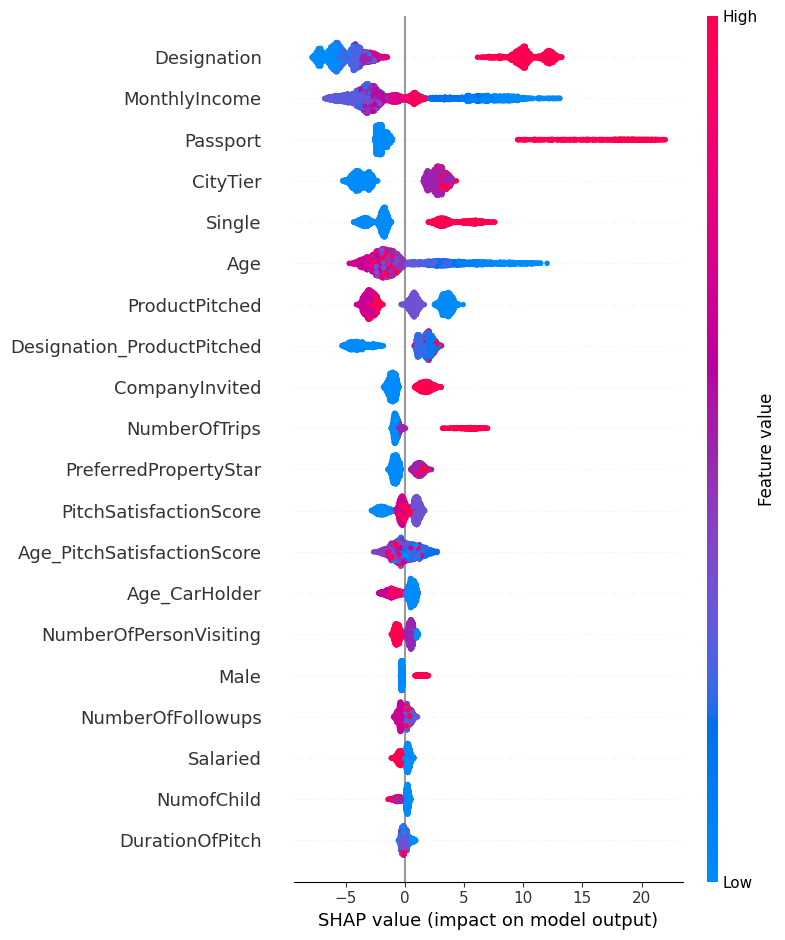

In [ ]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()

# 各FOLD、SEEDの和 (相対値なのでこれで良しとする)
shapval = 0
for i in range(3):
  for j in range(5):
    explainer = shap.TreeExplainer(models[i][j])
    shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))
    shapval = shapval + shap_values

shap.summary_plot(shapval, train.drop("ProdTaken",axis=1))

In [ ]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken', 'Designation_ProductPitched',
       'Passport_Single', 'Age_PitchSatisfactionScore', 'Age_CarHolder'],
      dtype='object')

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

NameError: name 'oof_lgb' is not defined

7. 提出

In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [ ]:
# テストデータを用いて予測します。
predict = 0
for i in range(3):
  for j in range(5):
    predict = predict + models[i][j].predict(test)
predict = predict / 15
submit[1] = predict

In [ ]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 5 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.835515	valid's auc: 0.836304


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846733	valid's auc: 0.840351
[300]	train's auc: 0.855644	valid's auc: 0.839666
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833964	valid's auc: 0.827559
[200]	train's auc: 0.845655	valid's auc: 0.837258
[300]	train's auc: 0.854293	valid's auc: 0.843077
[400]	train's auc: 0.86177	valid's auc: 0.843294
[500]	train's auc: 0.867884	valid's auc: 0.84495
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843199	valid's auc: 0.793562
[200]	train's auc: 0.853454	valid's auc: 0.802718
[300]	train's auc: 0.862205	valid's auc: 0.809329
[400]	train's auc: 0.868638	valid's auc: 0.80857
#########################
### Fold 4
#########################
[100]	train's auc: 0.837455	valid's auc: 0.824784
[200]	train's auc: 0.850055	valid's auc: 0.827878


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.858332	valid's auc: 0.831824
[400]	train's auc: 0.865231	valid's auc: 0.83233
[500]	train's auc: 0.871703	valid's auc: 0.834354
#########################
### Fold 5
#########################
[100]	train's auc: 0.842865	valid's auc: 0.801544


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852312	valid's auc: 0.816206
[300]	train's auc: 0.86099	valid's auc: 0.821172
[400]	train's auc: 0.868284	valid's auc: 0.822523
[500]	train's auc: 0.873781	valid's auc: 0.823959
[600]	train's auc: 0.878005	valid's auc: 0.825344
CPU times: user 24.8 s, sys: 904 ms, total: 25.7 s
Wall time: 4.49 s


In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8299435651341203
